In [6]:
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
sys.path.append('../../')

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import nibabel as nib
from scipy.spatial.distance import cdist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
field = np.load("data/base/registered_output/deformation3d.npy")
print(field[:, 0])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [8]:
def check_neighborhood(point, point_list, max_dist):
    """
    Check if a point is within a certain distance of any point in a list of points.
    
    Parameters
    ----------
    point : tuple
        The point to check.
    point_list : list of tuples
        The list of points to check against.
    dist : float
        The distance threshold.
        
    Returns
    -------
    bool
        True if the point is within the distance threshold of any point in the list, False otherwise
    """
    computed_dist = cdist([point], point_list)[0]
    #print(computed_dist)
    #if computed_dist <= dist:
    if any(d <= max_dist for d in computed_dist):
        return True
    return False

pt = [5, 0]
pt_list = [ (0, 0), (1, 0), (4, 1) ]

check_neighborhood(pt, pt_list, 3)

True

In [9]:
# Set the npy filepath with the jacobian determinant values
npy_path = '_archive/odata/jacobian_det_np_arr.npy'
section = 350

# Load the numpy array
jacobian_det = np.load(npy_path)
print("Shape of jacobian_det:", jacobian_det.shape)

# Get the coordinates of pixels with values less than 0
coordinates = np.argwhere(jacobian_det[section] < 0)

# Convert to a list of tuples
coordinates_list = [tuple(coord) for coord in coordinates]

# Print the coordinates
print("Number of pixels with values less than 0:", len(coordinates_list))
#pprint(coordinates_list)

print("Max value in coordinates:", np.max(coordinates_list, axis=0))

Shape of jacobian_det: (528, 320, 456)
Number of pixels with values less than 0: 1287
Max value in coordinates: [271 431]


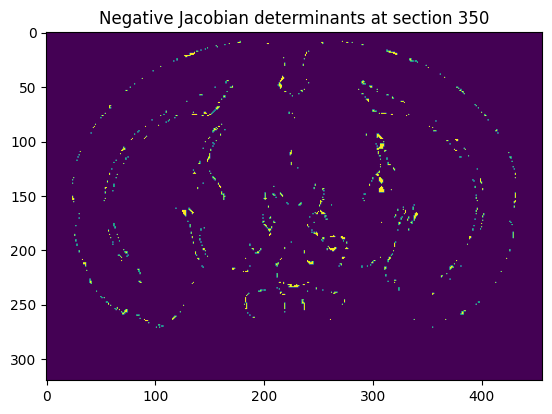

In [10]:
# Show the section with negative jacobian determinants
plt.imshow(jacobian_det[section]<0, cmap='viridis')
plt.title("Negative Jacobian determinants at section " + str(section))
plt.show()

Compute percentage of negative Jacobians that are correspondences

In [12]:
def remove_duplicates(list1: np.ndarray, list2: np.ndarray):
    """
    Remove duplicate elements from list1 and the corresponding elements from list2.
    
    Parameters:
    - list1: The first list from which duplicates will be removed.
    - list2: The second list from which elements will be removed corresponding to the removed elements in list1.
    
    Returns:
    - list1_unique: The list1 with duplicates removed.
    - list2_filtered: The list2 with elements removed corresponding to the removed elements in list1.
    """
    seen = set()
    list1_unique = []
    list2_filtered = []
    
    for item1, item2 in zip(list1, list2):
        item1_tuple = tuple(item1)
        if item1_tuple not in seen:
            seen.add(item1_tuple)
            list1_unique.append(item1)
            list2_filtered.append(item2)
    
    return np.array(list1_unique), np.array(list2_filtered)

mpoints = np.load("data/base/mpoints.npy")
fpoints = np.load("data/base/fpoints.npy")

# Create a binary image to show the correspondences
curr_idx = 350
print("\nChecking slice", curr_idx)

# Get relevant corresponding image points
curr_mpoints = np.array([point[1:] for point in mpoints if point[0] == curr_idx])
curr_mpoints = curr_mpoints.astype(int)
curr_fpoints = np.array([point[1:] for point in fpoints if point[0] == curr_idx])
curr_fpoints = curr_fpoints.astype(int)
curr_mpoints_unique, curr_fpoints_unique = remove_duplicates(curr_mpoints, curr_fpoints)
print("Number of unique moving points for slice", curr_idx, ":", len(curr_mpoints_unique))
print("Number of unique fixed points for slice", curr_idx, ":", len(curr_fpoints_unique))
print()


# How many points in the negative jacobian determinant section are part of our failed Delaunay verification checks?
total_points = len(coordinates_list)
num_matches = 0
curr_points = curr_fpoints

# How many Jacobians are in the negative section that are part of the correspondences?
for i in range(total_points):
    jacobian_coord = coordinates_list[i]
    # Check if the point is in the correspondences
    #if jacobian_coord in curr_fpoints:
    #    num_matches += 1
    for j in range(len(curr_points)):
        if jacobian_coord == tuple(curr_points[j]):
            num_matches += 1
            #print(f"Point {jacobian_coord} found at index {j} in curr_fpoints_unique.")
            #print( "Corresponding point:", curr_fpoints[j])
            break
            
print("Number of points in negative Jacobian determinant section that are part of correspondences:")
print(f"\t{num_matches}/{total_points} ({num_matches/total_points*100:.2f}%)")

# How many Jacobians are in the negative section that are part of the correspondences (neighborhood check)?
num_matches_neighborhood = 0
for i in range(total_points):
    jacobian_coord = coordinates_list[i]
    # Check if the point is in the correspondences
    if check_neighborhood(jacobian_coord, curr_points, 5):
        num_matches_neighborhood += 1

print("Number of points in negative Jacobian determinant section that are part of correspondences (neighborhood):")
print(f"\t{num_matches_neighborhood}/{total_points} ({num_matches_neighborhood/total_points*100:.2f}%)")


Checking slice 350
Number of unique moving points for slice 350 : 1326
Number of unique fixed points for slice 350 : 1326

Number of points in negative Jacobian determinant section that are part of correspondences:
	425/1287 (33.02%)
Number of points in negative Jacobian determinant section that are part of correspondences (neighborhood):
	1137/1287 (88.34%)


Compute line intersections between correspondences

In [13]:
def orientation(p, q, r):
    """
    Calculate the orientation of the ordered triplet (p, q, r).
    
    Parameters:
    - p, q, r: Points represented as tuples or lists with two elements (x, y).
    
    Returns:
    - 0 if the points are collinear.
    - 1 if the points form a clockwise orientation.
    - 2 if the points form a counterclockwise orientation.
    """
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0
    return 1 if val > 0 else 2


def on_segment(p, q, r):
    """
    Check if point q lies on the line segment pr.
    
    Parameters:
    - p, q, r: Points represented as tuples or lists with two elements (x, y).
    
    Returns:
    - True if q lies on the line segment pr, False otherwise.
    """
    if min(p[0], r[0]) < q[0] < max(p[0], r[0]) and min(p[1], r[1]) < q[1] < max(p[1], r[1]):
        return True
    return False


def do_lines_intersect(p1, q1, p2, q2):
    """
    Check if two line segments (p1, q1) and (p2, q2) intersect.
    
    Parameters:
    - p1, q1: Endpoints of the first line segment.
    - p2, q2: Endpoints of the second line segment.
    
    Returns:
    - True if the line segments intersect, False otherwise.
    """
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)
    
    # Special cases (collinear and one endpoint lies on the other line segment)
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True
    
    # Case: one endpoint is an endpoint on another line segment
    if np.array_equal(p1, p2) or np.array_equal(p1, q2) or np.array_equal(q1, p2) or np.array_equal(q1, q2):
        return False
    
    # General case
    if o1 != o2 and o3 != o4:
        return True

    return False

Did the line segments intersect? False


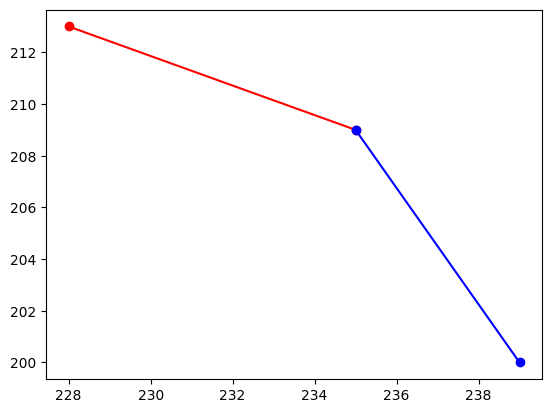

In [14]:
s1 = ([235, 209], [228, 213])
s2 = ([239, 200], [235, 209])

p1, q1 = s1
p2, q2 = s2

did_intersect = do_lines_intersect(p1, q1, p2, q2)
print("Did the line segments intersect?", did_intersect)

plt.plot([p1[0], q1[0]], [p1[1], q1[1]], 'ro-')
plt.plot([p2[0], q2[0]], [p2[1], q2[1]], 'bo-')
plt.show()

In [15]:
def plot_correspondences(mpts: np.ndarray, fpts: np.ndarray, section_img: np.ndarray, title: str=""):
    """
    Plot the correspondences between moving and fixed points on a NIfTI image.
    
    Parameters:
    - mpts: The moving points.
    - fpts: The fixed points.
    - nifti_img: The NIfTI image.
    - curr_idx: The current slice index.
    """
    plt.figure(figsize=(10,10))
    plt.imshow( section_img, cmap='gray', alpha=0.75)
    plt.scatter( mpts[:,1], mpts[:,0], color='green', label='Moving Points', s=2)
    plt.scatter( fpts[:,1], fpts[:,0], color='red', label='Fixed Points', s=1)
    for i in range(len(mpts)):
        plt.plot([mpts[i][1], fpts[i][1]], [mpts[i][0], fpts[i][0]], color='blue', alpha=0.75)
    plt.legend(loc='upper right')
    plt.title(title)
    plt.show()
    

def swap_correspondences(mpts: np.ndarray, fpts: np.ndarray) -> np.ndarray:
    """
    Swap the correspondences of the moving and fixed points if they intersect.
    
    Parameters:
    - mpts: The moving points.
    - fpts: The fixed points.
    
    Returns:
    - swapped_fpts: The swapped fixed points.
    """
    swapped_fpts = np.copy(fpts)
    intersecting_pts = []
    
    for i in range(len(mpts)):
        line_segment1 = (mpts[i], fpts[i])
        for j in range(i + 1, len(mpts)):
            line_segment2 = (mpts[j], fpts[j])
            if do_lines_intersect(line_segment1[0], line_segment1[1], line_segment2[0], line_segment2[1]):
                swapped_fpts[i] = fpts[j]
                swapped_fpts[j] = fpts[i]
                intersecting_pts.append(fpts[i])
                intersecting_pts.append(fpts[j])
                #print(f"Swapped correspondences {i} and {j}")
    return swapped_fpts, intersecting_pts


def detect_intersecting_segments(mpts: np.ndarray, fpts: np.ndarray) -> np.ndarray:
    """
    Detect intersecting line segments in the correspondences.
    
    Parameters:
    - mpts: The moving points.
    - fpts: The fixed points.
    
    Returns:
    - intersecting_indices: The indices of the intersecting line segments.
    - intersecting_segments: The intersecting line segments (points).
    - swapped_segments: The swapped line segments (points).
    """
    intersecting_indices = []
    intersecting_segments = []
    swapped_segments = []
    
    for i in range(len(mpts)):
        line_segment1 = (mpts[i], fpts[i])
        for j in range(i + 1, len(mpts)):
            line_segment2 = (mpts[j], fpts[j])
            # Check if the line segments intersect
            if do_lines_intersect(line_segment1[0], line_segment1[1], line_segment2[0], line_segment2[1]):
                intersecting_indices.append((i, j))
                intersecting_segments.append((line_segment1, line_segment2))
                swapped_segments.append(((mpts[i], fpts[j]), (mpts[j], fpts[i])))
    intersecting_indices = np.array(intersecting_indices)
    return intersecting_indices, intersecting_segments, swapped_segments


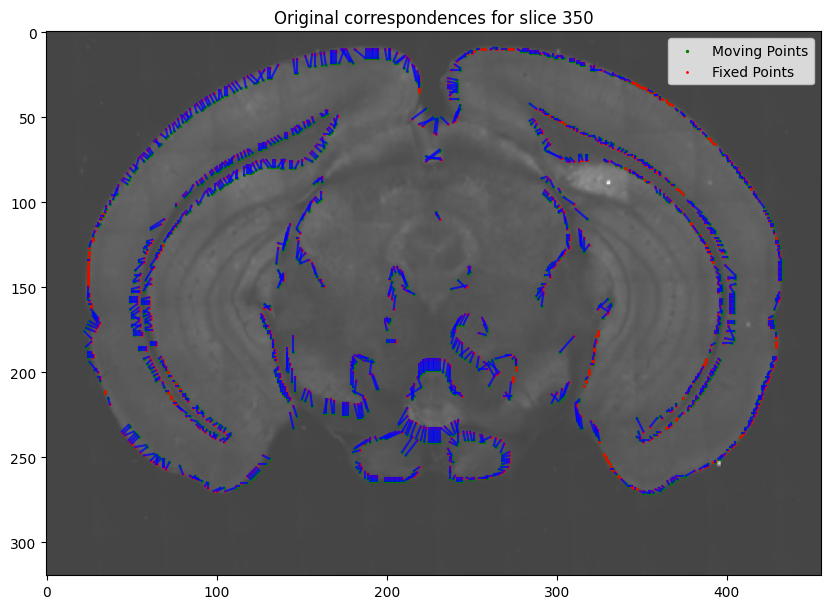

Number of intersecting points: 30
Number of intersecting points: 16
Number of intersecting points: 14
Number of intersecting points: 14


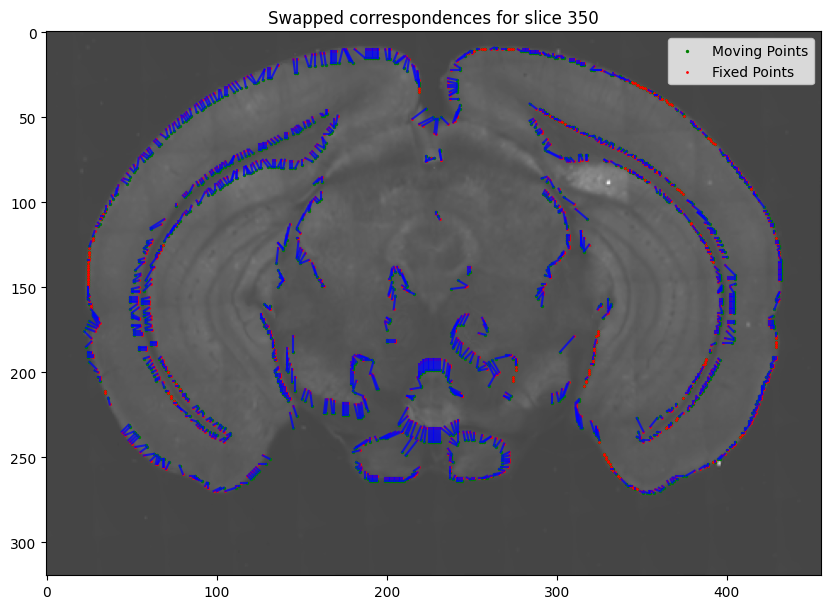

Number of intersecting segments left: 0
Number of intersecting segments left: 0
Intersecting indices:
array([], dtype=float64)
Segment (array([ 17, 178]), array([ 10, 173])) intersects with segment (array([ 18, 172]), array([ 10, 175]))


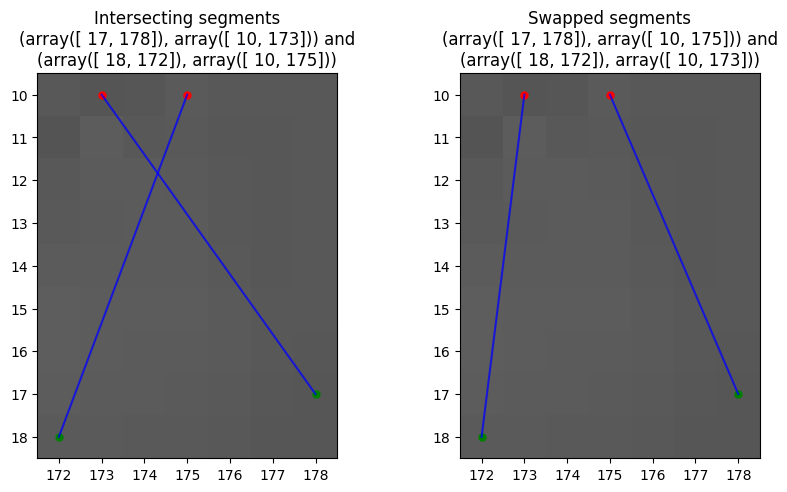

Segment (array([ 17, 179]), array([ 10, 174])) intersects with segment (array([ 18, 172]), array([ 10, 175]))


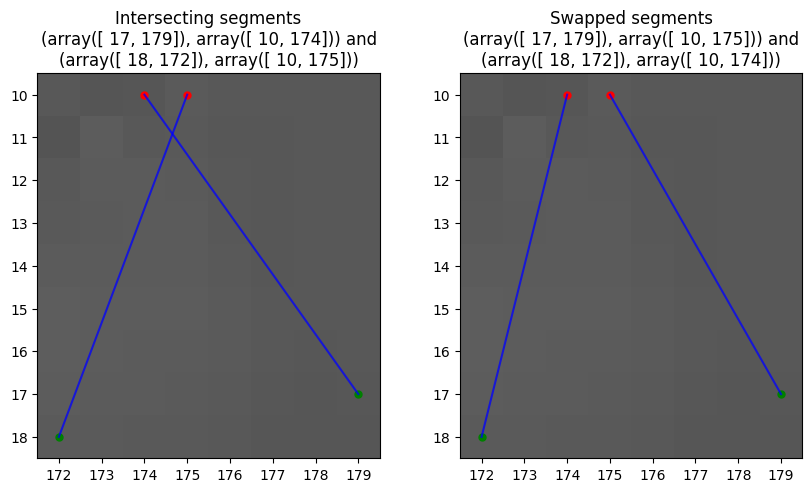

Segment (array([ 14, 296]), array([ 12, 292])) intersects with segment (array([ 13, 293]), array([ 12, 293]))


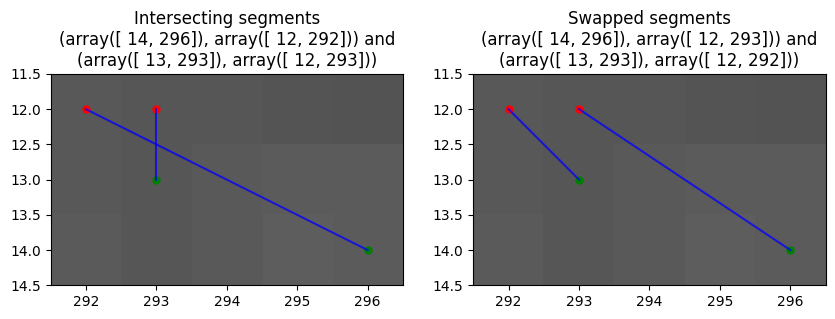

Segment (array([ 14, 296]), array([ 12, 292])) intersects with segment (array([ 14, 295]), array([ 13, 295]))


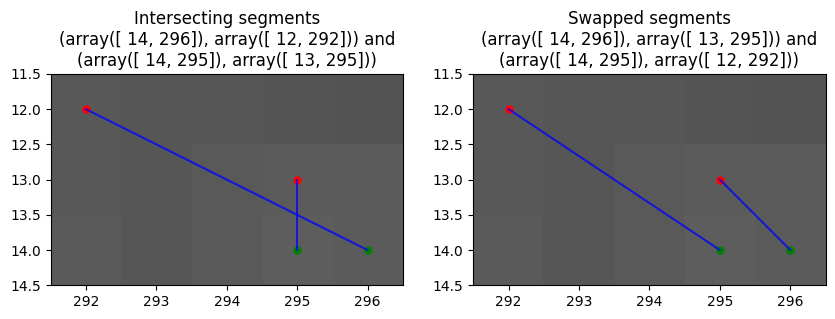

Segment (array([ 15, 300]), array([ 14, 300])) intersects with segment (array([ 15, 299]), array([ 14, 301]))


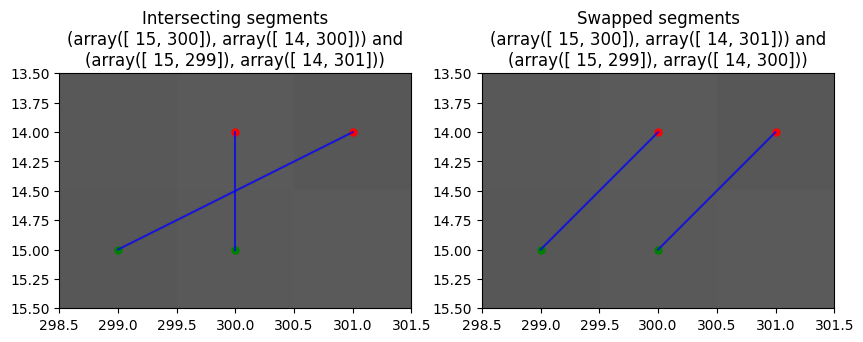

Segment (array([ 15, 304]), array([ 14, 302])) intersects with segment (array([ 15, 303]), array([ 14, 303]))


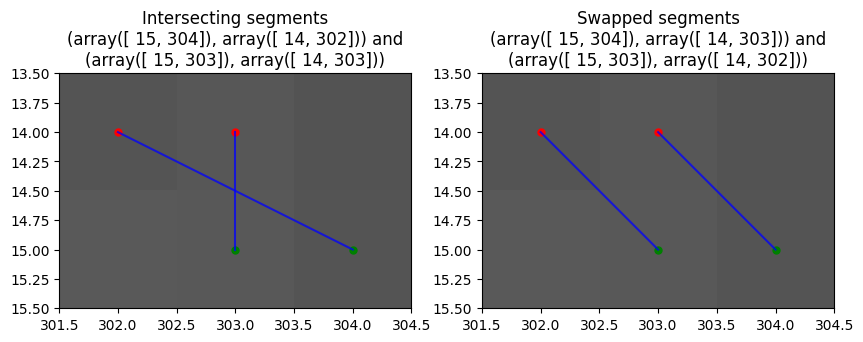

Segment (array([ 22, 321]), array([ 20, 320])) intersects with segment (array([ 22, 320]), array([ 22, 326]))


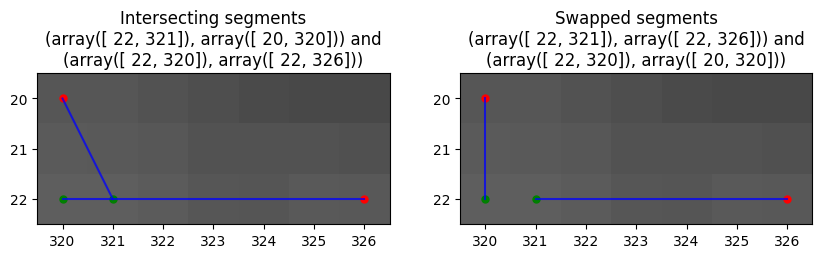

Segment (array([ 22, 322]), array([ 20, 322])) intersects with segment (array([ 22, 320]), array([ 22, 326]))


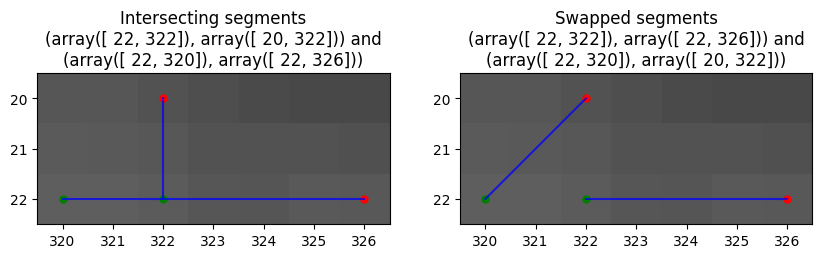

Segment (array([ 30, 123]), array([ 22, 128])) intersects with segment (array([ 28, 127]), array([ 23, 125]))


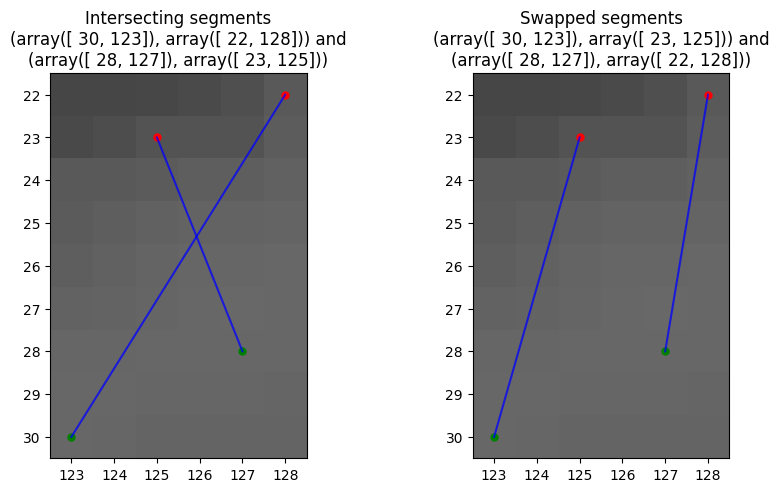

Segment (array([ 30, 123]), array([ 22, 128])) intersects with segment (array([ 29, 124]), array([ 25, 120]))


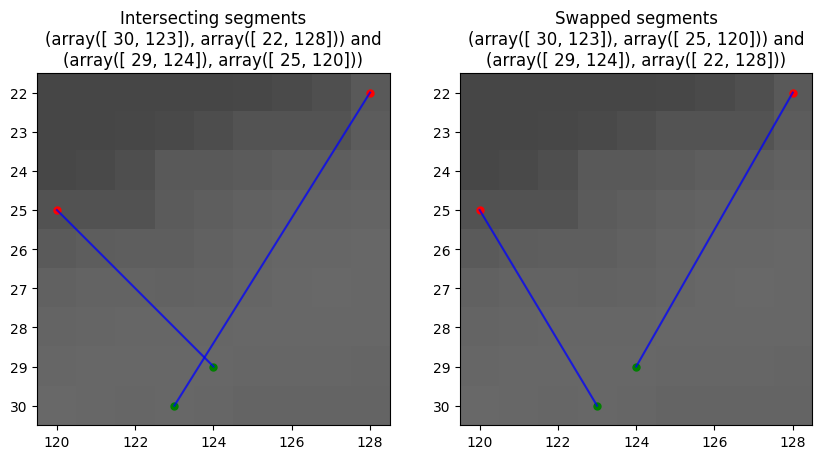

Segment (array([ 30, 219]), array([ 23, 218])) intersects with segment (array([ 31, 219]), array([ 26, 219]))


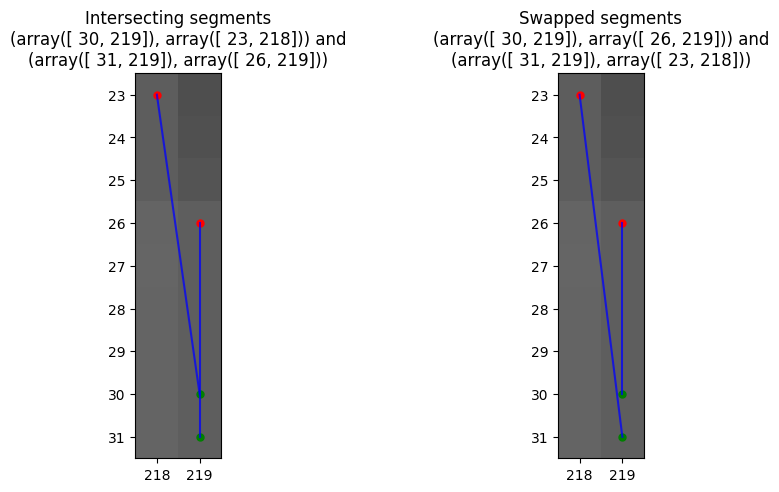

Segment (array([ 30, 219]), array([ 23, 218])) intersects with segment (array([ 32, 219]), array([ 28, 219]))


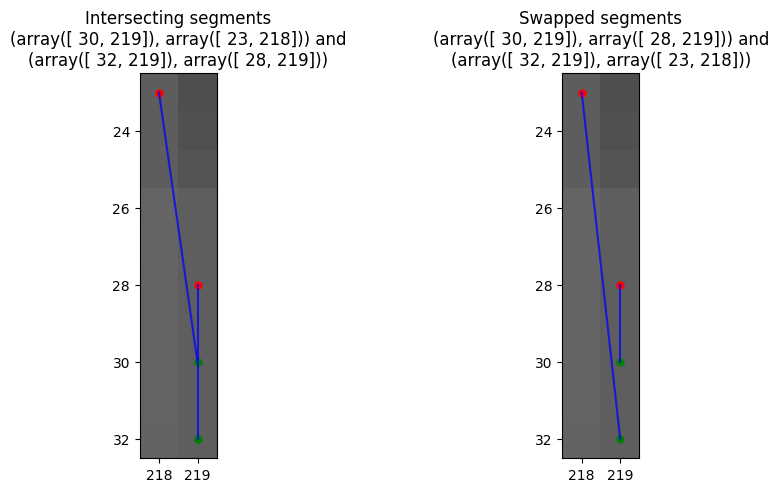

Segment (array([ 34, 241]), array([ 33, 236])) intersects with segment (array([ 33, 241]), array([ 37, 237]))


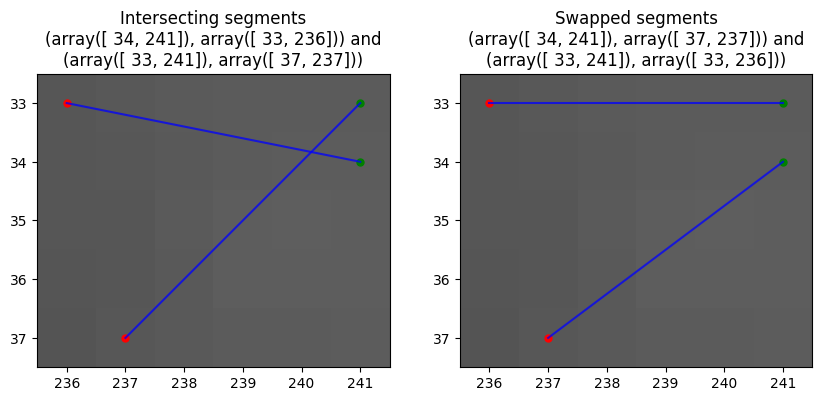

Segment (array([ 35, 241]), array([ 35, 237])) intersects with segment (array([ 33, 241]), array([ 37, 237]))


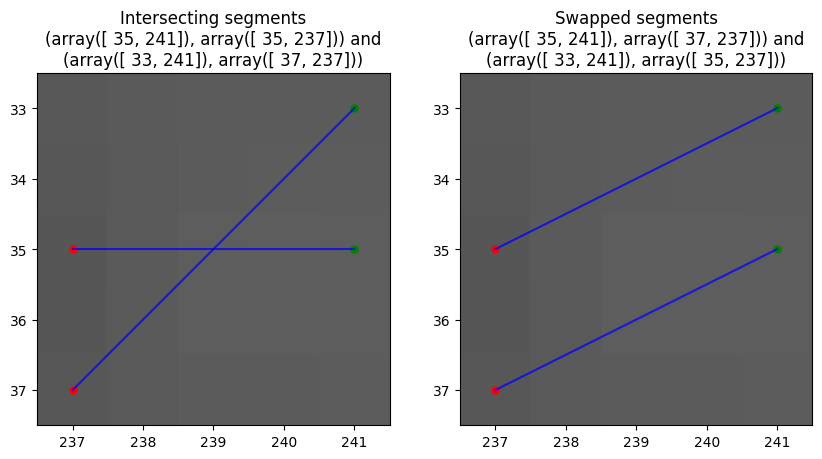

Segment (array([ 48, 165]), array([ 46, 164])) intersects with segment (array([ 48, 164]), array([ 46, 165]))


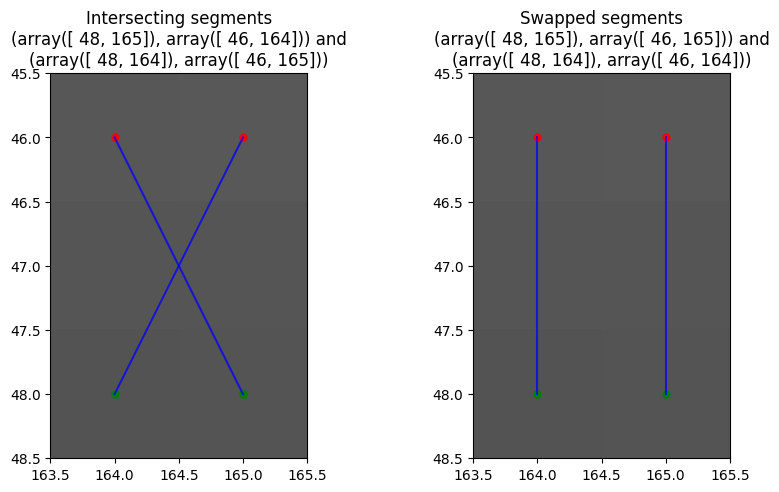

Segment (array([51, 83]), array([47, 82])) intersects with segment (array([50, 84]), array([48, 81]))


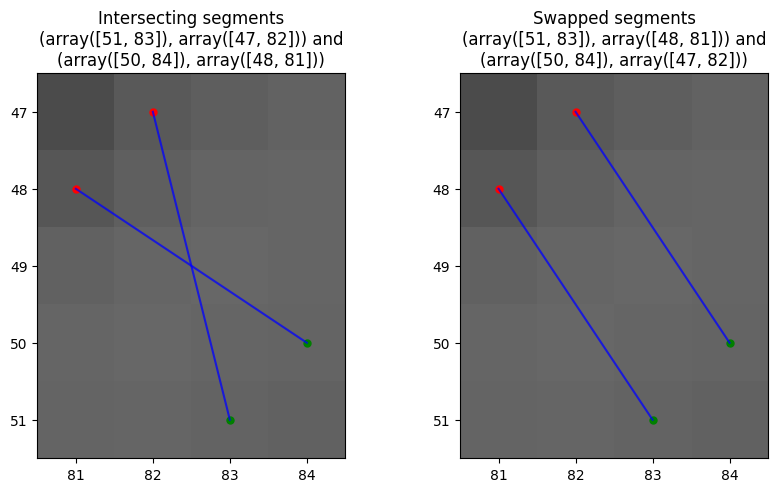

Segment (array([ 49, 375]), array([ 47, 373])) intersects with segment (array([ 48, 374]), array([ 49, 375]))


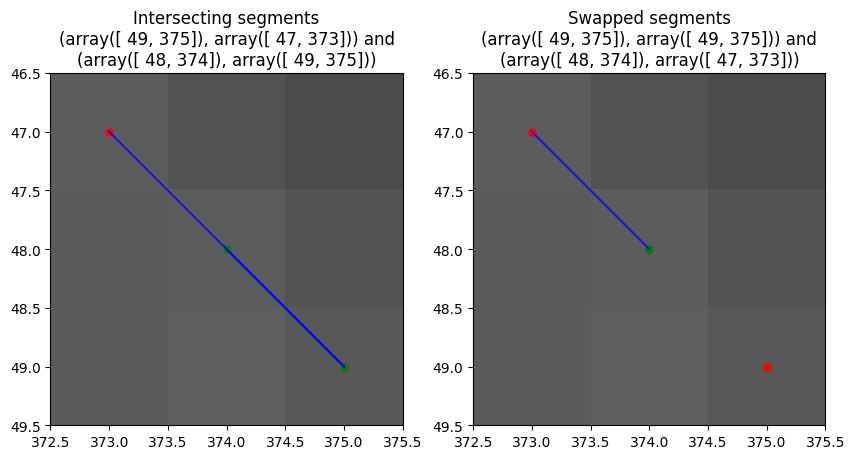

Segment (array([ 49, 163]), array([ 48, 161])) intersects with segment (array([ 49, 162]), array([ 48, 162]))


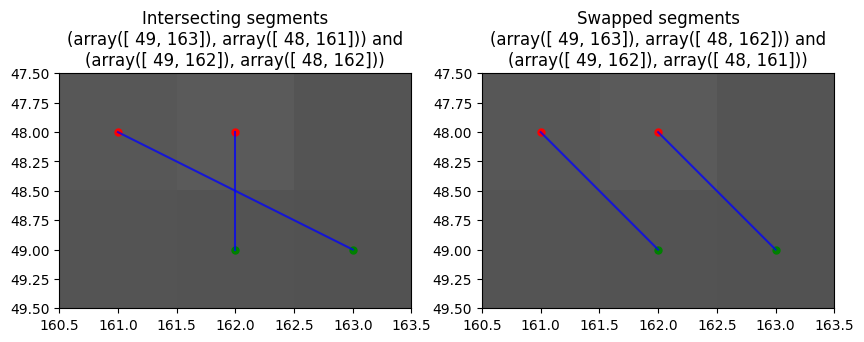

Segment (array([ 56, 169]), array([ 49, 171])) intersects with segment (array([ 54, 170]), array([ 51, 169]))


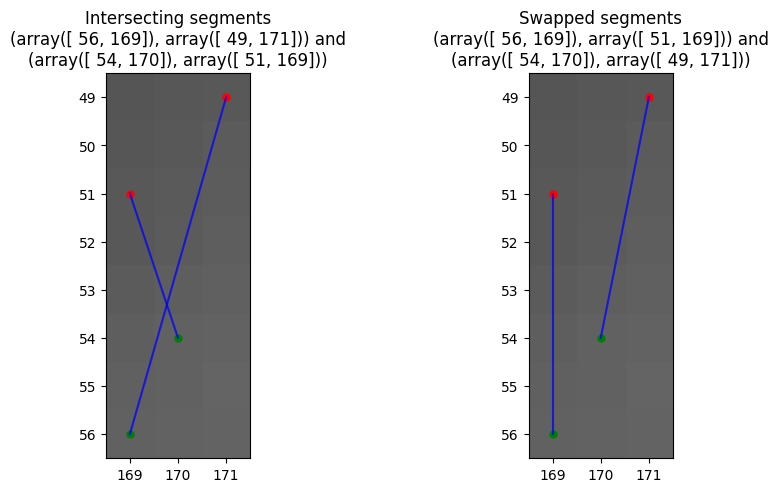

Segment (array([ 43, 243]), array([ 49, 241])) intersects with segment (array([ 46, 242]), array([ 52, 240]))


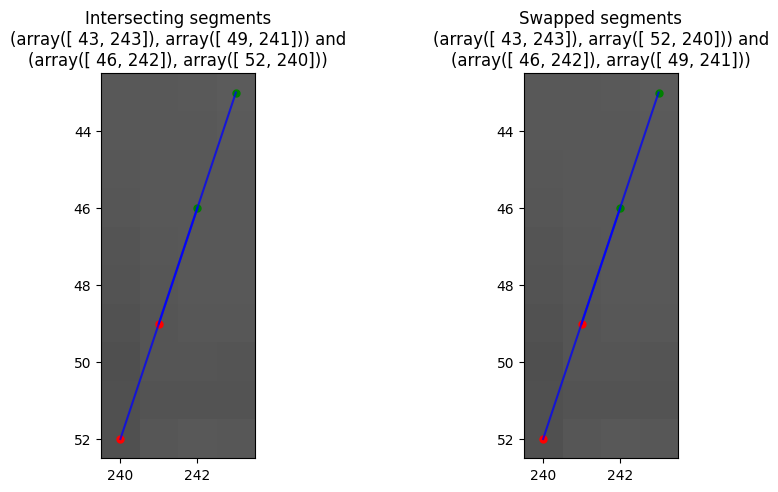

Segment (array([ 51, 228]), array([ 54, 219])) intersects with segment (array([ 50, 227]), array([ 55, 221]))


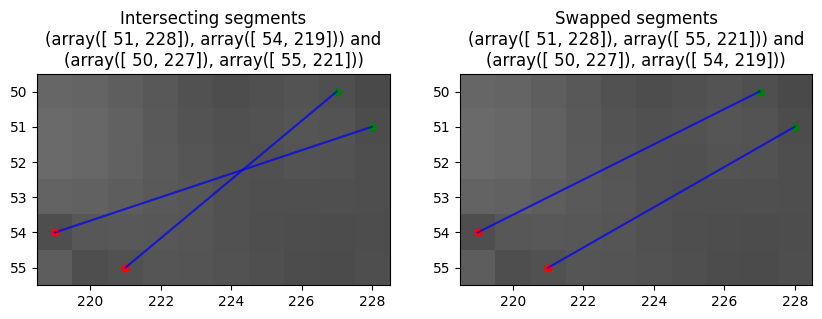

Segment (array([ 57, 150]), array([ 55, 147])) intersects with segment (array([ 58, 149]), array([ 55, 148]))


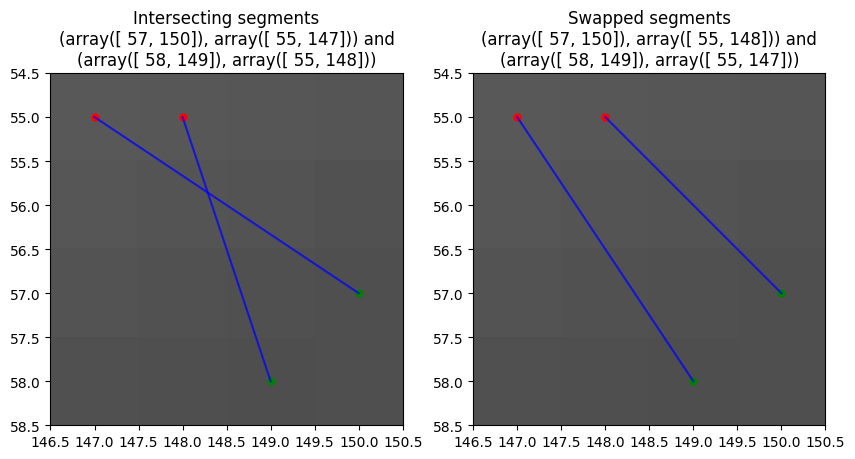

Segment (array([ 59, 147]), array([ 56, 146])) intersects with segment (array([ 59, 148]), array([ 57, 145]))


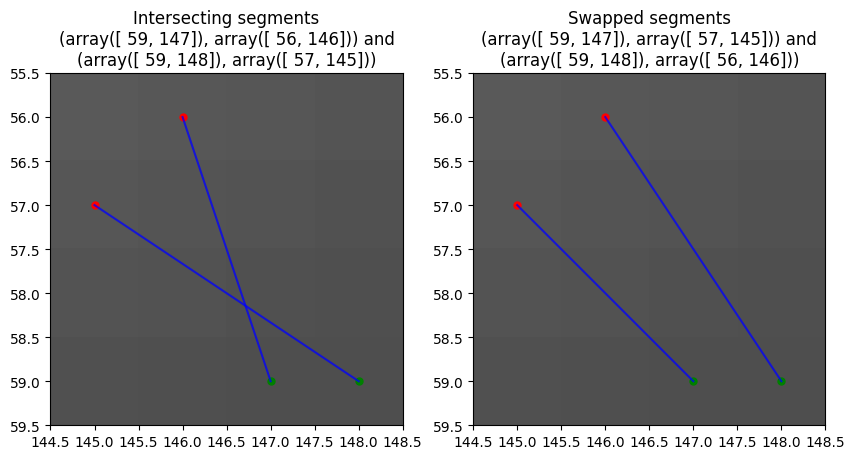

Segment (array([ 60, 289]), array([ 58, 291])) intersects with segment (array([ 59, 289]), array([ 59, 291]))


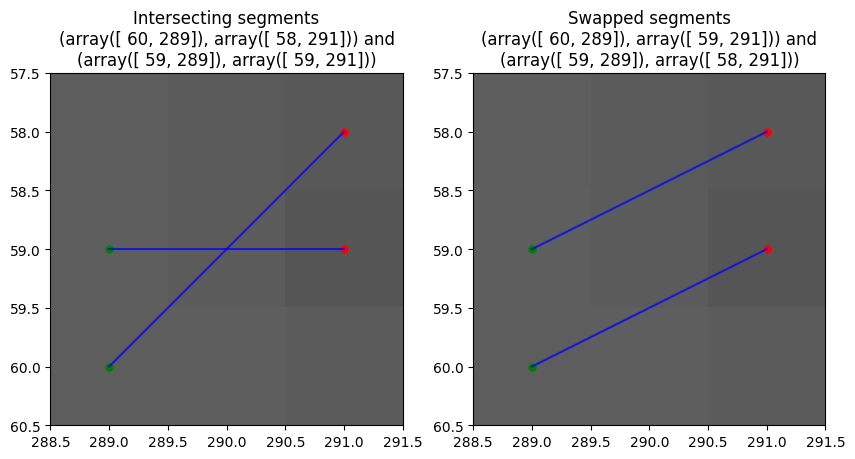

Segment (array([ 68, 163]), array([ 62, 162])) intersects with segment (array([ 65, 164]), array([ 63, 161]))


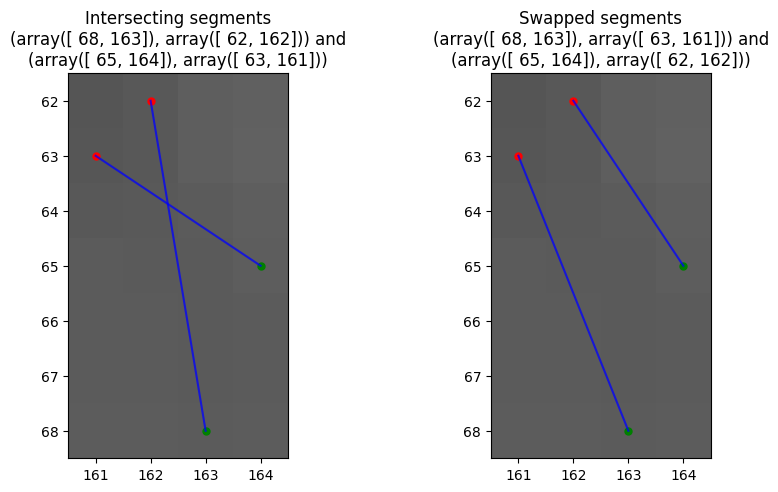

Segment (array([ 68, 163]), array([ 62, 162])) intersects with segment (array([ 67, 163]), array([ 66, 159]))


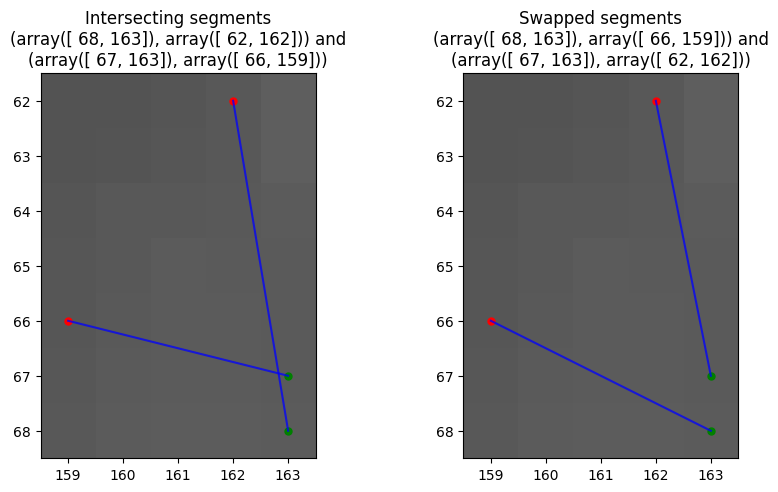

Segment (array([67, 66]), array([63, 64])) intersects with segment (array([66, 67]), array([64, 63]))


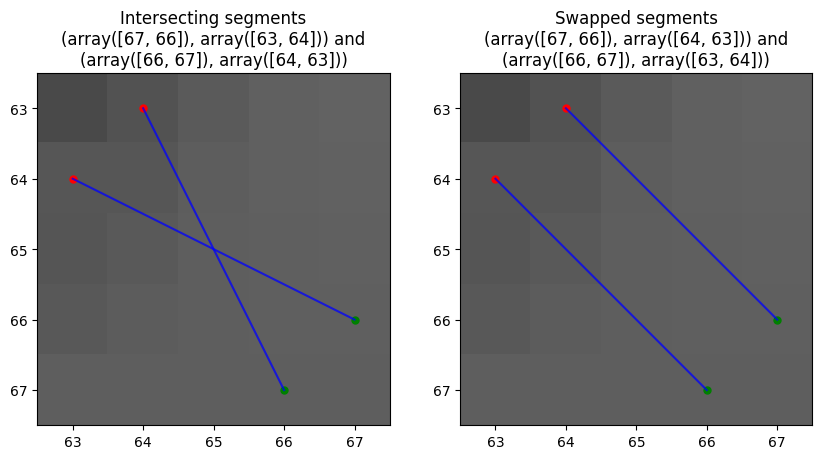

Segment (array([ 63, 326]), array([ 64, 324])) intersects with segment (array([ 62, 325]), array([ 65, 326]))


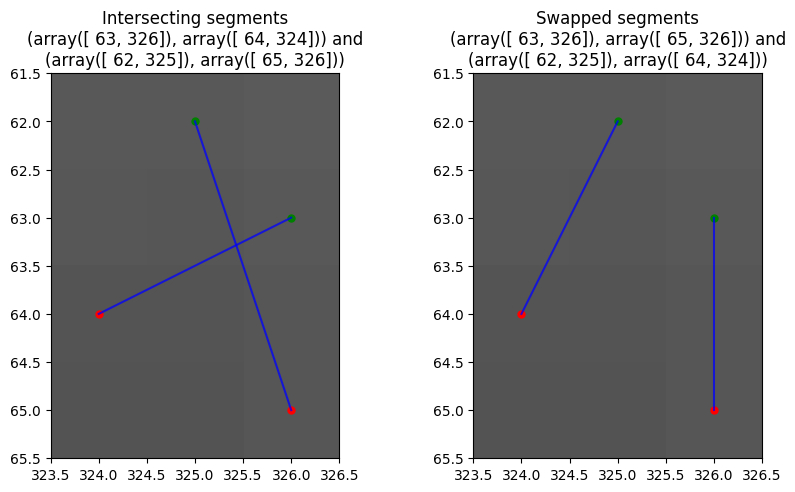

Segment (array([ 69, 293]), array([ 65, 295])) intersects with segment (array([ 68, 293]), array([ 66, 296]))


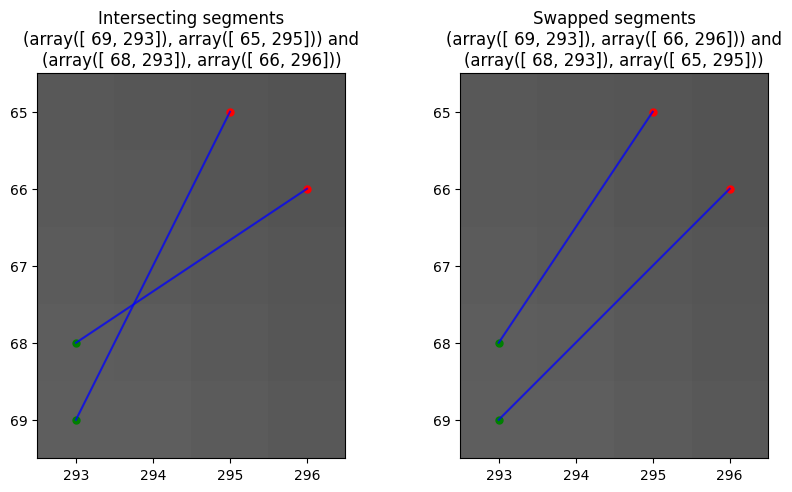

Segment (array([ 65, 330]), array([ 65, 327])) intersects with segment (array([ 64, 329]), array([ 66, 329]))


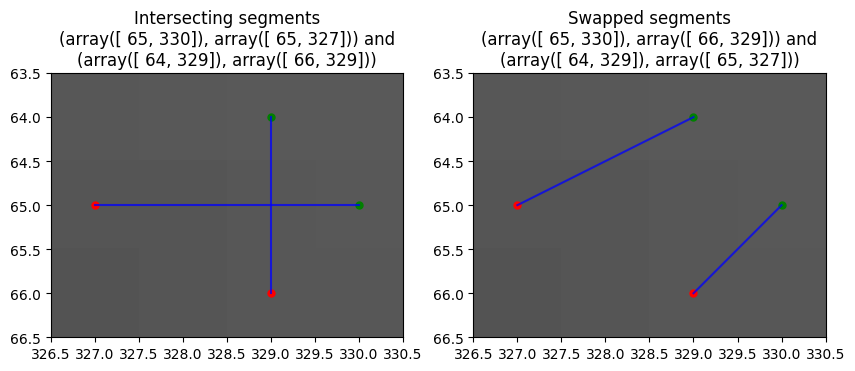

Segment (array([ 66, 333]), array([ 67, 331])) intersects with segment (array([ 65, 332]), array([ 68, 333]))


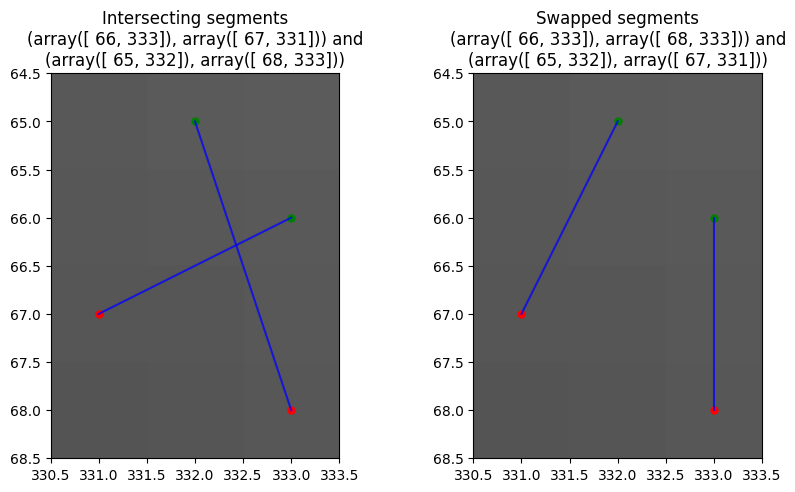

Segment (array([ 78, 106]), array([ 73, 110])) intersects with segment (array([ 77, 109]), array([ 74, 109]))


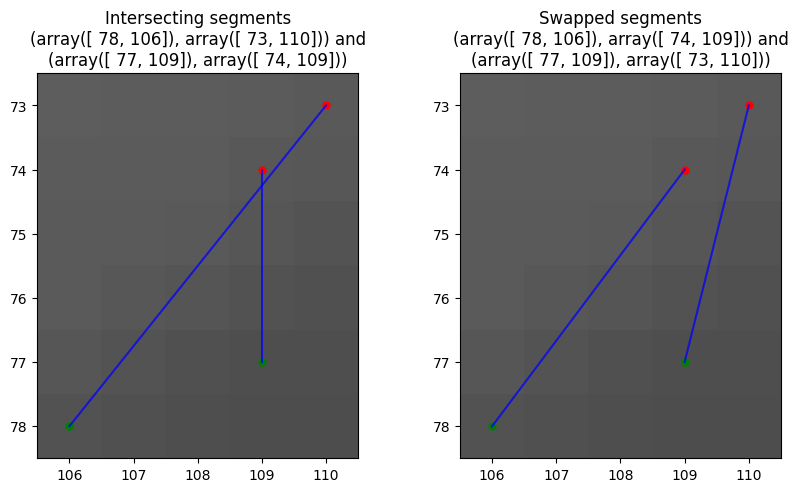

Segment (array([ 78, 106]), array([ 73, 110])) intersects with segment (array([ 77, 108]), array([ 75, 107]))


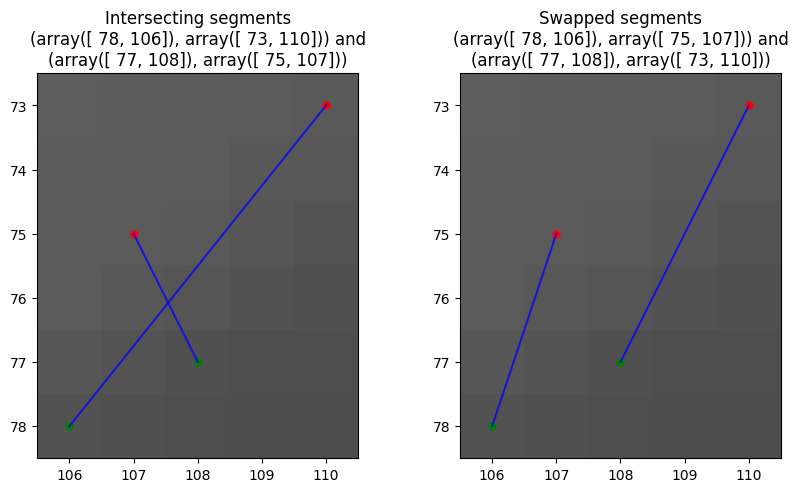

Segment (array([ 78, 106]), array([ 73, 110])) intersects with segment (array([ 78, 107]), array([ 76, 105]))


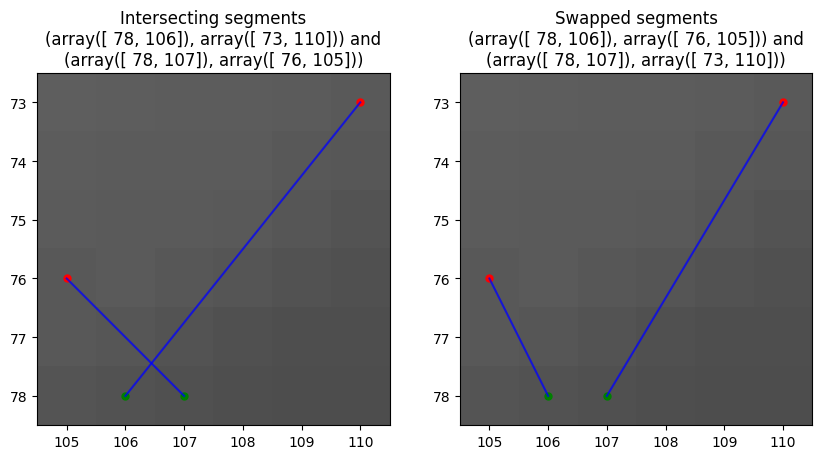

Segment (array([ 70, 294]), array([ 73, 301])) intersects with segment (array([ 70, 295]), array([ 74, 302]))


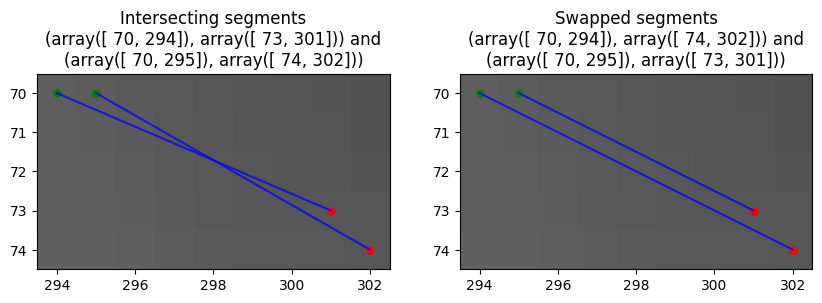

Segment (array([81, 52]), array([74, 54])) intersects with segment (array([80, 53]), array([78, 51]))


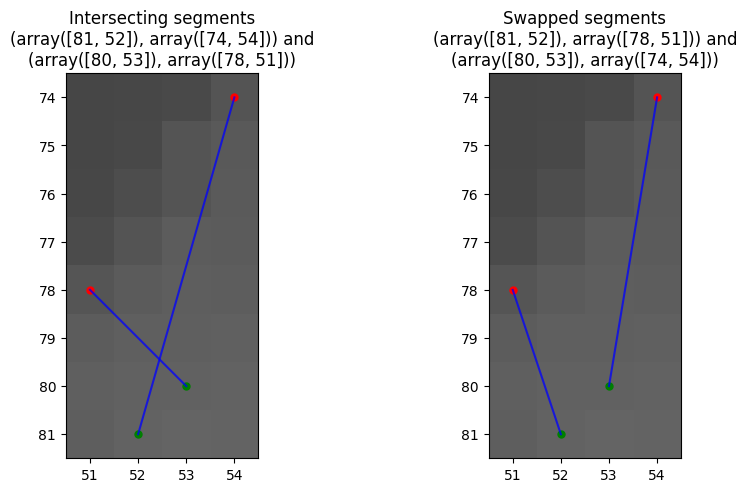

Segment (array([ 74, 228]), array([ 74, 224])) intersects with segment (array([ 69, 231]), array([ 75, 223]))


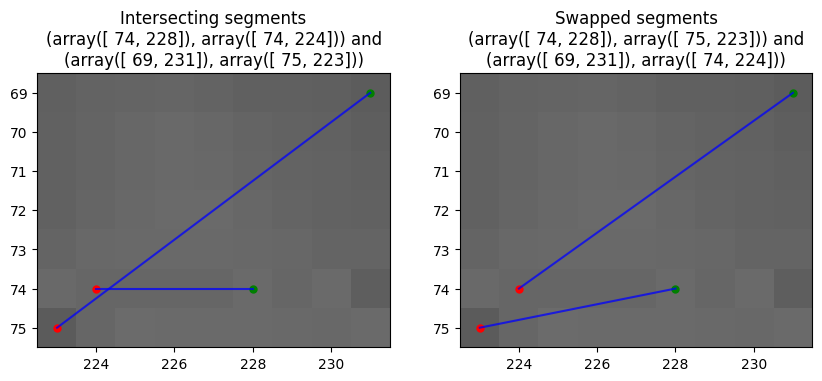

Segment (array([ 74, 228]), array([ 74, 224])) intersects with segment (array([ 73, 223]), array([ 75, 232]))


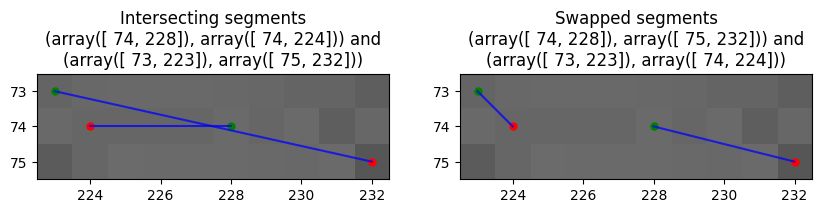

Segment (array([ 74, 228]), array([ 74, 224])) intersects with segment (array([ 70, 231]), array([ 76, 223]))


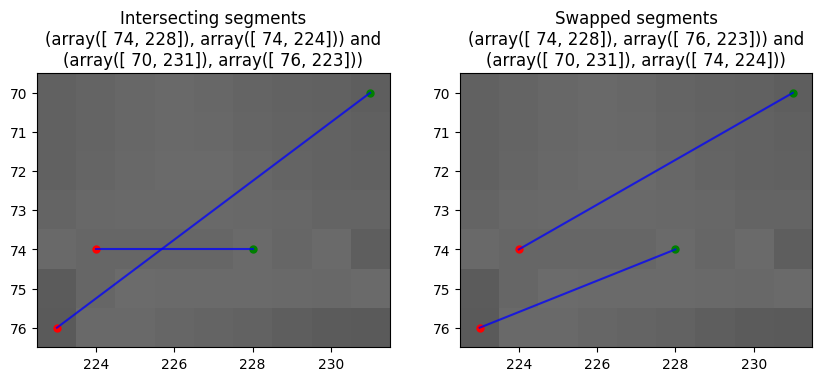

Segment (array([ 74, 225]), array([ 74, 231])) intersects with segment (array([ 73, 223]), array([ 75, 232]))


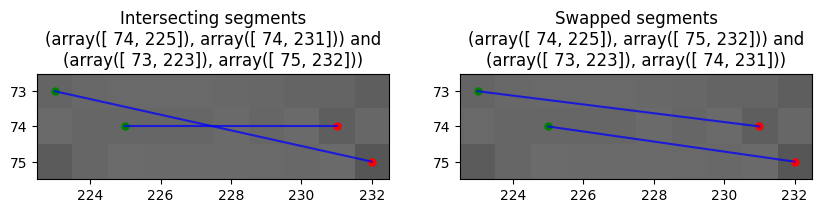

Segment (array([ 74, 225]), array([ 74, 231])) intersects with segment (array([ 70, 231]), array([ 76, 223]))


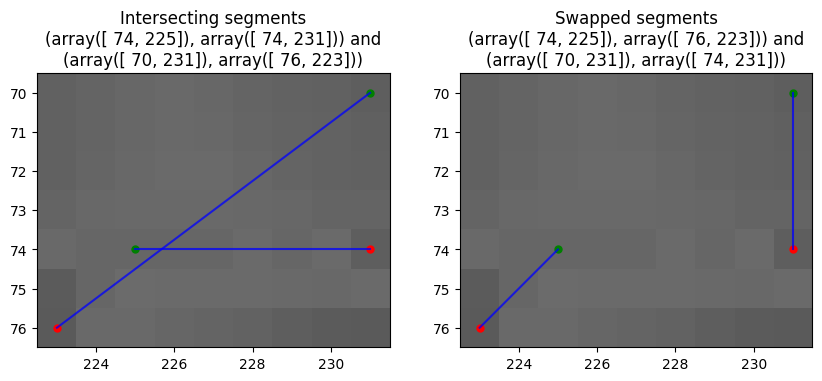

Segment (array([ 80, 139]), array([ 75, 138])) intersects with segment (array([ 79, 136]), array([ 75, 139]))


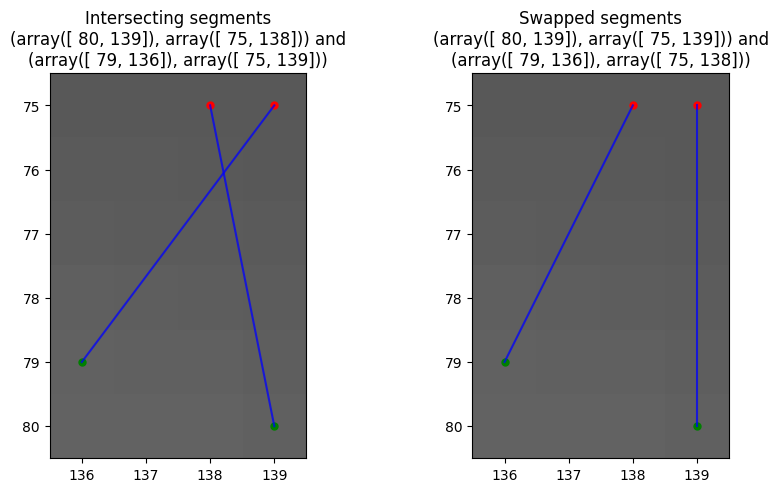

Segment (array([ 80, 139]), array([ 75, 138])) intersects with segment (array([ 80, 138]), array([ 75, 140]))


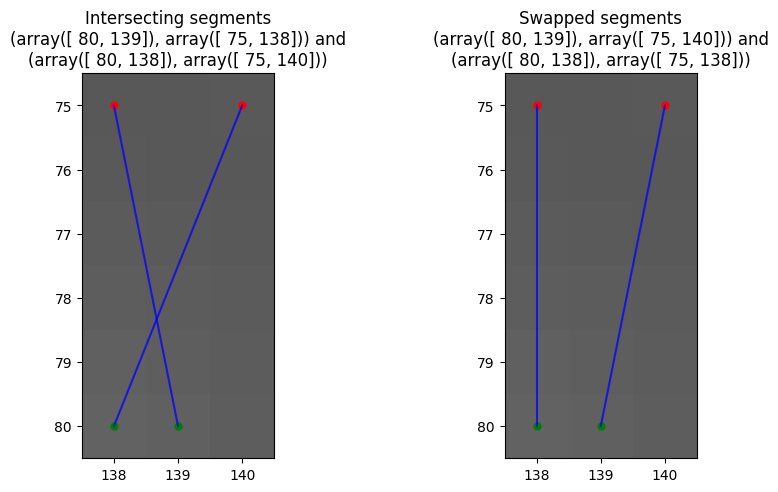

Segment (array([ 69, 231]), array([ 75, 223])) intersects with segment (array([ 73, 223]), array([ 75, 232]))


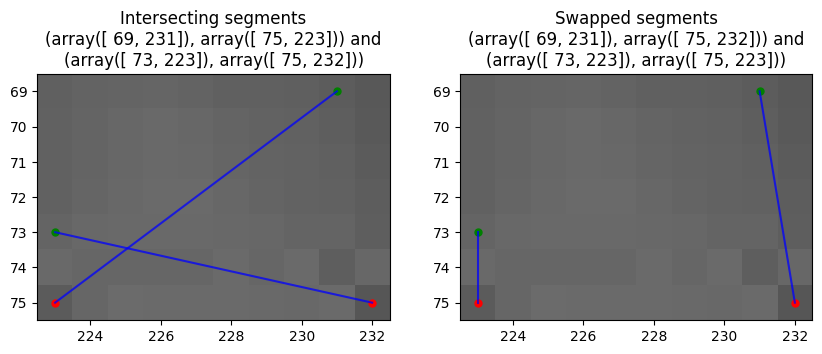

Segment (array([ 73, 223]), array([ 75, 232])) intersects with segment (array([ 70, 231]), array([ 76, 223]))


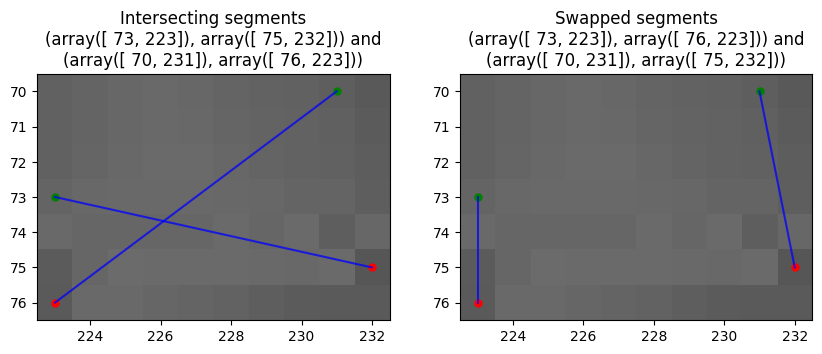

Segment (array([ 83, 118]), array([ 78, 118])) intersects with segment (array([ 82, 121]), array([ 79, 117]))


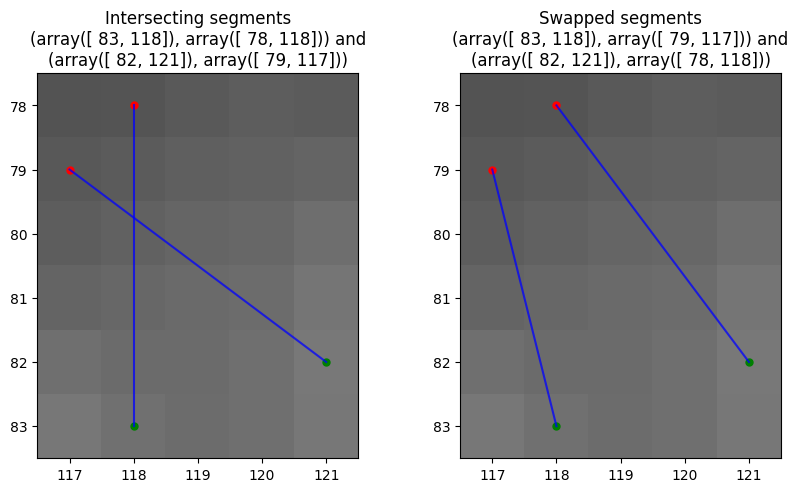

Segment (array([ 83, 119]), array([ 78, 119])) intersects with segment (array([ 82, 121]), array([ 79, 117]))


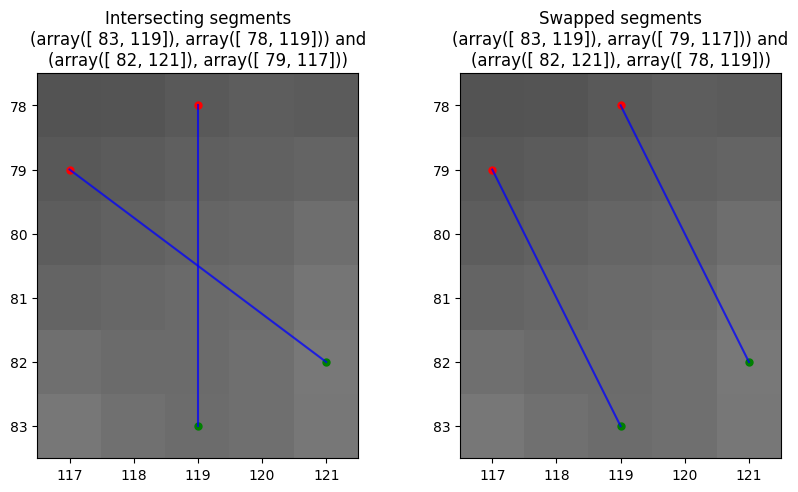

Segment (array([ 83, 120]), array([ 78, 120])) intersects with segment (array([ 82, 121]), array([ 79, 117]))


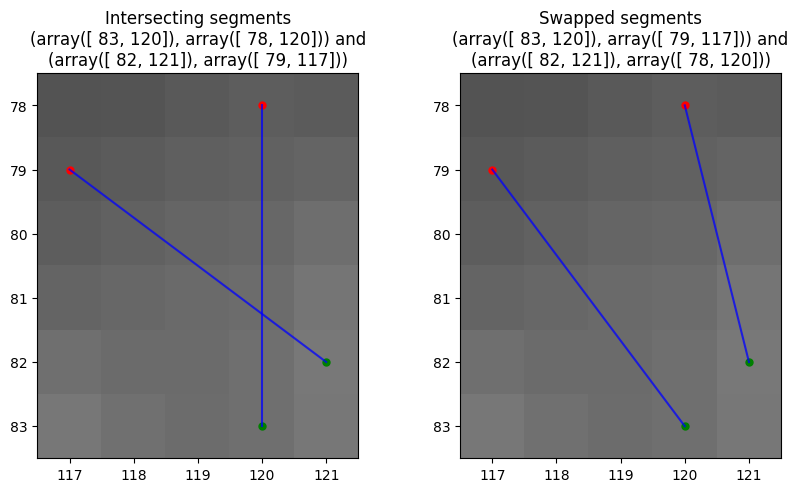

Segment (array([ 88, 107]), array([ 82, 110])) intersects with segment (array([ 87, 109]), array([ 84, 107]))


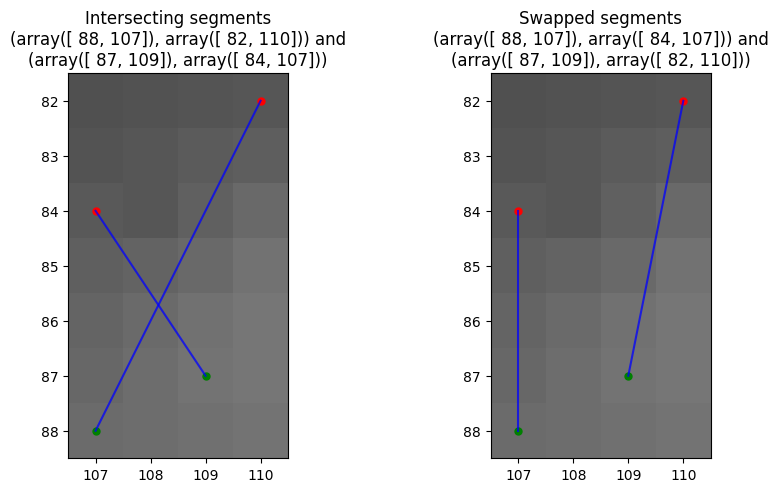

Segment (array([ 88, 107]), array([ 82, 110])) intersects with segment (array([ 88, 108]), array([ 85, 106]))


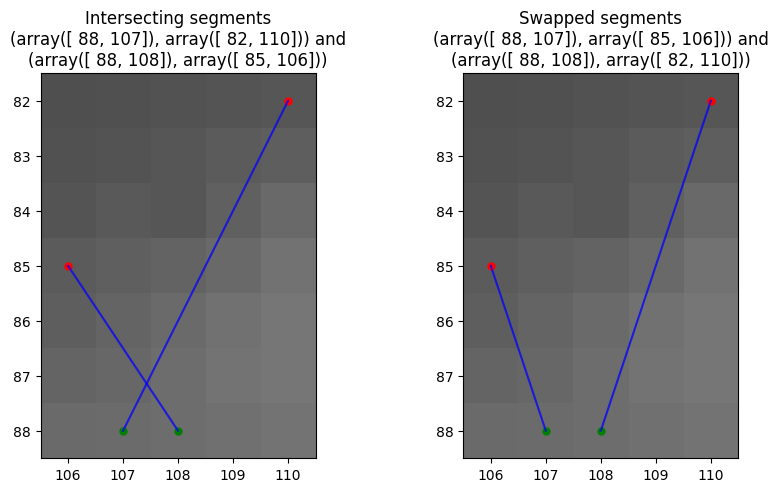

Segment (array([ 88, 366]), array([ 86, 364])) intersects with segment (array([ 87, 365]), array([ 87, 365]))


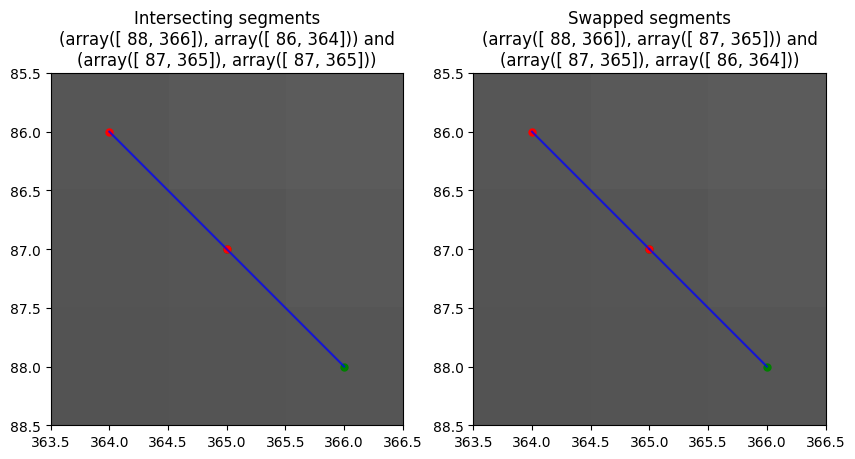

Segment (array([98, 39]), array([92, 41])) intersects with segment (array([96, 40]), array([96, 38]))


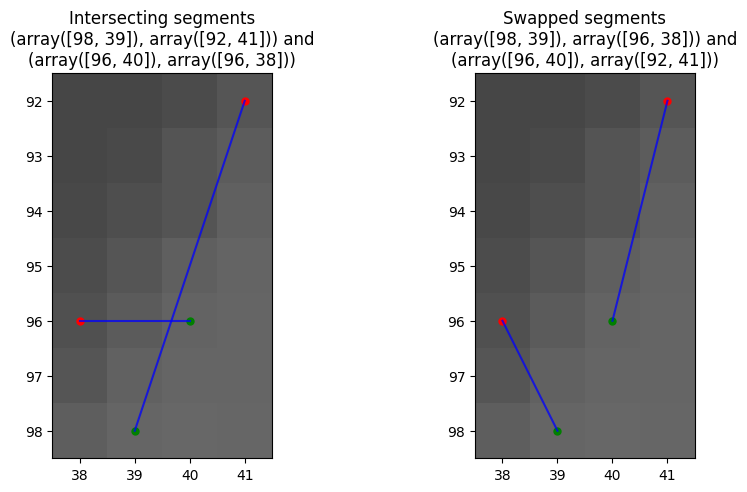

Segment (array([103, 422]), array([ 95, 416])) intersects with segment (array([ 96, 417]), array([ 97, 417]))


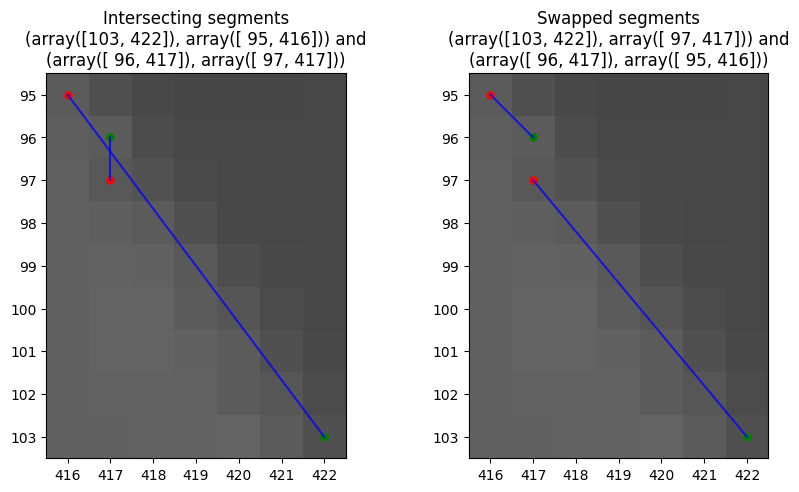

Segment (array([103, 422]), array([ 95, 416])) intersects with segment (array([ 99, 419]), array([ 99, 419]))


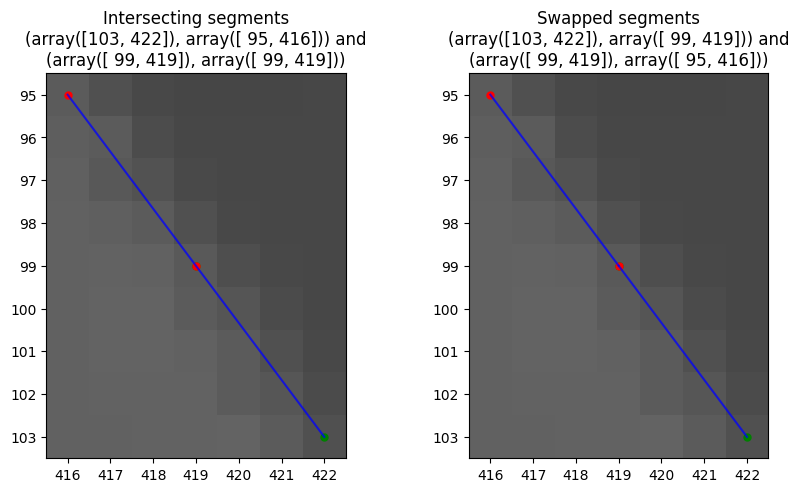

Segment (array([104, 154]), array([ 99, 156])) intersects with segment (array([105, 154]), array([100, 155]))


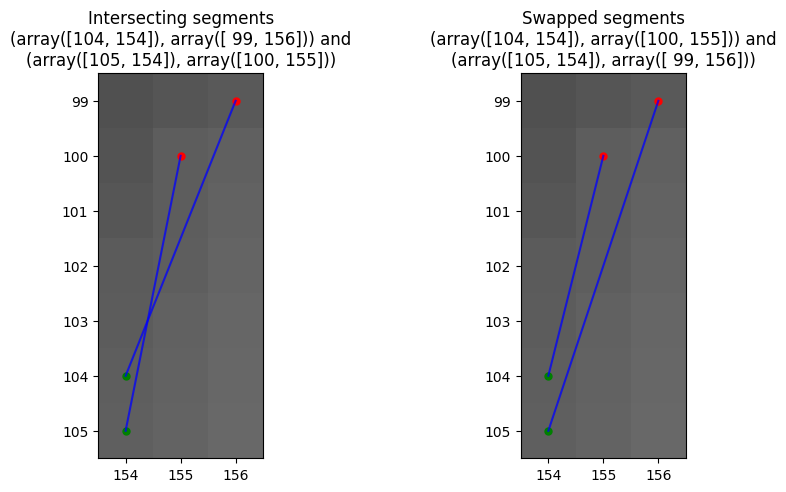

Segment (array([106, 385]), array([ 99, 377])) intersects with segment (array([100, 379]), array([100, 378]))


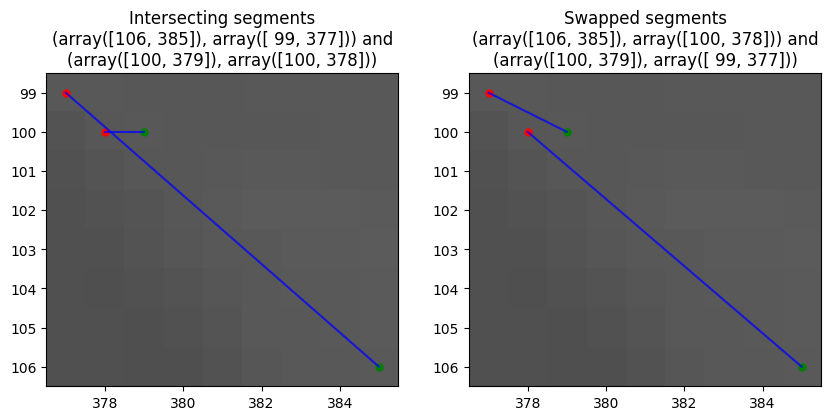

Segment (array([106, 385]), array([ 99, 377])) intersects with segment (array([101, 380]), array([102, 380]))


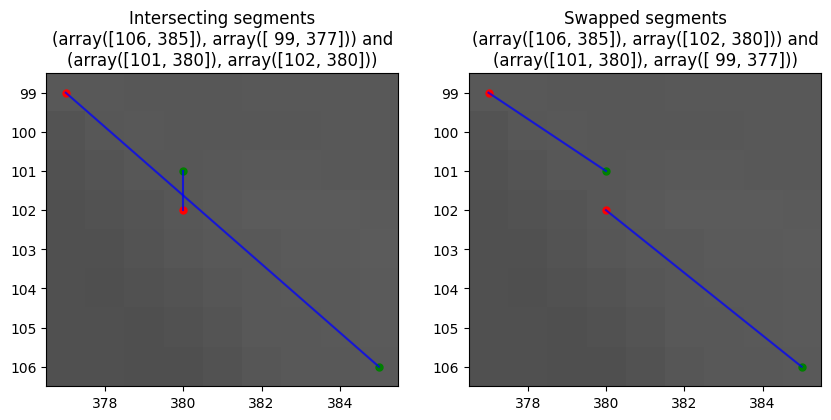

Segment (array([106, 301]), array([104, 303])) intersects with segment (array([105, 301]), array([105, 303]))


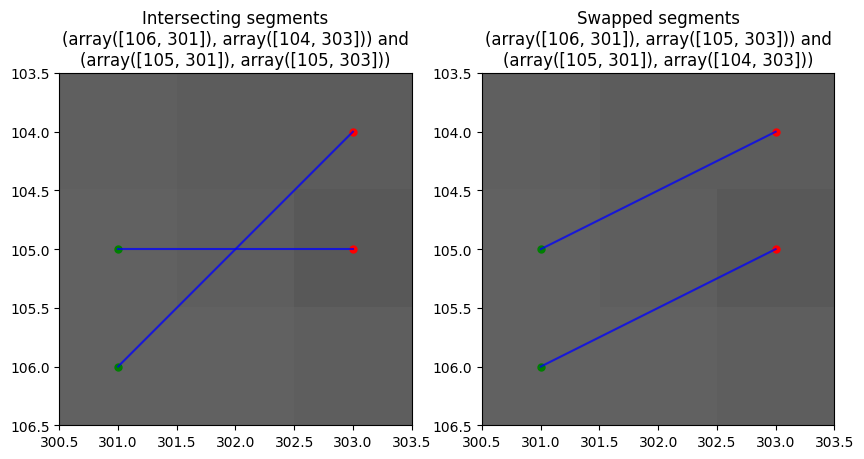

Segment (array([113, 390]), array([106, 383])) intersects with segment (array([108, 386]), array([108, 384]))


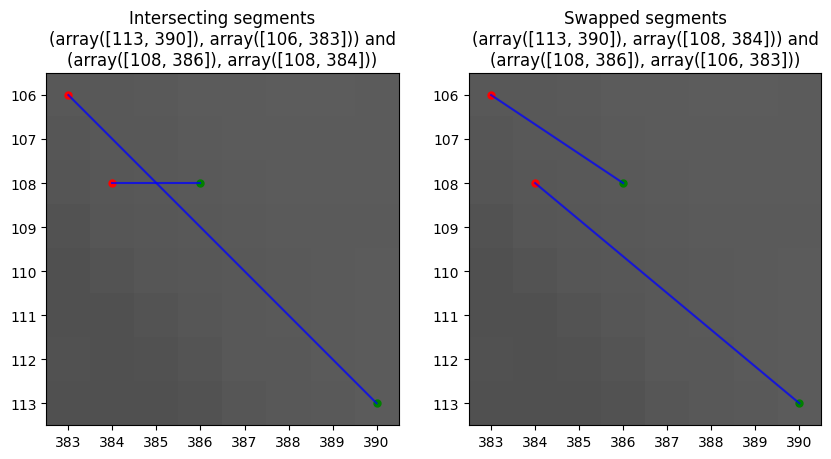

Segment (array([113, 390]), array([106, 383])) intersects with segment (array([109, 387]), array([110, 386]))


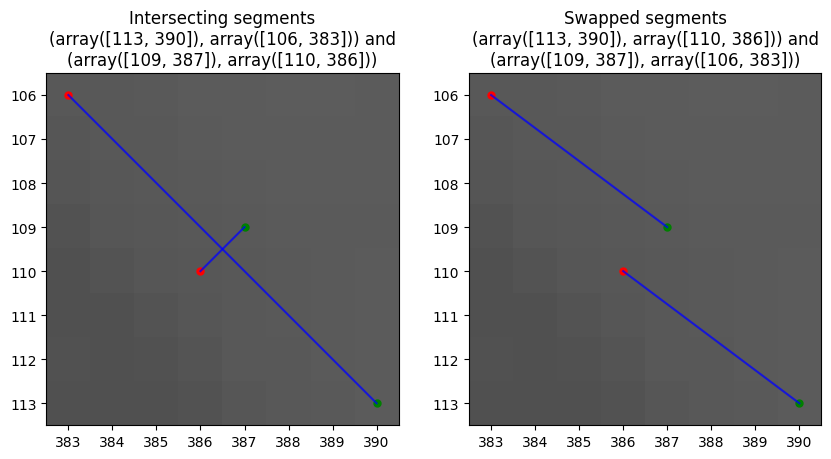

Segment (array([113, 390]), array([106, 383])) intersects with segment (array([110, 388]), array([111, 387]))


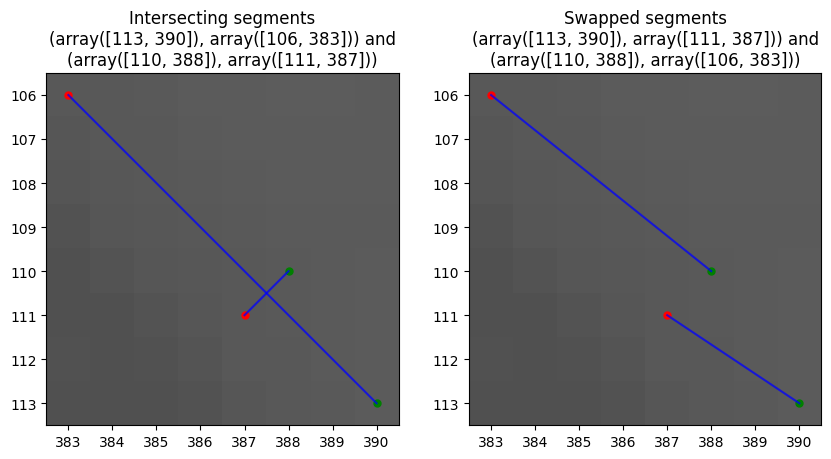

Segment (array([113, 390]), array([106, 383])) intersects with segment (array([112, 389]), array([112, 387]))


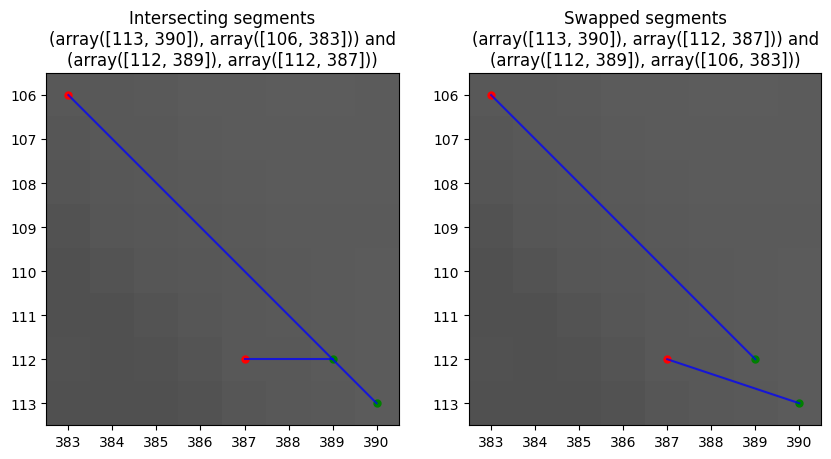

Segment (array([108, 230]), array([107, 229])) intersects with segment (array([106, 229]), array([110, 231]))


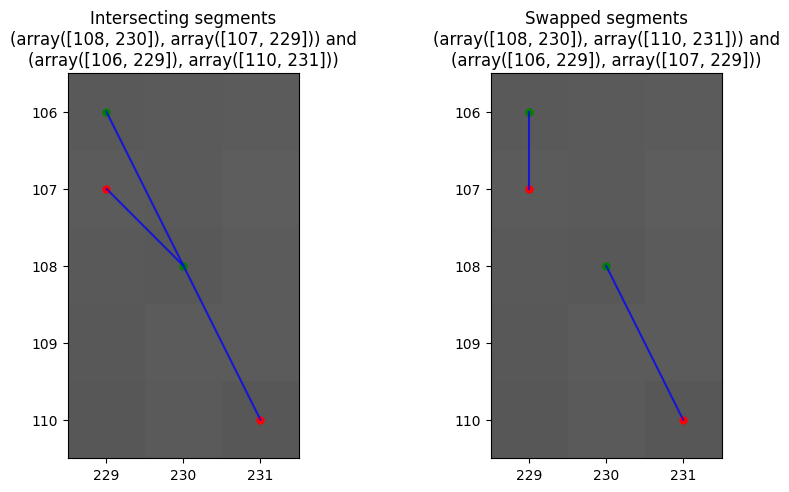

Segment (array([114,  30]), array([112,  30])) intersects with segment (array([113,  31]), array([114,  29]))


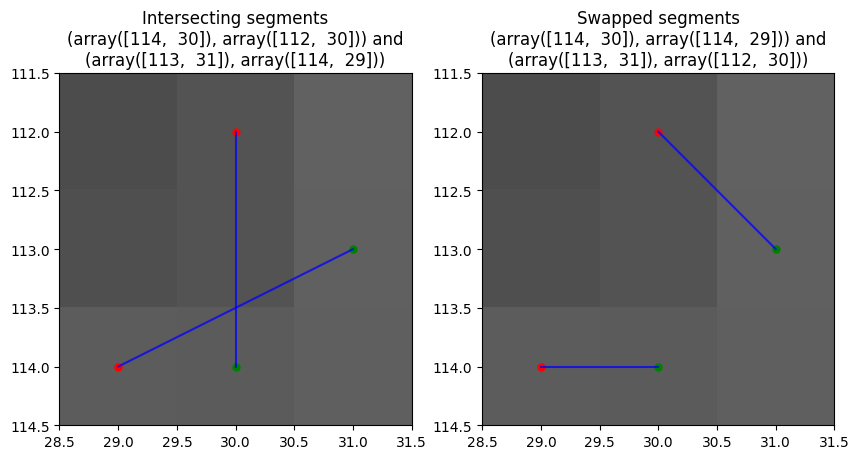

Segment (array([123,  69]), array([114,  75])) intersects with segment (array([116,  74]), array([115,  74]))


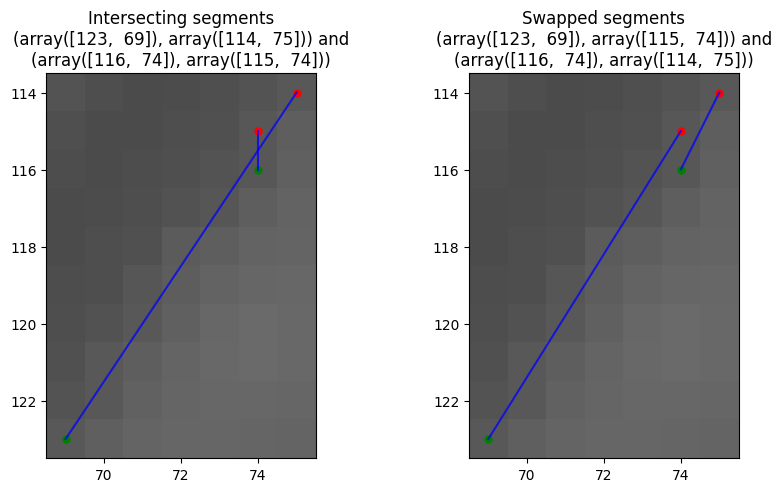

Segment (array([123,  69]), array([114,  75])) intersects with segment (array([117,  73]), array([117,  73]))


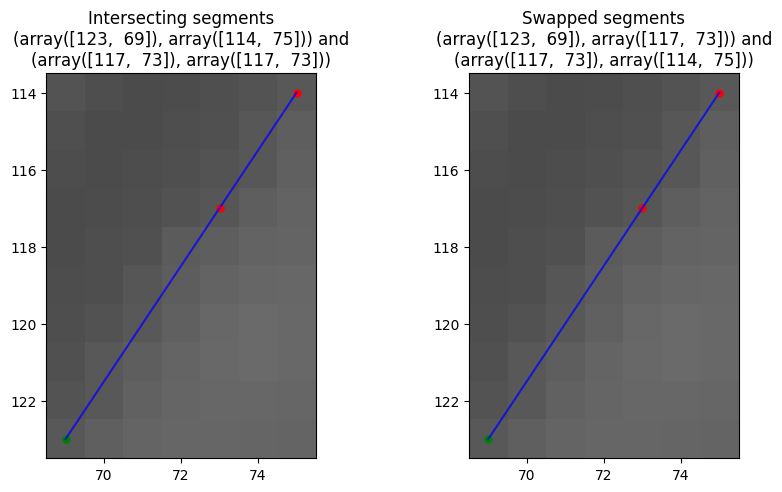

Segment (array([123,  69]), array([114,  75])) intersects with segment (array([118,  73]), array([118,  72]))


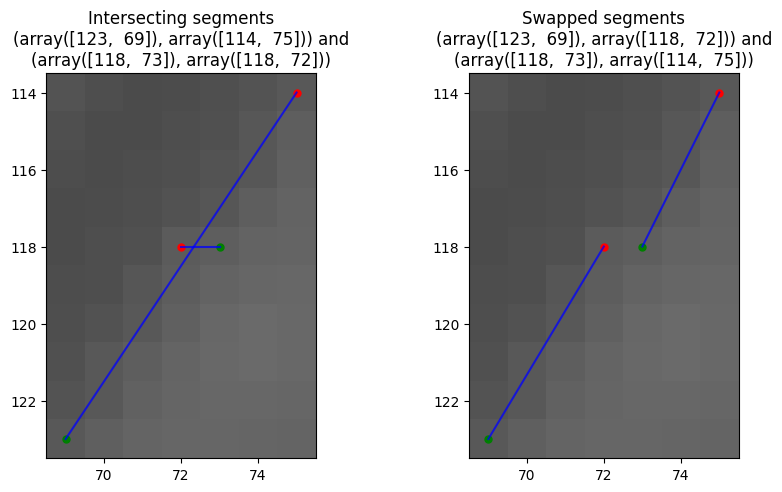

Segment (array([123,  69]), array([114,  75])) intersects with segment (array([120,  71]), array([119,  71]))


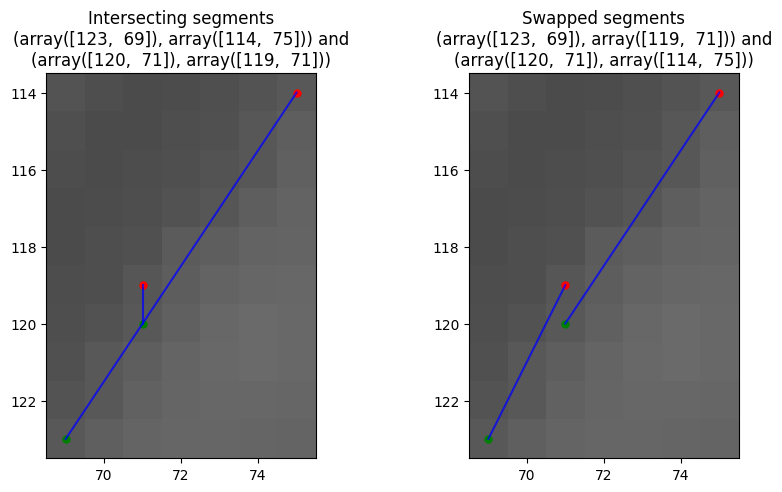

Segment (array([125, 314]), array([116, 313])) intersects with segment (array([126, 314]), array([117, 314]))


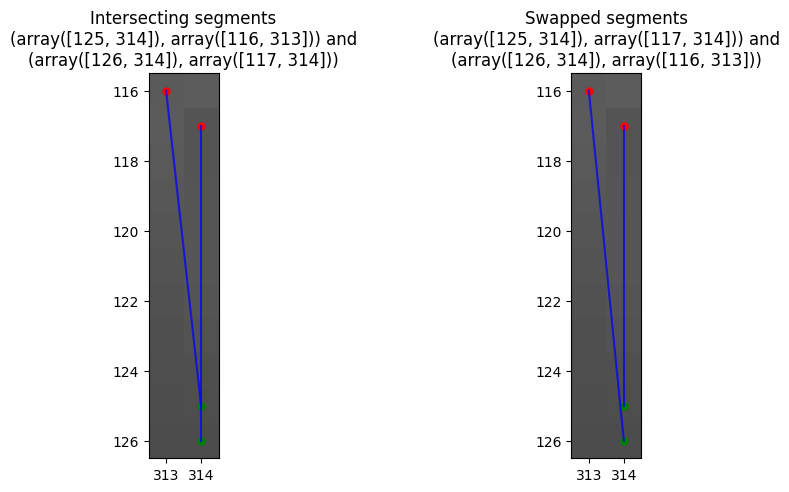

Segment (array([126, 314]), array([117, 314])) intersects with segment (array([127, 315]), array([119, 314]))


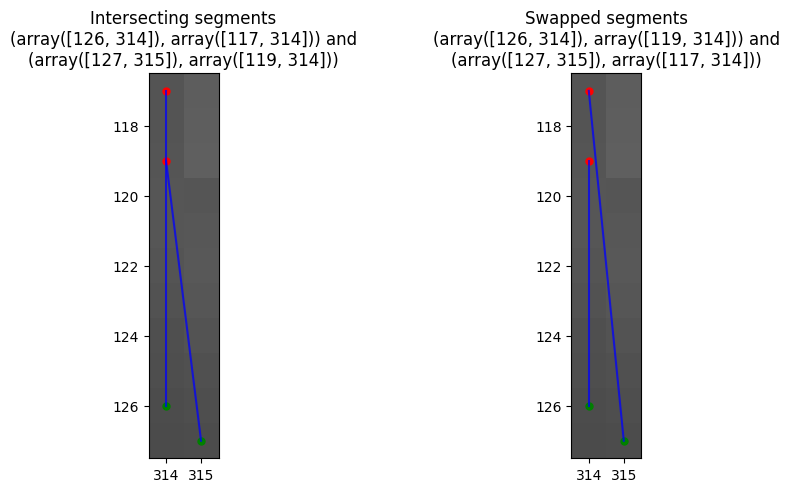

Segment (array([127, 139]), array([118, 141])) intersects with segment (array([125, 140]), array([124, 136]))


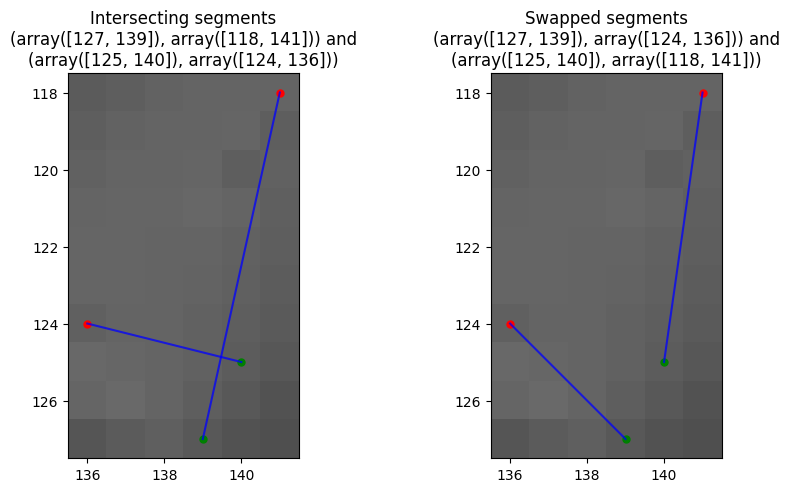

Segment (array([128, 139]), array([119, 141])) intersects with segment (array([125, 140]), array([124, 136]))


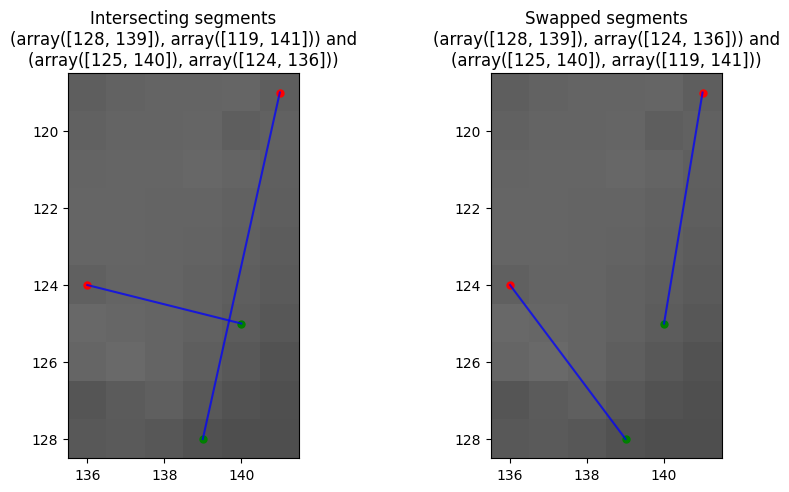

Segment (array([127,  57]), array([125,  60])) intersects with segment (array([126,  58]), array([128,  59]))


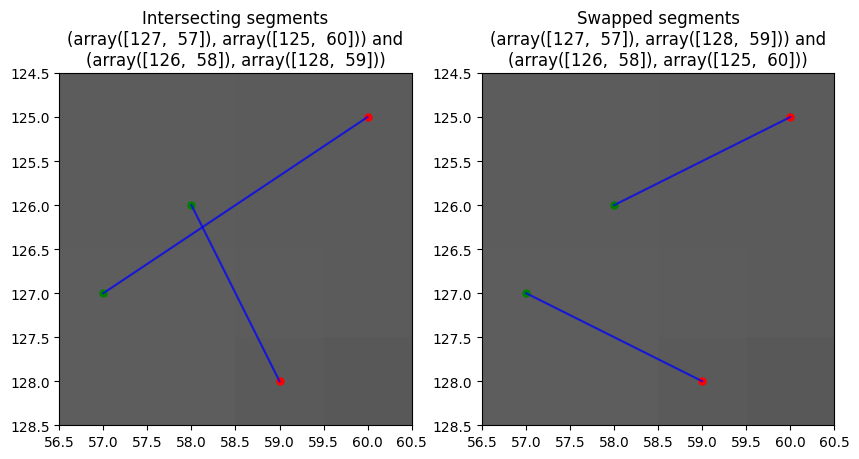

Segment (array([135, 149]), array([128, 150])) intersects with segment (array([134, 148]), array([130, 152]))


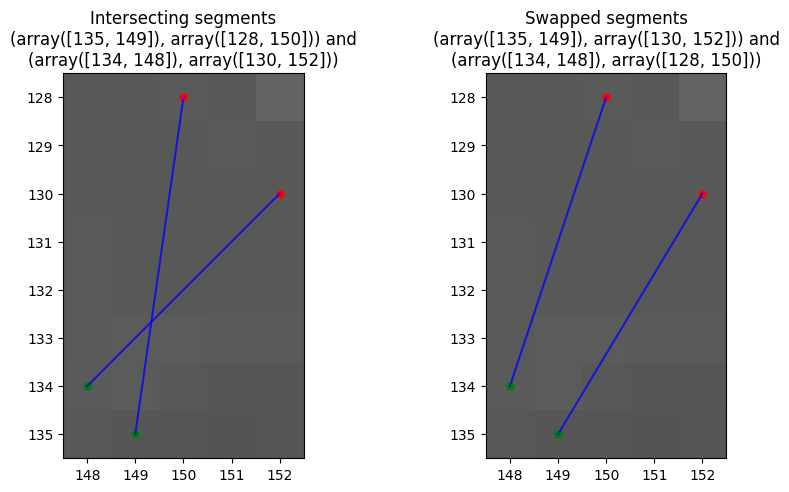

Segment (array([133, 301]), array([128, 305])) intersects with segment (array([132, 302]), array([129, 304]))


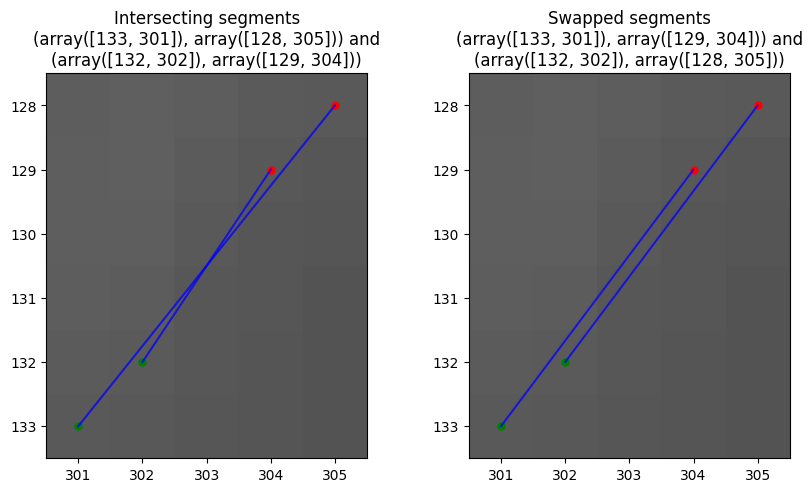

Segment (array([133, 301]), array([128, 305])) intersects with segment (array([130, 303]), array([131, 303]))


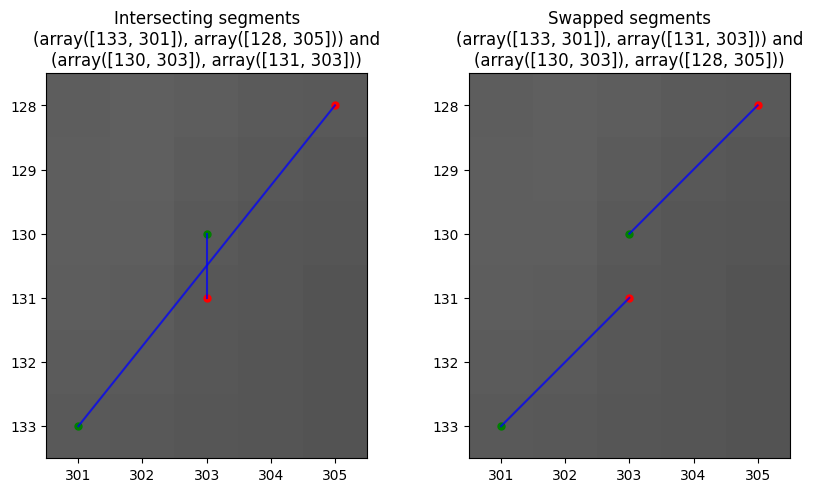

Segment (array([129, 399]), array([128, 396])) intersects with segment (array([128, 398]), array([129, 397]))


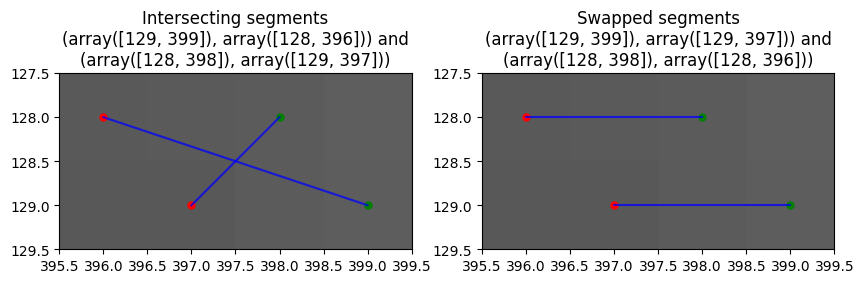

Segment (array([132, 302]), array([129, 304])) intersects with segment (array([130, 303]), array([131, 303]))


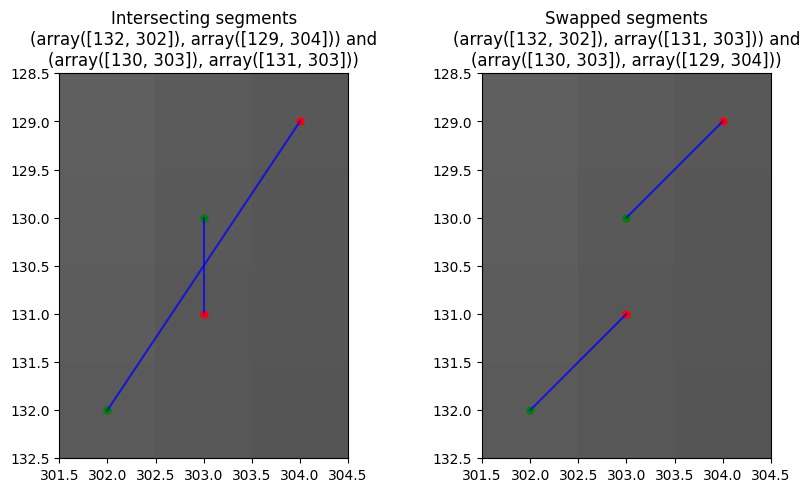

Segment (array([139, 295]), array([137, 299])) intersects with segment (array([138, 295]), array([144, 296]))


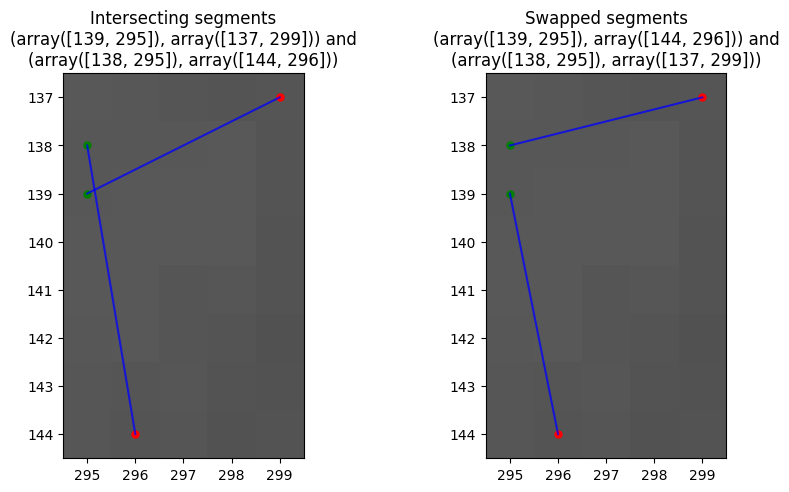

Segment (array([141, 249]), array([138, 248])) intersects with segment (array([142, 248]), array([138, 249]))


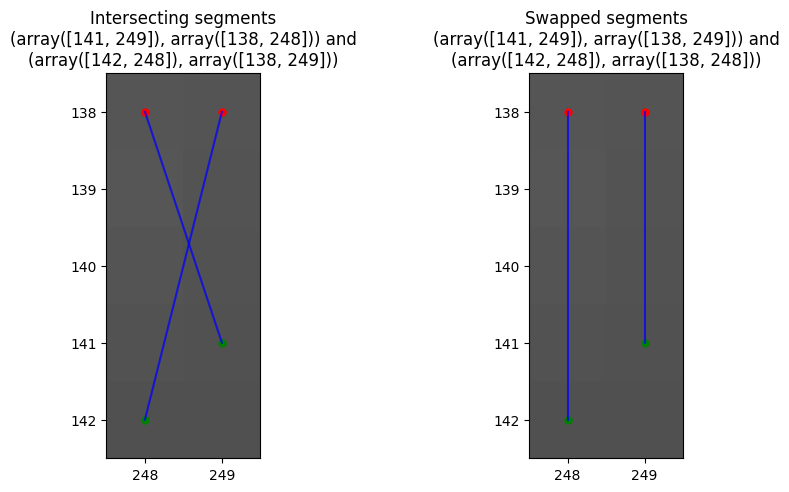

Segment (array([140, 294]), array([138, 298])) intersects with segment (array([138, 295]), array([144, 296]))


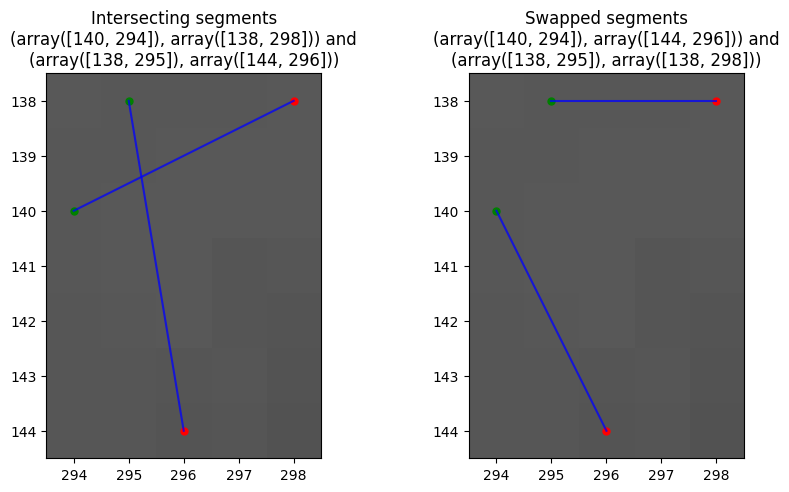

Segment (array([143, 203]), array([139, 203])) intersects with segment (array([144, 202]), array([140, 203]))


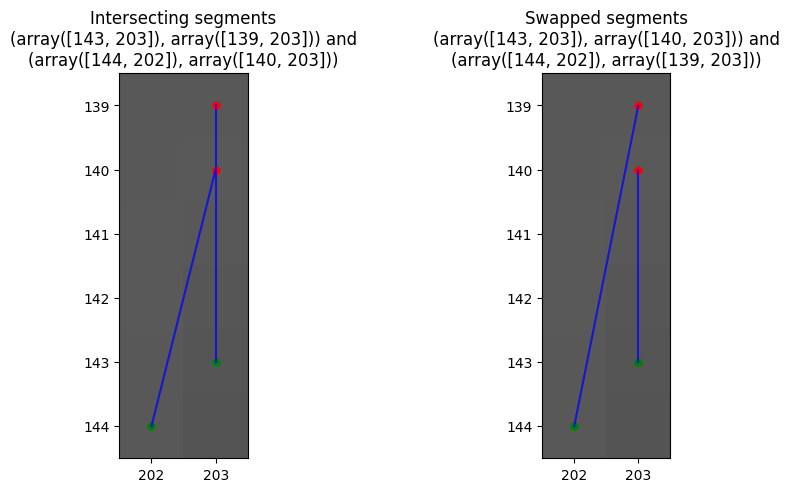

Segment (array([147, 211]), array([141, 209])) intersects with segment (array([149, 212]), array([143, 209]))


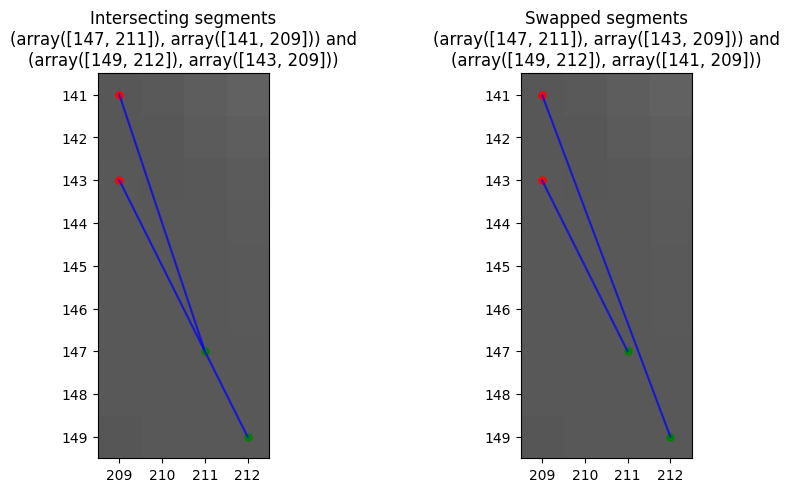

Segment (array([146,  51]), array([142,  55])) intersects with segment (array([143,  52]), array([143,  55]))


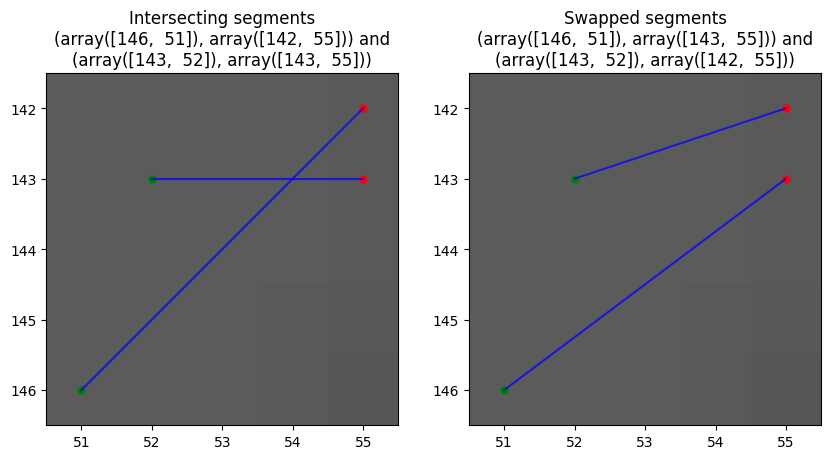

Segment (array([148, 137]), array([142, 139])) intersects with segment (array([150, 136]), array([143, 139]))


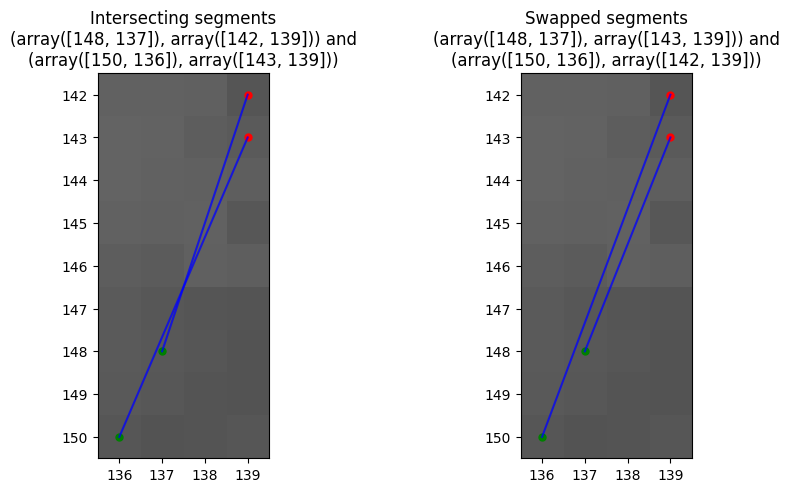

Segment (array([148, 137]), array([142, 139])) intersects with segment (array([144, 137]), array([144, 139]))


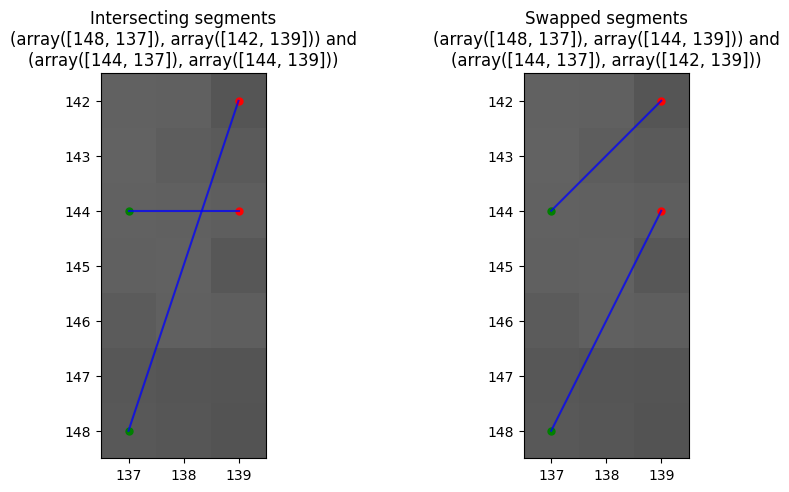

Segment (array([148, 137]), array([142, 139])) intersects with segment (array([142, 137]), array([145, 139]))


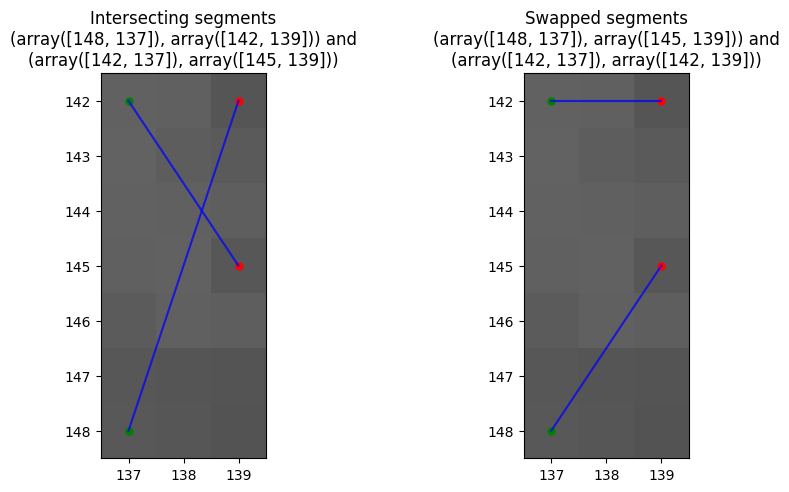

Segment (array([148, 137]), array([142, 139])) intersects with segment (array([140, 136]), array([146, 139]))


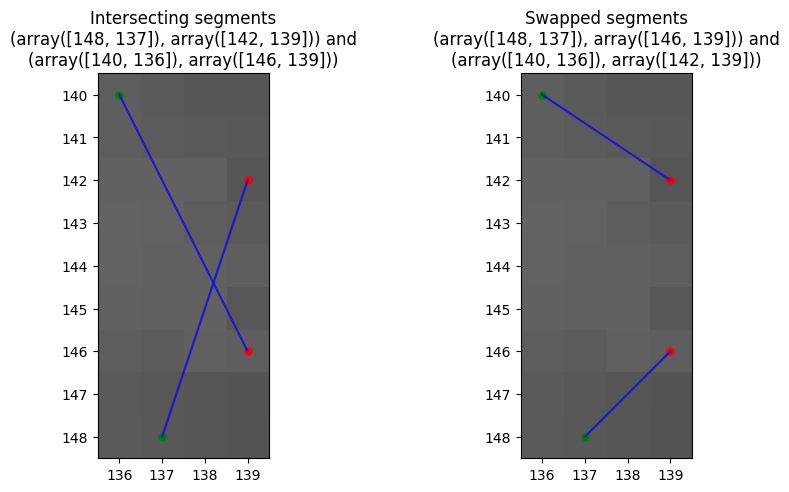

Segment (array([148, 211]), array([142, 209])) intersects with segment (array([149, 212]), array([143, 209]))


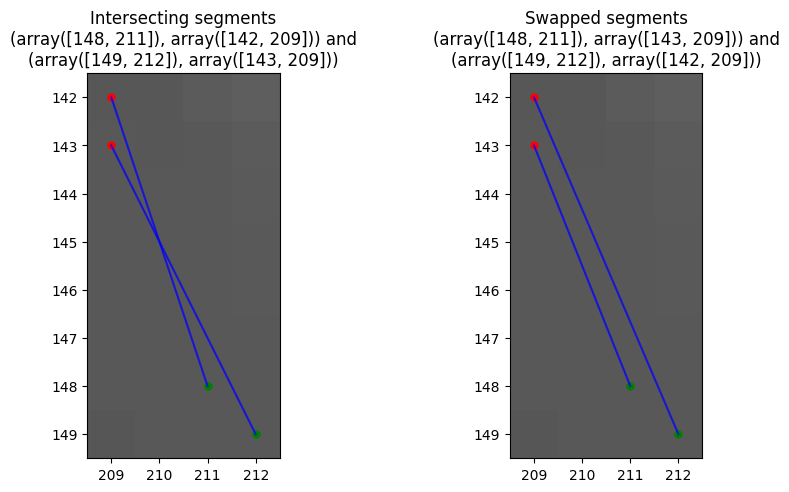

Segment (array([150, 136]), array([143, 139])) intersects with segment (array([144, 137]), array([144, 139]))


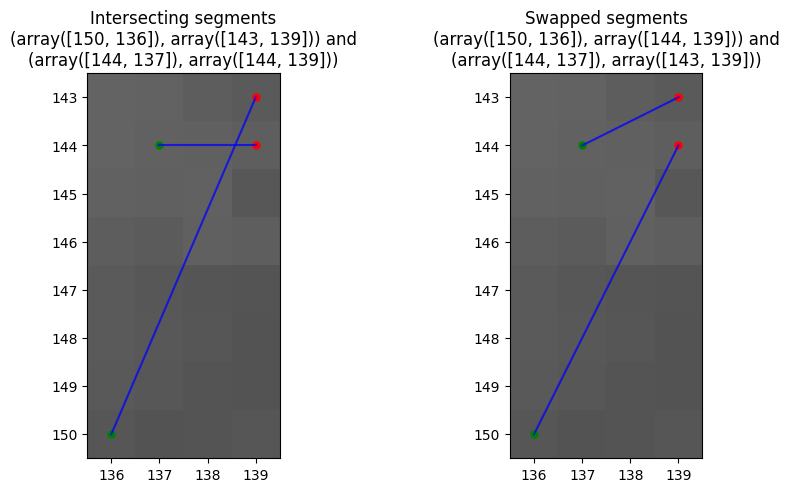

Segment (array([150, 136]), array([143, 139])) intersects with segment (array([142, 137]), array([145, 139]))


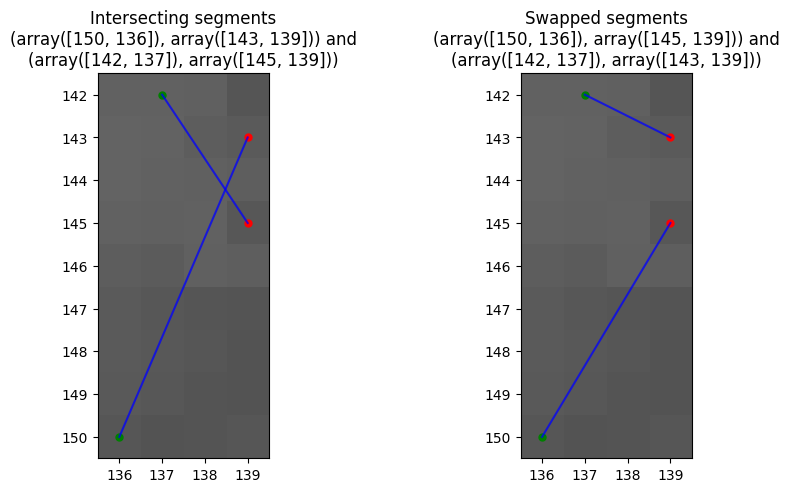

Segment (array([150, 136]), array([143, 139])) intersects with segment (array([140, 136]), array([146, 139]))


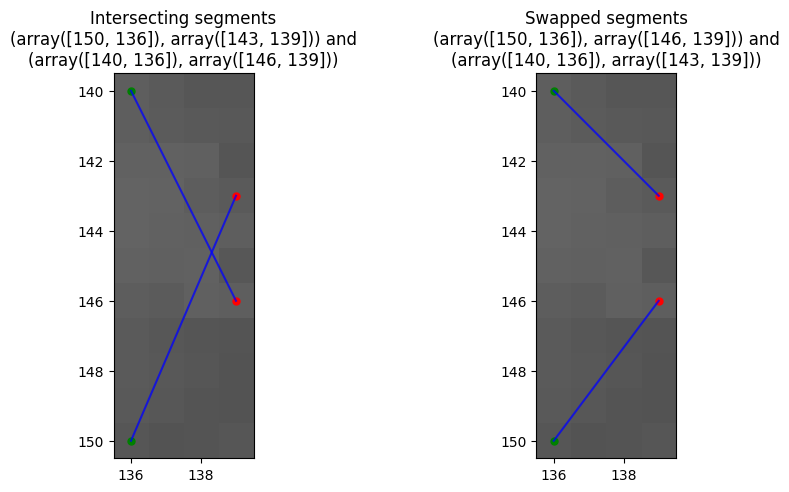

Segment (array([143, 293]), array([143, 296])) intersects with segment (array([138, 295]), array([144, 296]))


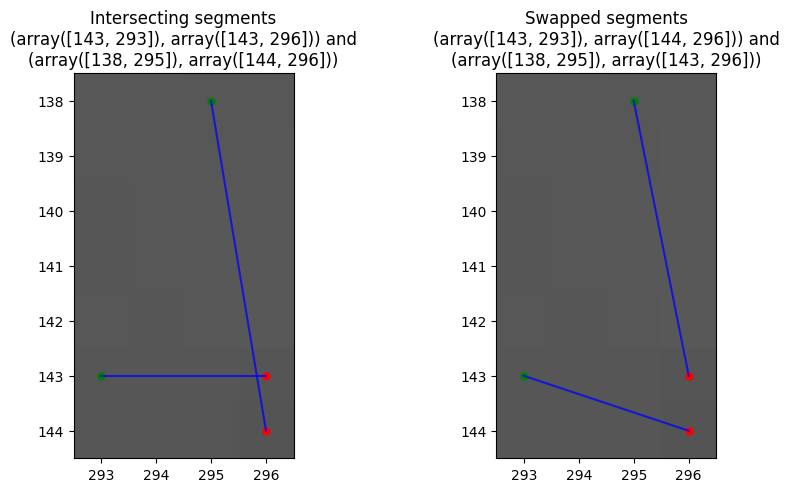

Segment (array([144, 137]), array([144, 139])) intersects with segment (array([142, 137]), array([145, 139]))


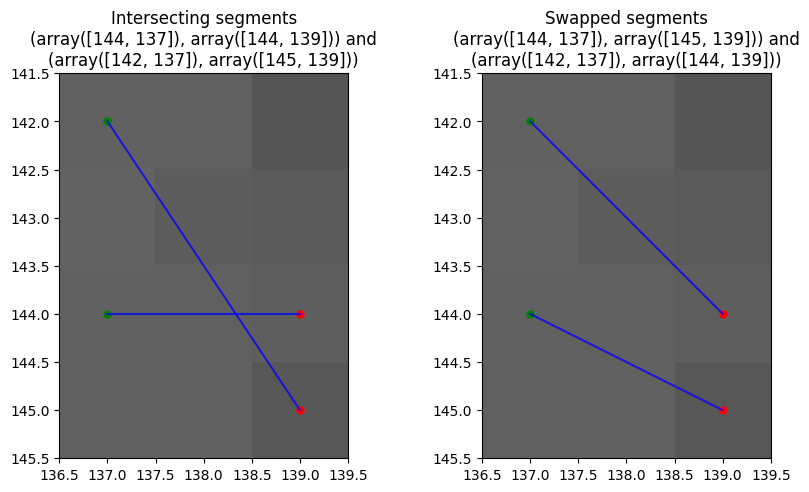

Segment (array([144, 137]), array([144, 139])) intersects with segment (array([140, 136]), array([146, 139]))


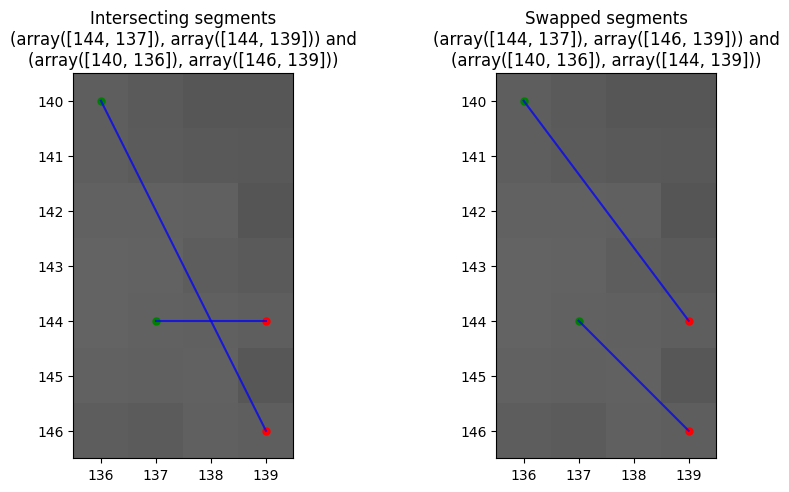

Segment (array([145, 405]), array([144, 401])) intersects with segment (array([144, 405]), array([145, 401]))


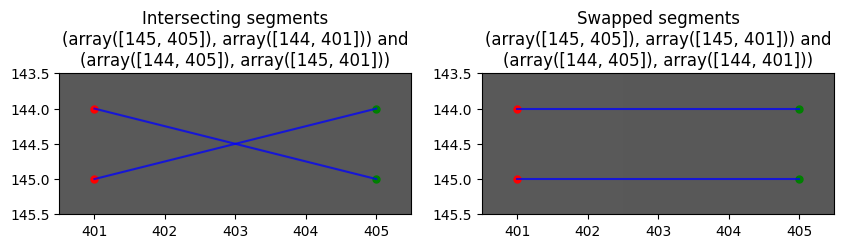

Segment (array([152,  57]), array([145,  61])) intersects with segment (array([149,  58]), array([148,  61]))


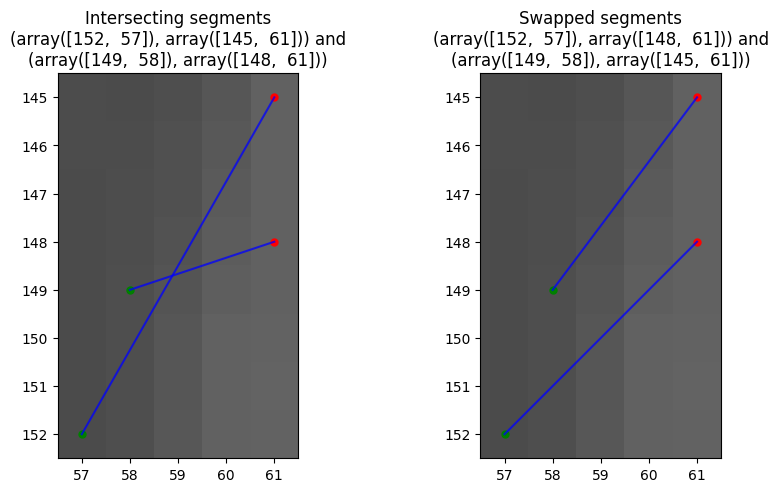

Segment (array([142, 137]), array([145, 139])) intersects with segment (array([140, 136]), array([146, 139]))


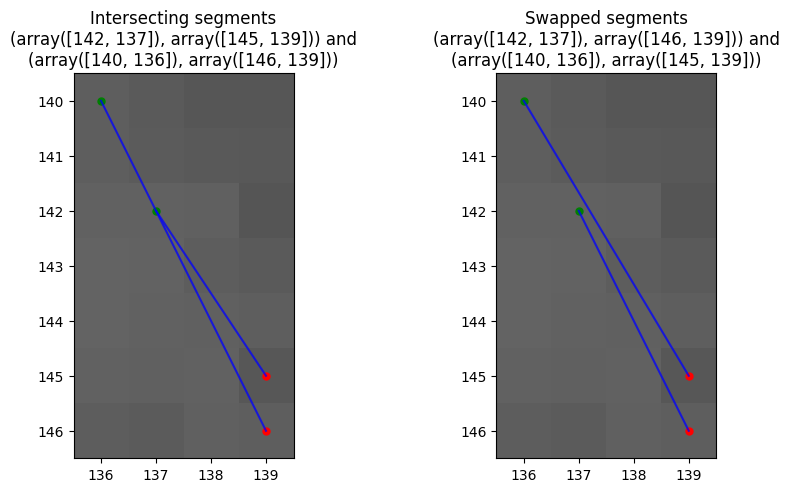

Segment (array([146, 396]), array([145, 395])) intersects with segment (array([145, 396]), array([147, 395]))


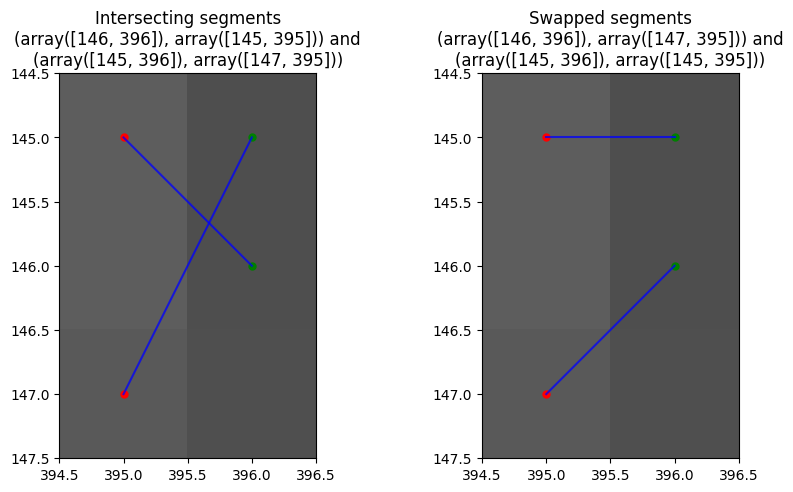

Segment (array([150, 397]), array([148, 395])) intersects with segment (array([149, 397]), array([153, 395]))


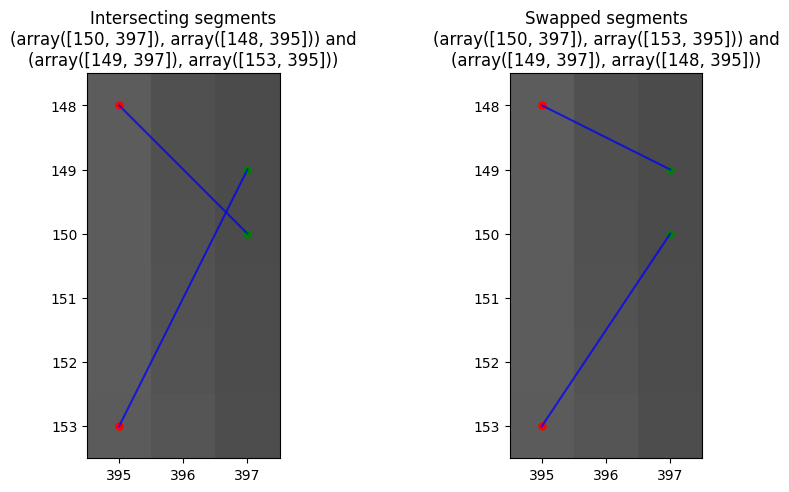

Segment (array([151, 238]), array([149, 247])) intersects with segment (array([146, 242]), array([150, 246]))


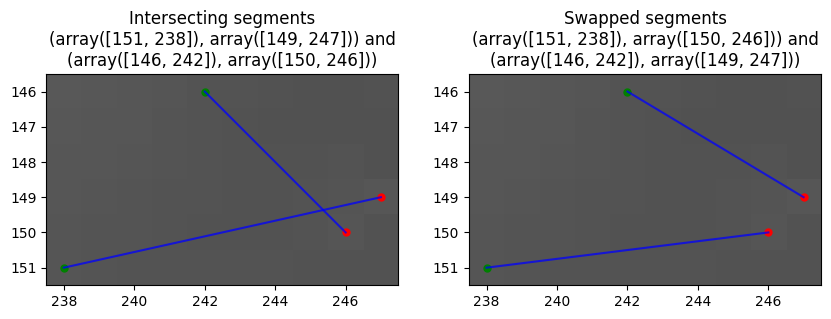

Segment (array([156,  24]), array([150,  24])) intersects with segment (array([154,  24]), array([154,  25]))


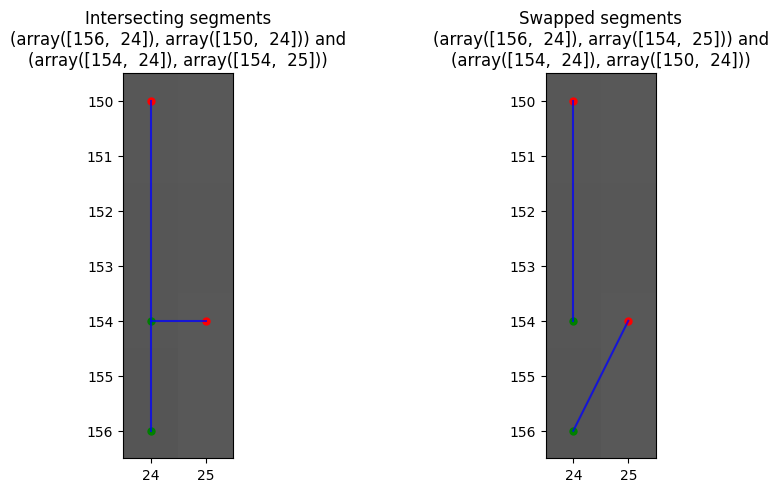

Segment (array([156,  24]), array([150,  24])) intersects with segment (array([155,  24]), array([155,  25]))


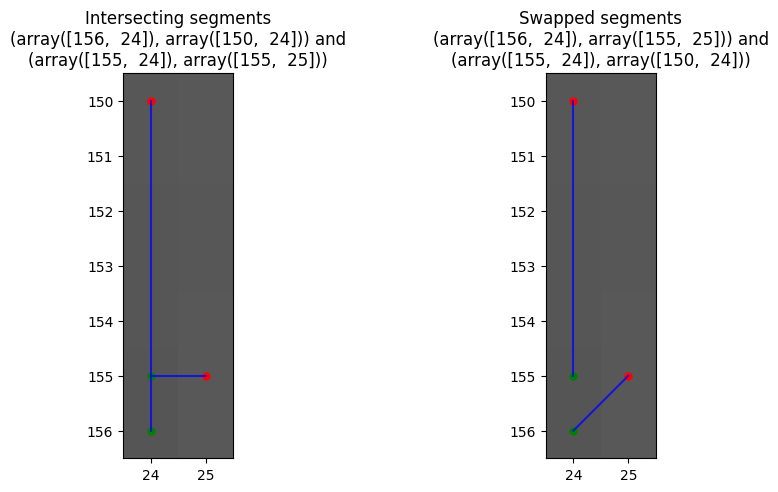

Segment (array([154, 216]), array([151, 210])) intersects with segment (array([152, 213]), array([152, 212]))


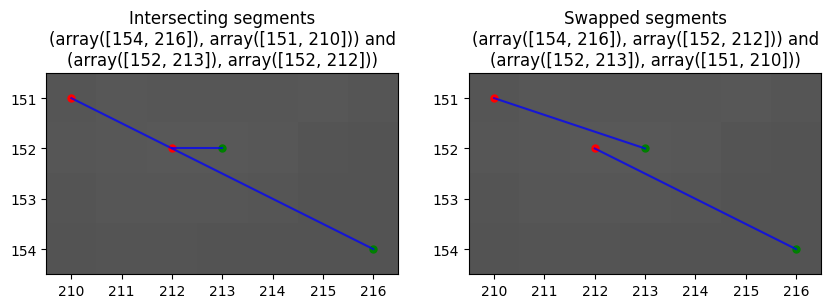

Segment (array([151, 397]), array([151, 395])) intersects with segment (array([149, 397]), array([153, 395]))


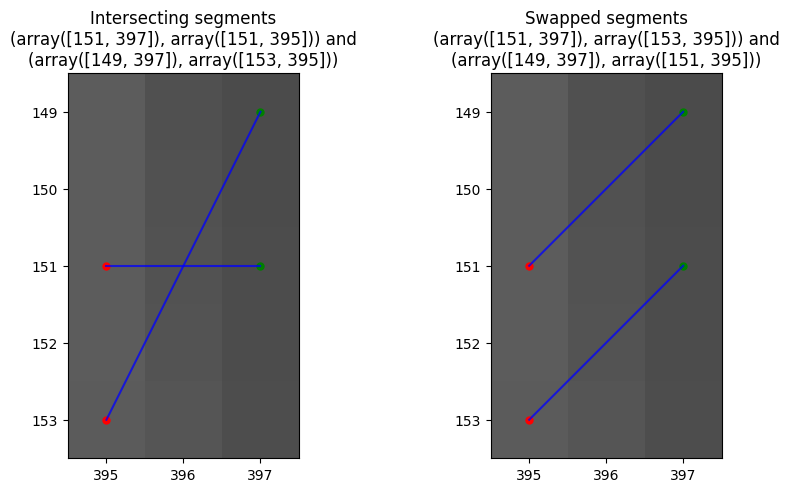

Segment (array([152, 397]), array([152, 395])) intersects with segment (array([149, 397]), array([153, 395]))


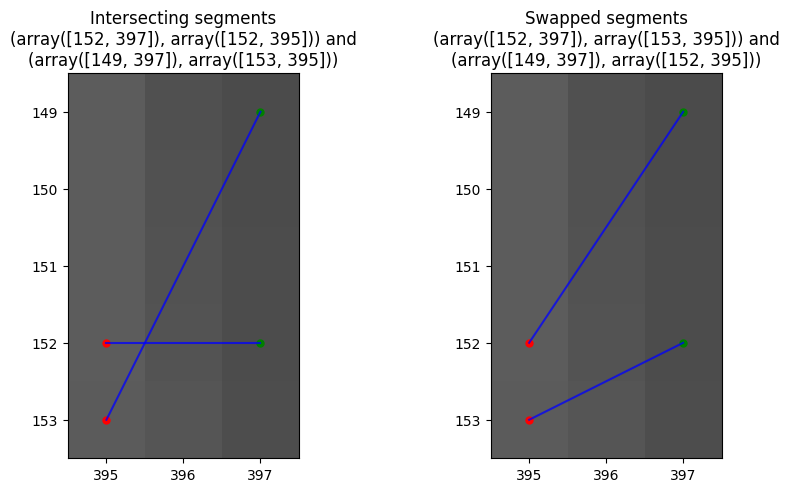

Segment (array([158, 429]), array([153, 431])) intersects with segment (array([155, 430]), array([156, 431]))


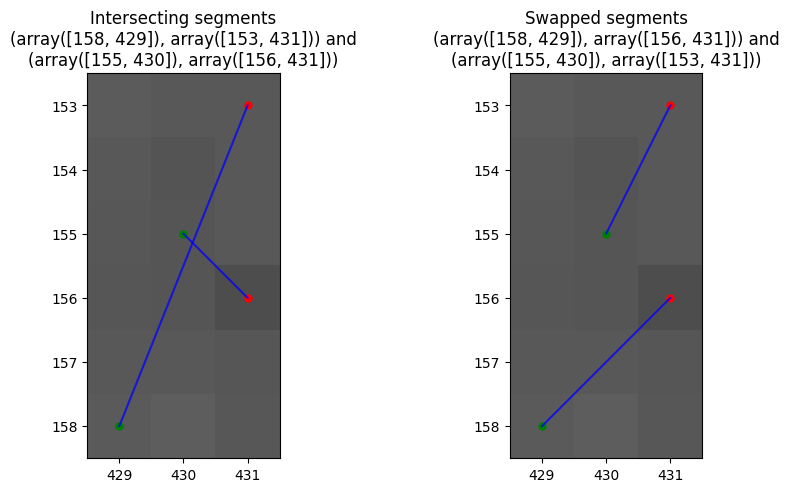

Segment (array([158, 429]), array([153, 431])) intersects with segment (array([157, 429]), array([157, 431]))


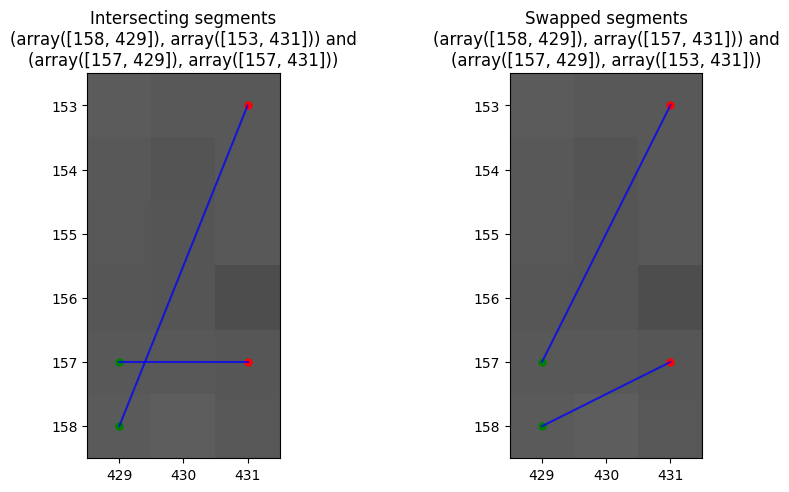

Segment (array([165, 397]), array([161, 396])) intersects with segment (array([164, 397]), array([165, 395]))


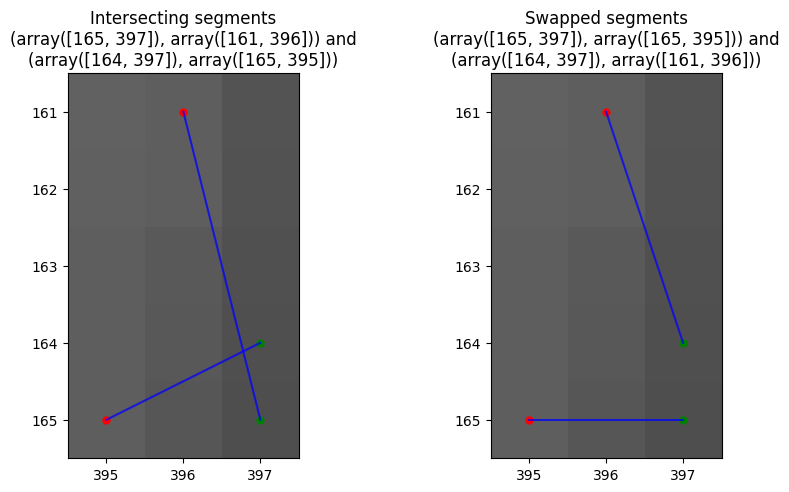

Segment (array([165,  57]), array([162,  60])) intersects with segment (array([164,  57]), array([165,  60]))


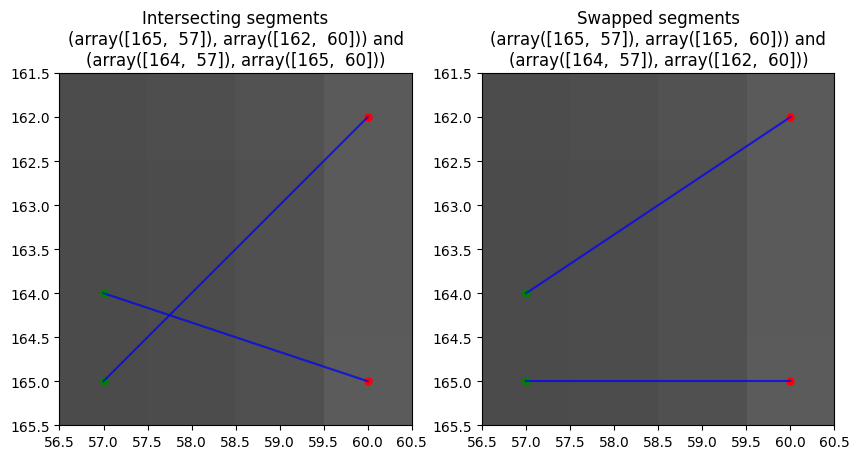

Segment (array([161, 131]), array([162, 128])) intersects with segment (array([161, 129]), array([162, 130]))


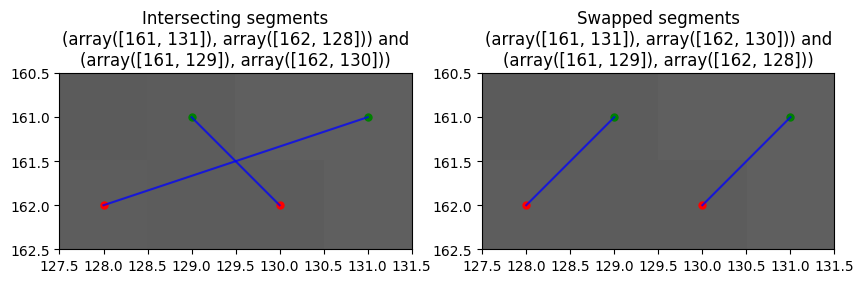

Segment (array([161, 131]), array([162, 128])) intersects with segment (array([160, 128]), array([163, 131]))


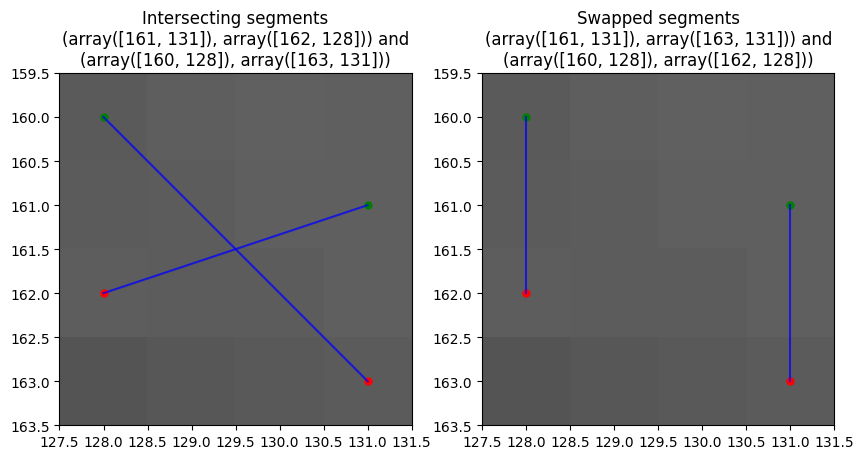

Segment (array([161, 129]), array([162, 130])) intersects with segment (array([160, 128]), array([163, 131]))


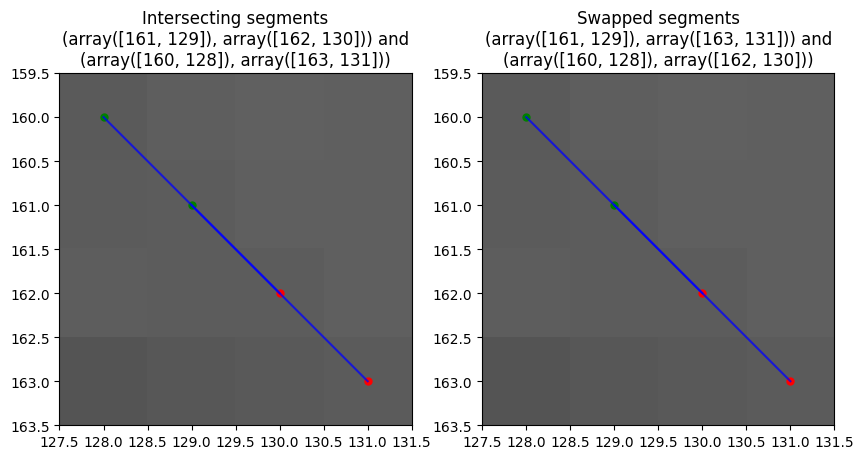

Segment (array([160, 326]), array([163, 324])) intersects with segment (array([161, 325]), array([164, 330]))


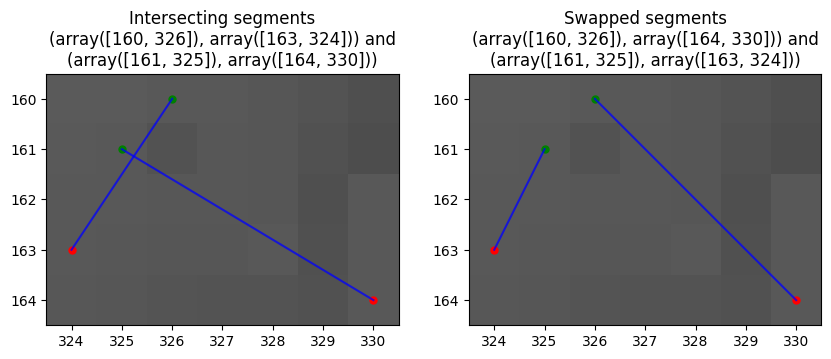

Segment (array([167,  50]), array([164,  54])) intersects with segment (array([166,  50]), array([169,  54]))


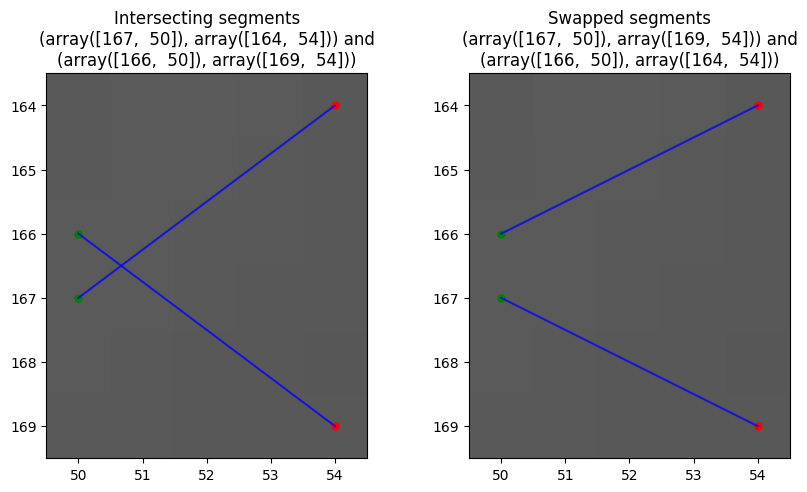

Segment (array([171, 128]), array([166, 126])) intersects with segment (array([168, 126]), array([167, 127]))


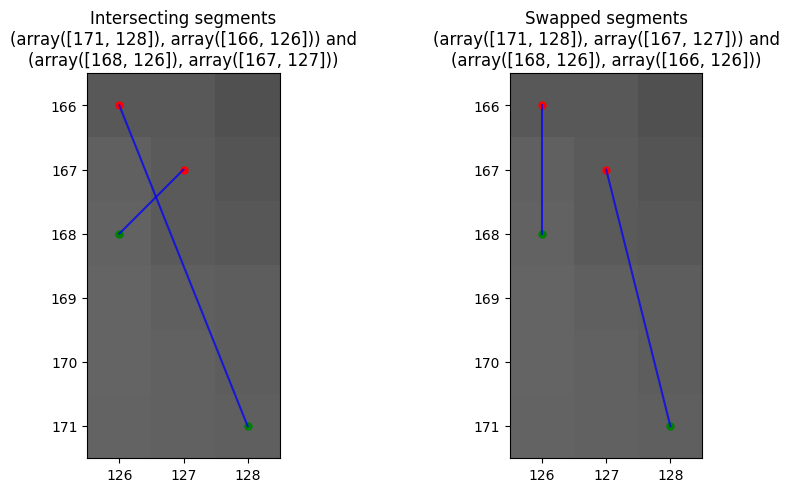

Segment (array([171, 128]), array([166, 126])) intersects with segment (array([170, 127]), array([169, 128]))


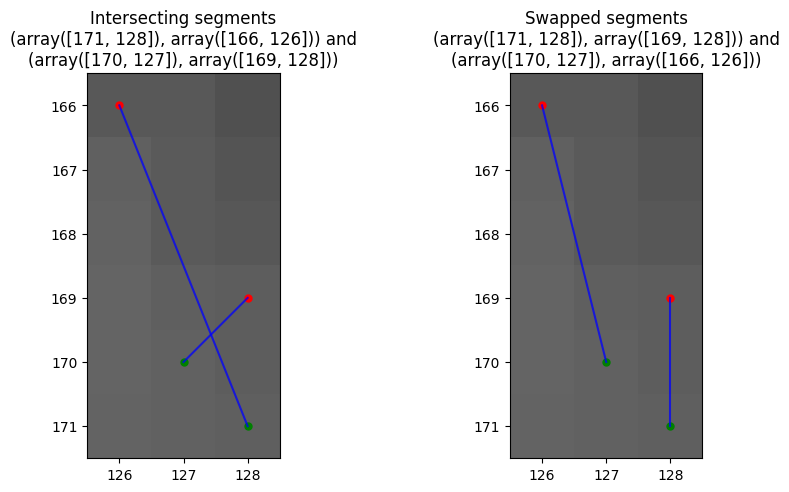

Segment (array([169, 396]), array([167, 395])) intersects with segment (array([168, 396]), array([169, 395]))


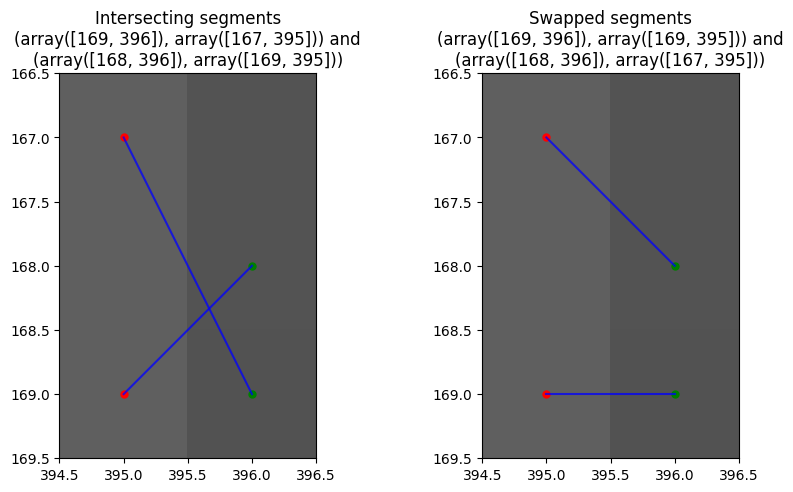

Segment (array([168,  50]), array([168,  54])) intersects with segment (array([166,  50]), array([169,  54]))


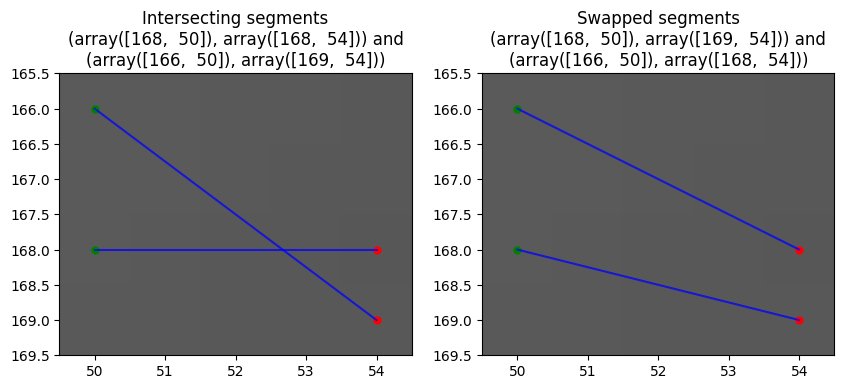

Segment (array([171, 201]), array([168, 200])) intersects with segment (array([169, 202]), array([169, 199]))


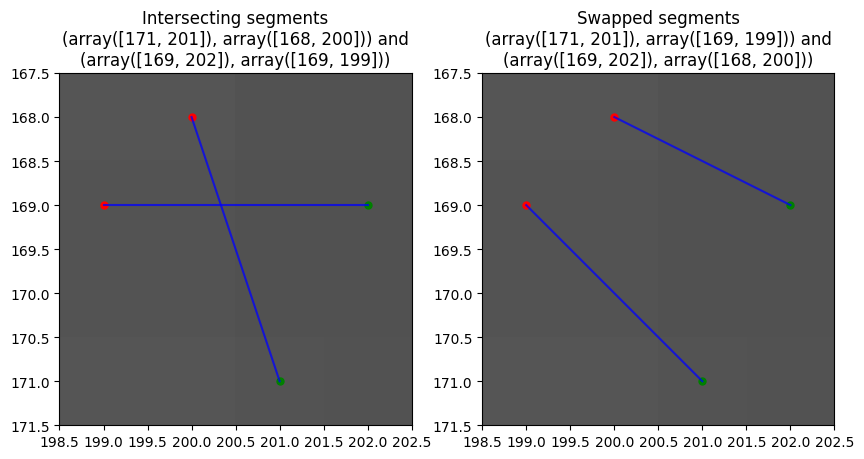

Segment (array([171, 201]), array([168, 200])) intersects with segment (array([170, 202]), array([170, 199]))


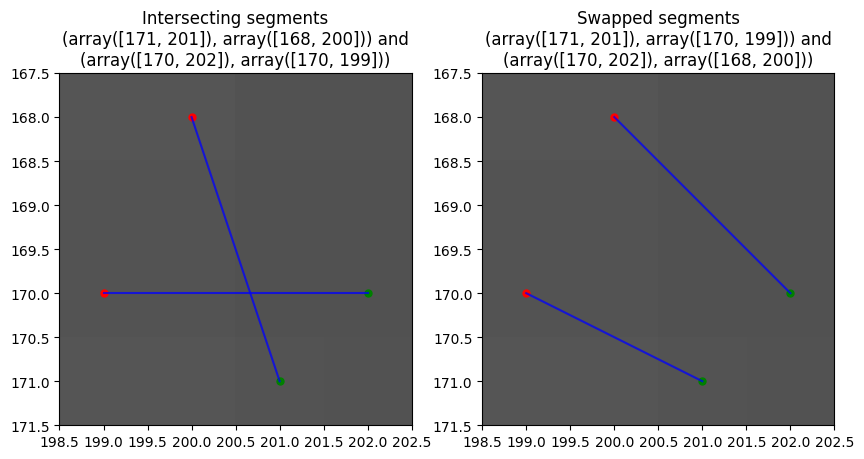

Segment (array([173, 240]), array([168, 243])) intersects with segment (array([174, 240]), array([169, 242]))


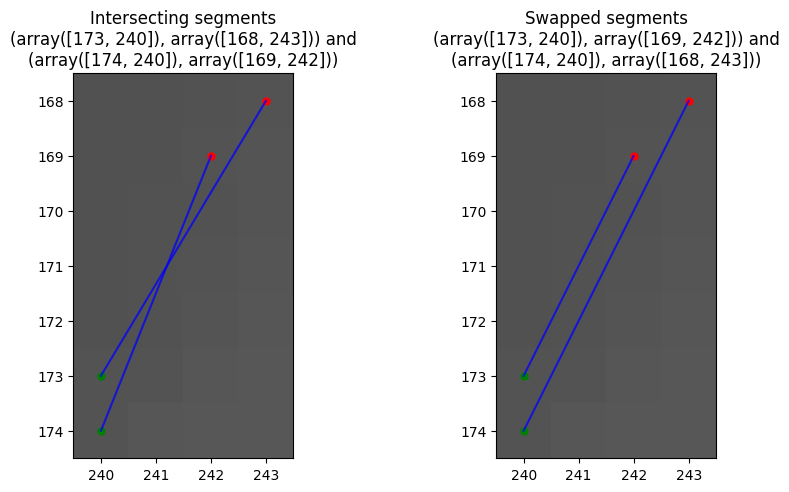

Segment (array([172, 258]), array([168, 256])) intersects with segment (array([174, 259]), array([170, 257]))


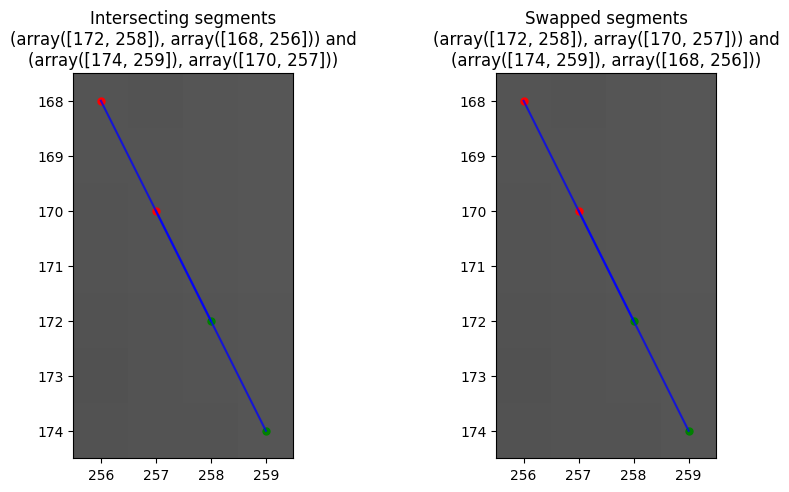

Segment (array([171,  58]), array([169,  61])) intersects with segment (array([170,  58]), array([172,  61]))


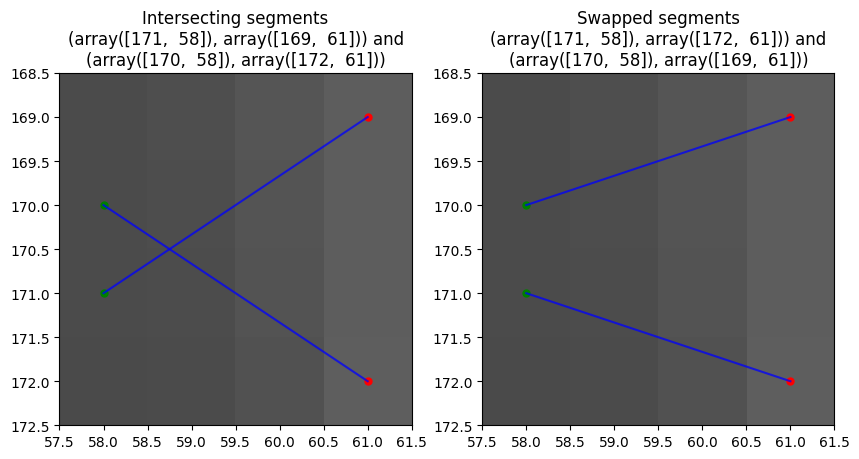

Segment (array([174, 240]), array([169, 242])) intersects with segment (array([175, 239]), array([170, 242]))


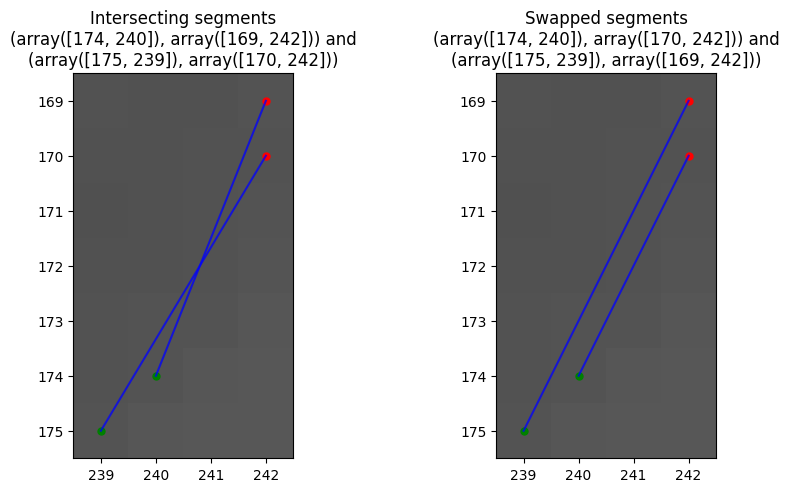

Segment (array([173,  50]), array([170,  54])) intersects with segment (array([172,  50]), array([173,  55]))


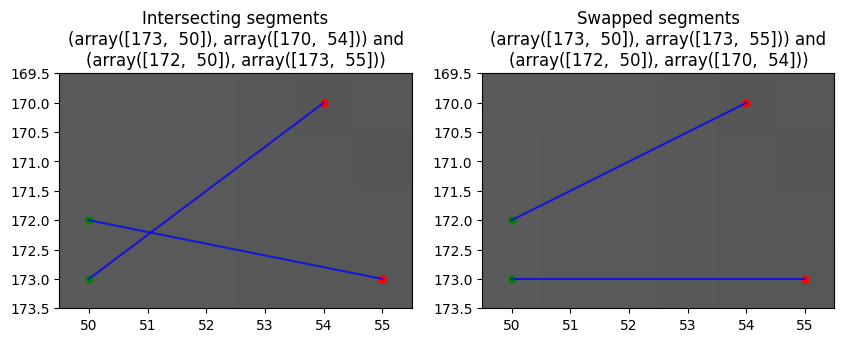

Segment (array([175, 239]), array([170, 242])) intersects with segment (array([177, 238]), array([173, 240]))


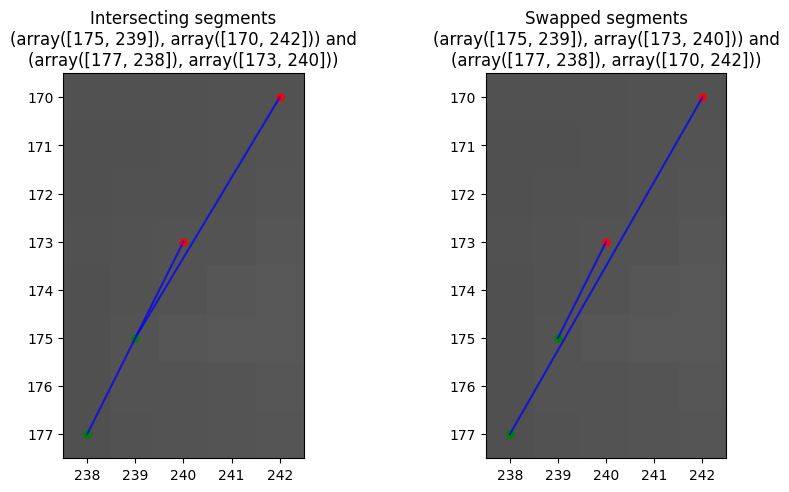

Segment (array([172, 396]), array([170, 395])) intersects with segment (array([171, 396]), array([173, 394]))


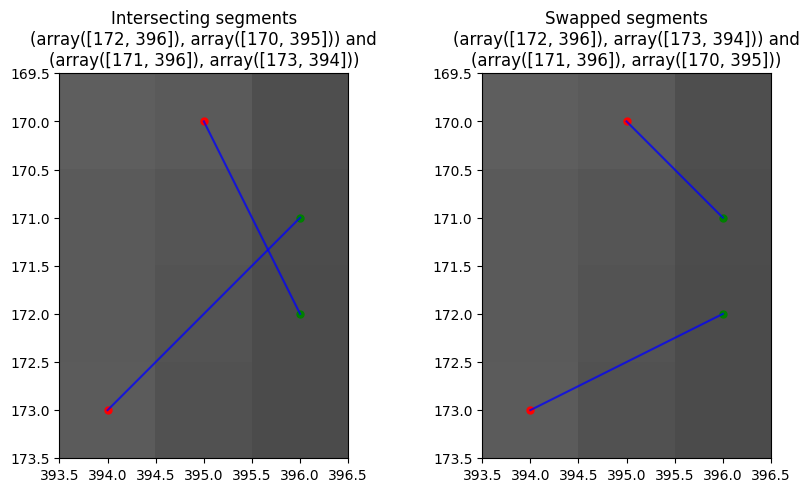

Segment (array([167,  27]), array([171,  31])) intersects with segment (array([166,  27]), array([172,  30]))


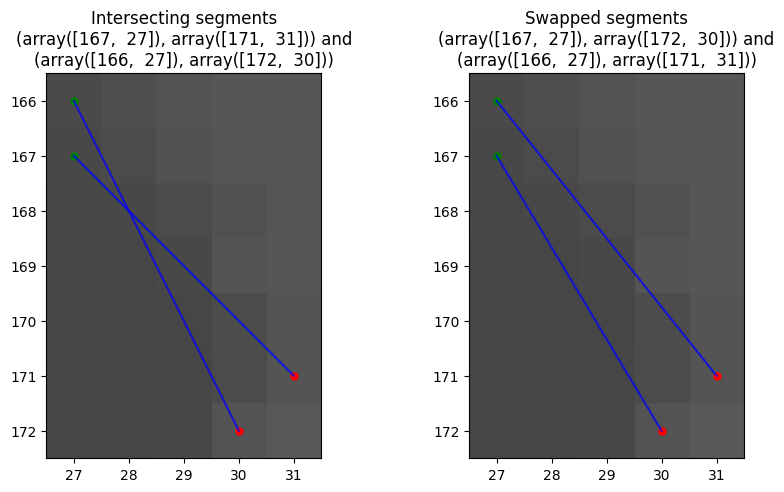

Segment (array([175,  51]), array([172,  55])) intersects with segment (array([172,  50]), array([173,  55]))


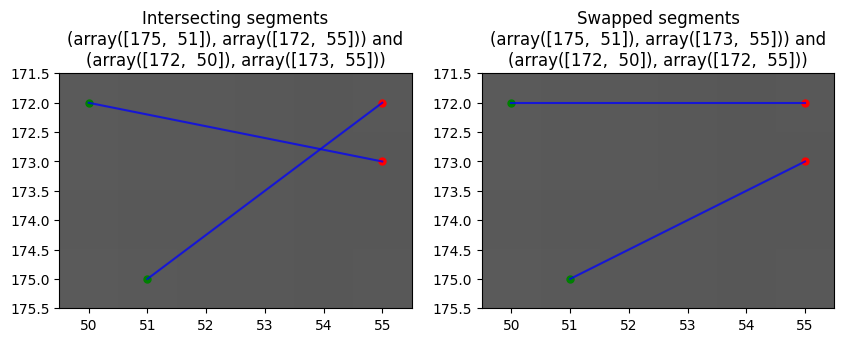

Segment (array([174, 129]), array([172, 129])) intersects with segment (array([173, 128]), array([173, 130]))


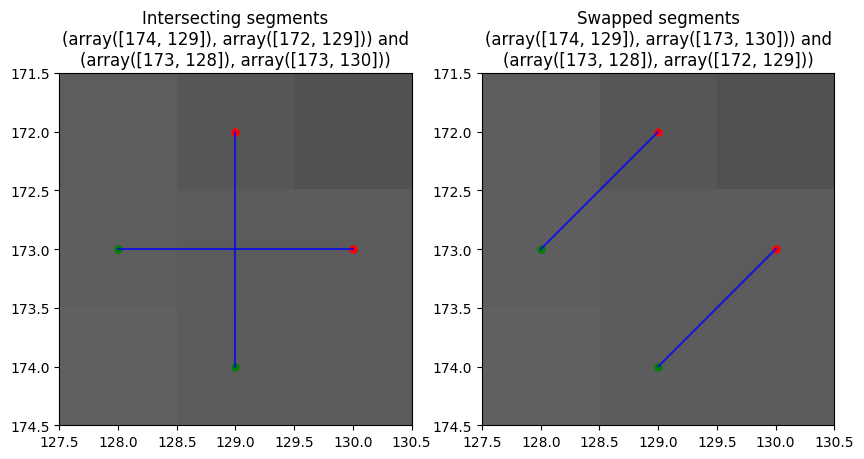

Segment (array([180, 404]), array([173, 401])) intersects with segment (array([176, 404]), array([176, 400]))


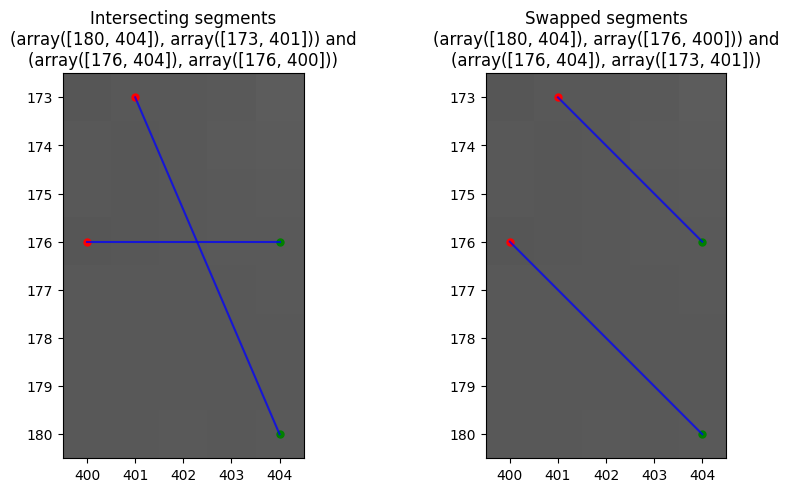

Segment (array([191, 244]), array([183, 244])) intersects with segment (array([190, 243]), array([186, 248]))


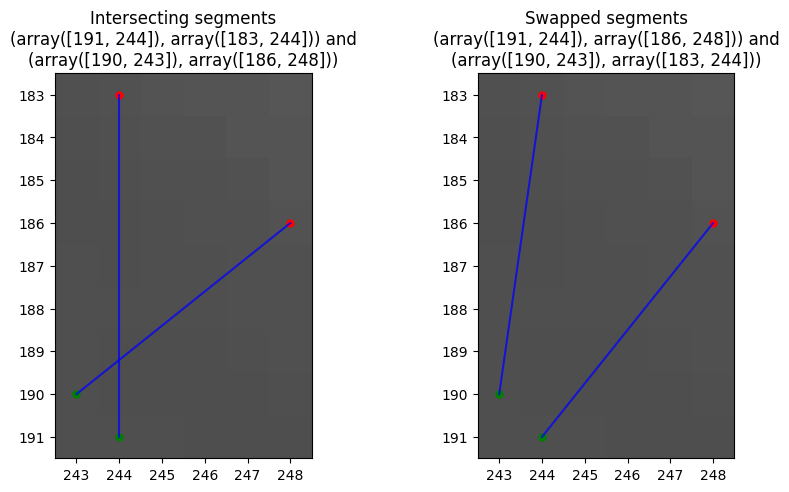

Segment (array([190, 133]), array([187, 134])) intersects with segment (array([189, 133]), array([189, 134]))


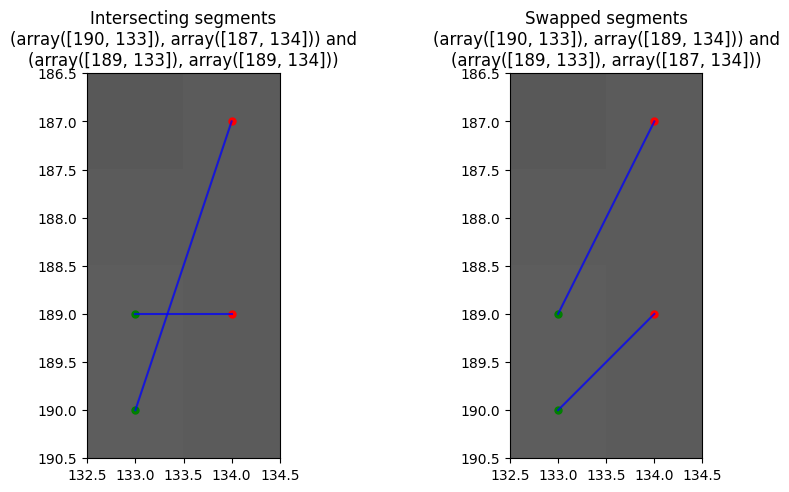

Segment (array([192, 189]), array([190, 183])) intersects with segment (array([192, 188]), array([190, 184]))


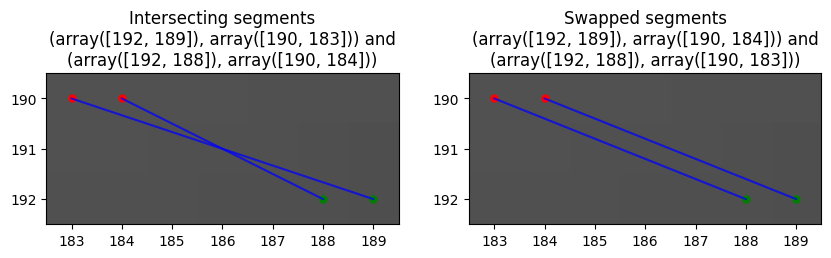

Segment (array([192, 264]), array([190, 272])) intersects with segment (array([190, 270]), array([190, 273]))


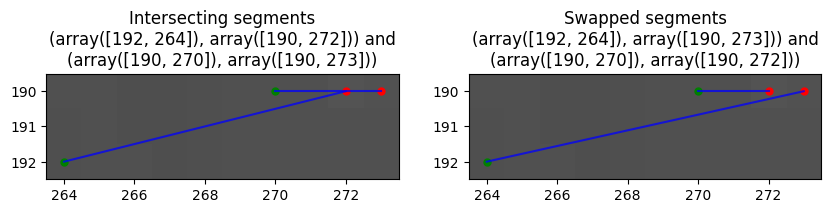

Segment (array([194, 192]), array([193, 186])) intersects with segment (array([193, 191]), array([201, 190]))


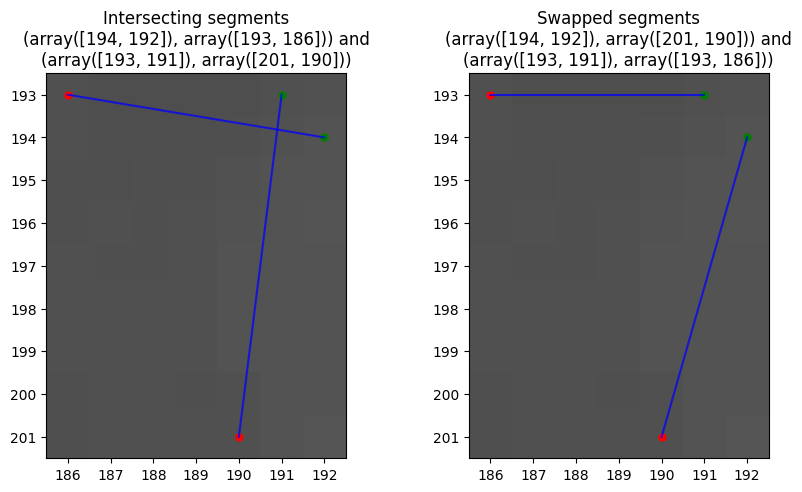

Segment (array([196, 260]), array([194, 257])) intersects with segment (array([195, 259]), array([202, 263]))


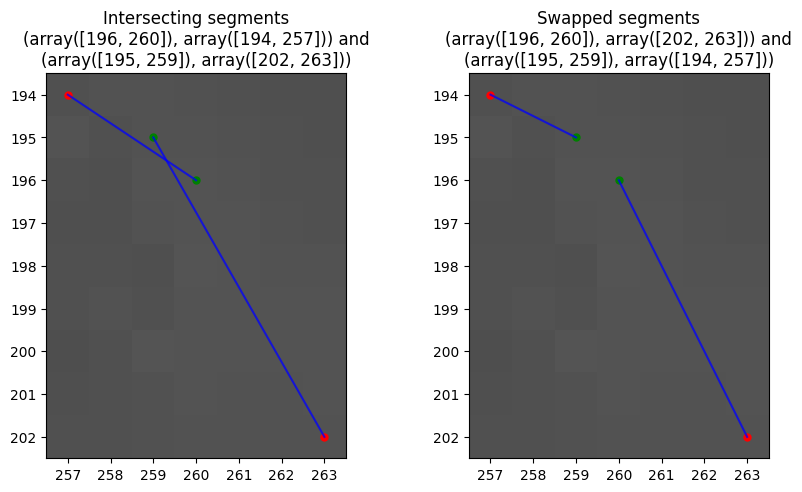

Segment (array([199, 254]), array([196, 258])) intersects with segment (array([198, 254]), array([198, 259]))


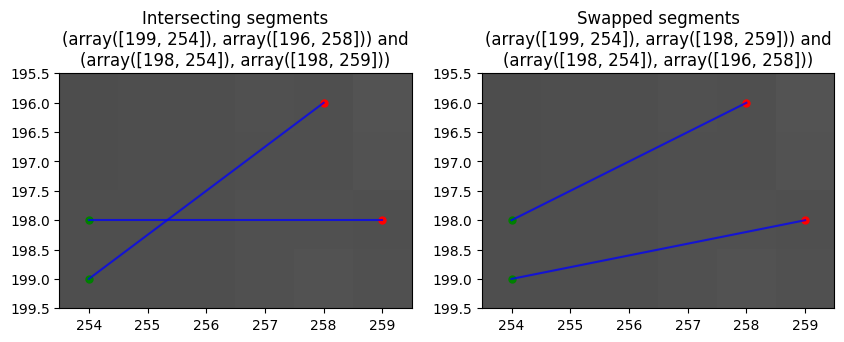

Segment (array([206, 237]), array([197, 237])) intersects with segment (array([205, 236]), array([205, 238]))


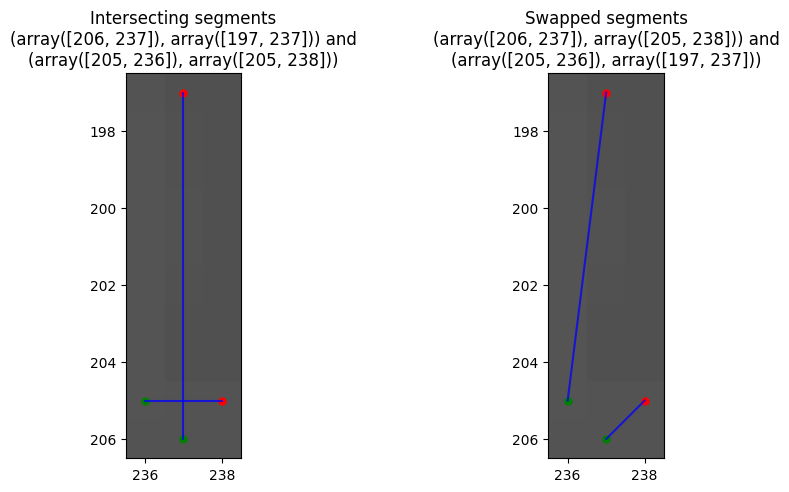

Segment (array([199,  28]), array([198,  29])) intersects with segment (array([194,  25]), array([200,  30]))


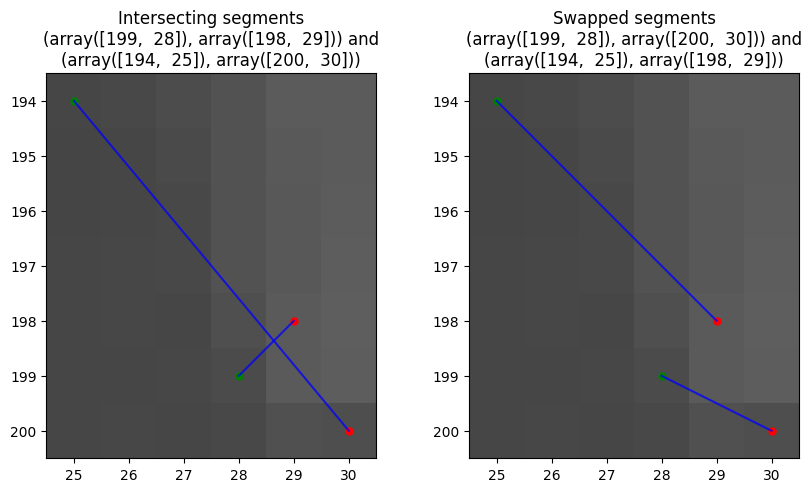

Segment (array([201, 392]), array([199, 391])) intersects with segment (array([200, 392]), array([200, 391]))


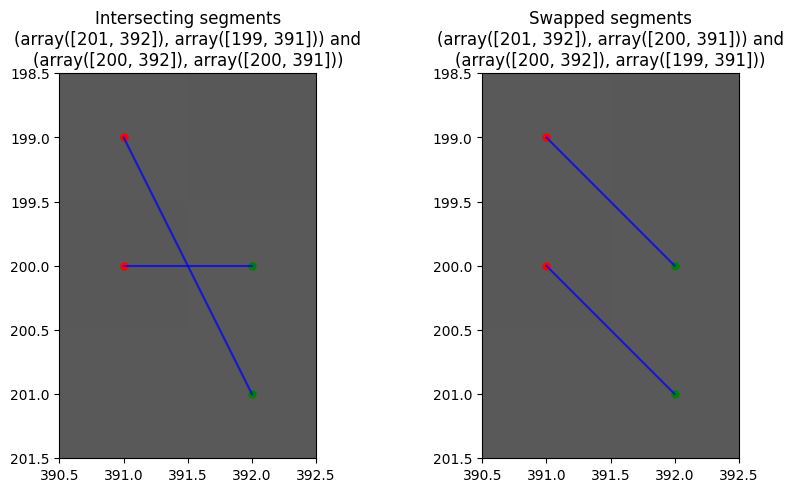

Segment (array([201, 424]), array([199, 426])) intersects with segment (array([200, 425]), array([201, 425]))


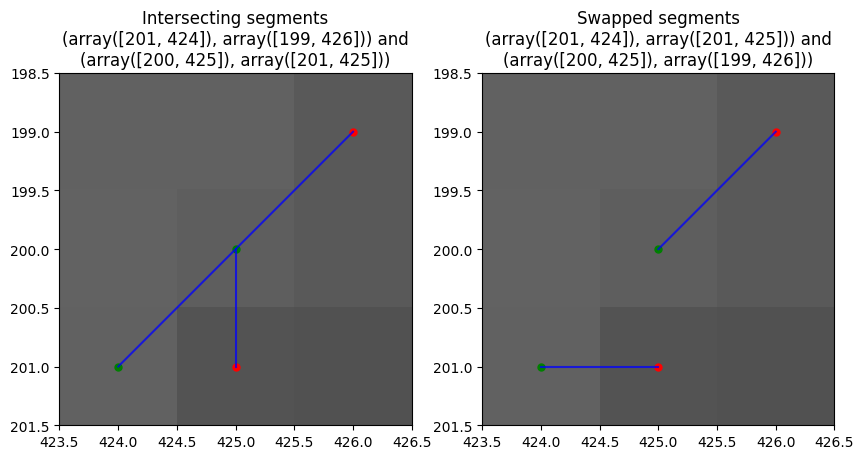

Segment (array([194, 260]), array([200, 266])) intersects with segment (array([193, 262]), array([201, 265]))


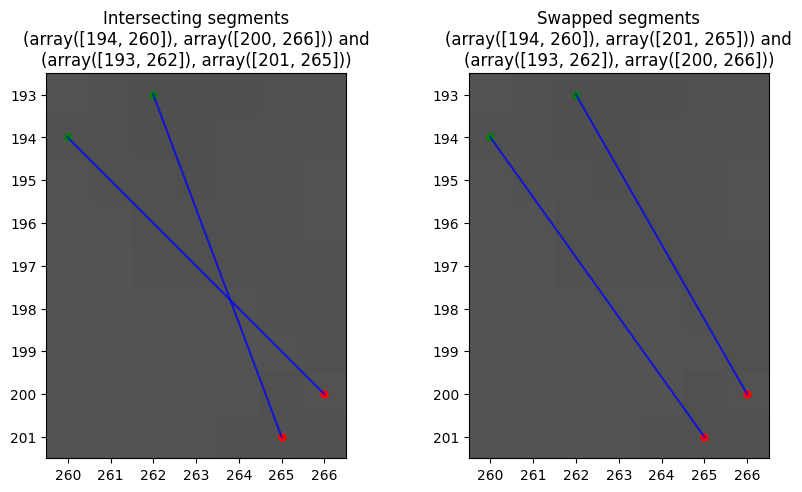

Segment (array([203, 423]), array([203, 425])) intersects with segment (array([202, 424]), array([204, 424]))


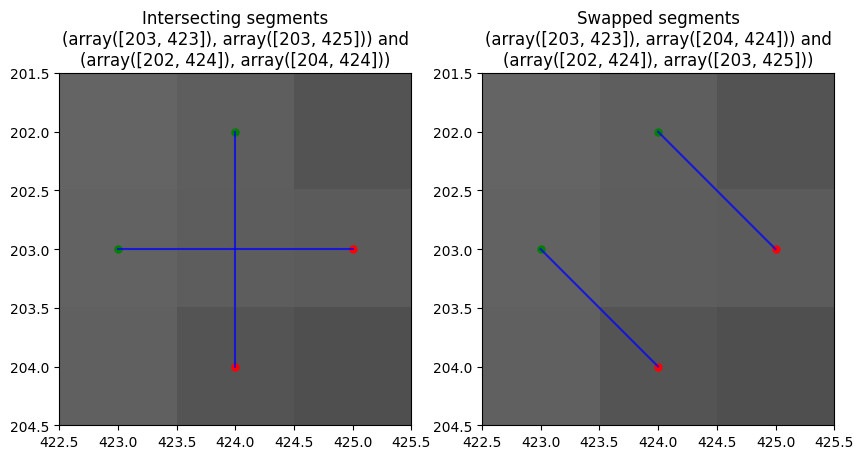

Segment (array([212, 181]), array([205, 182])) intersects with segment (array([211, 180]), array([214, 186]))


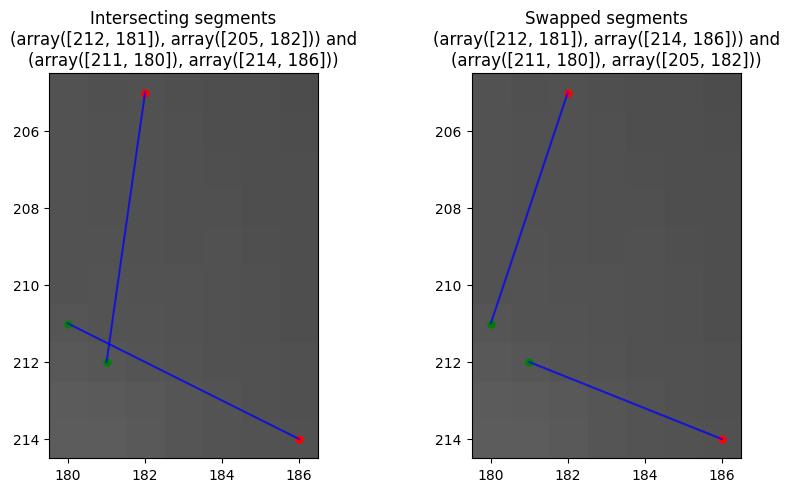

Segment (array([206, 422]), array([205, 424])) intersects with segment (array([205, 423]), array([206, 423]))


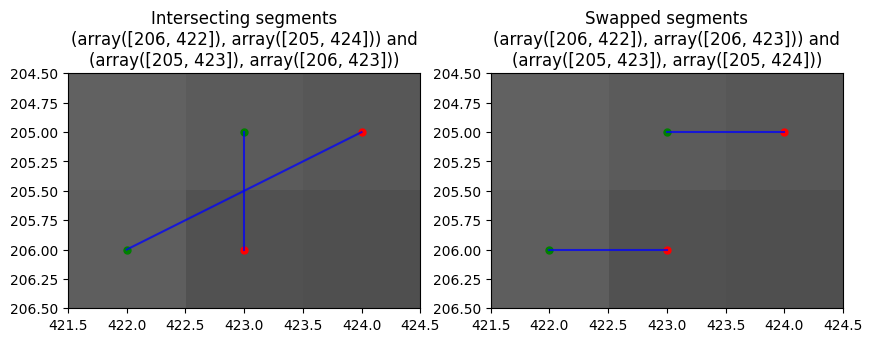

Segment (array([215, 272]), array([206, 273])) intersects with segment (array([214, 273]), array([214, 269]))


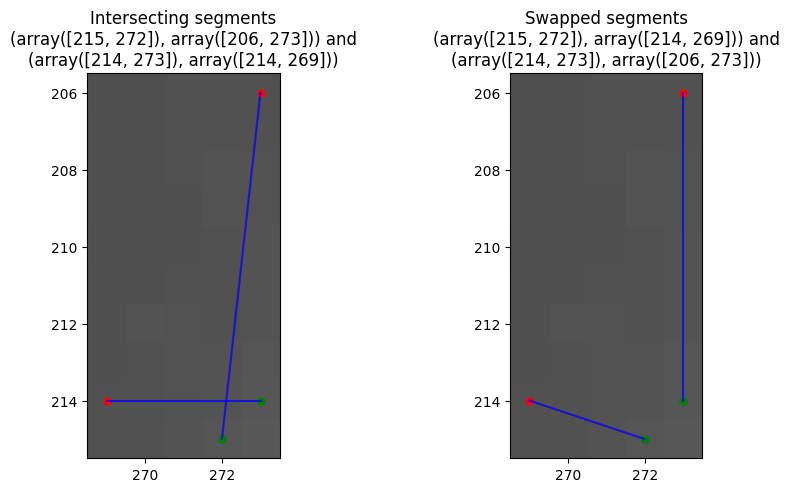

Segment (array([208, 388]), array([206, 388])) intersects with segment (array([207, 388]), array([207, 387]))


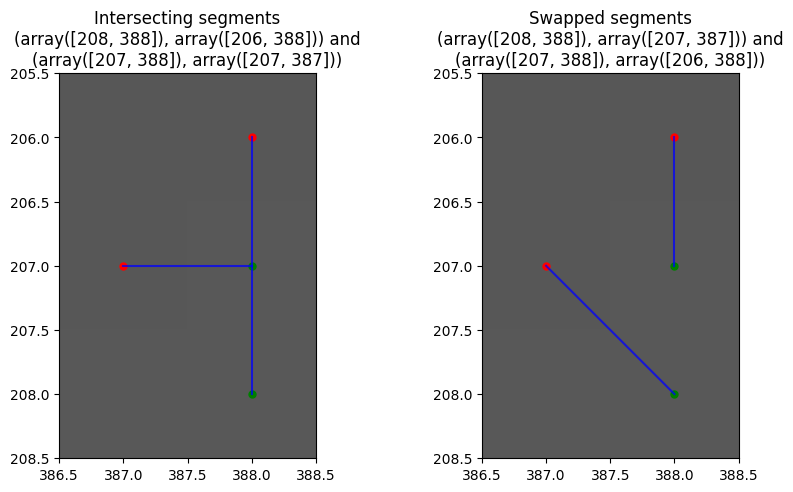

Segment (array([216, 215]), array([207, 216])) intersects with segment (array([214, 216]), array([210, 214]))


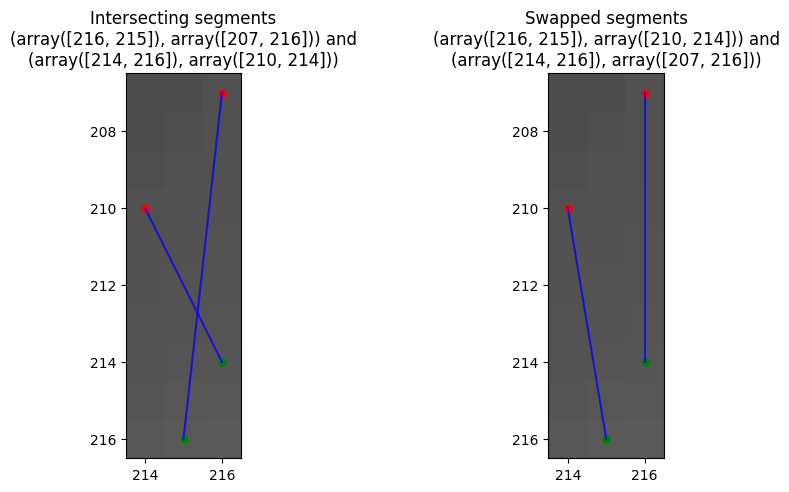

Segment (array([216, 215]), array([207, 216])) intersects with segment (array([209, 220]), array([214, 212]))


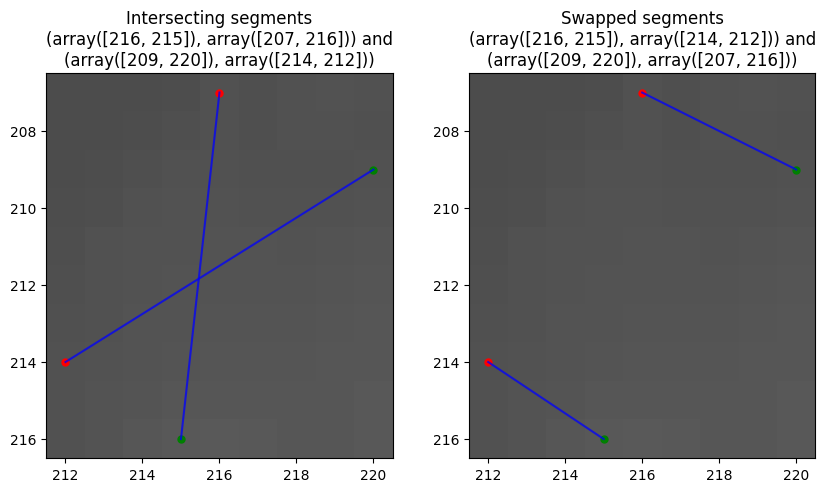

Segment (array([210, 238]), array([207, 238])) intersects with segment (array([209, 237]), array([214, 244]))


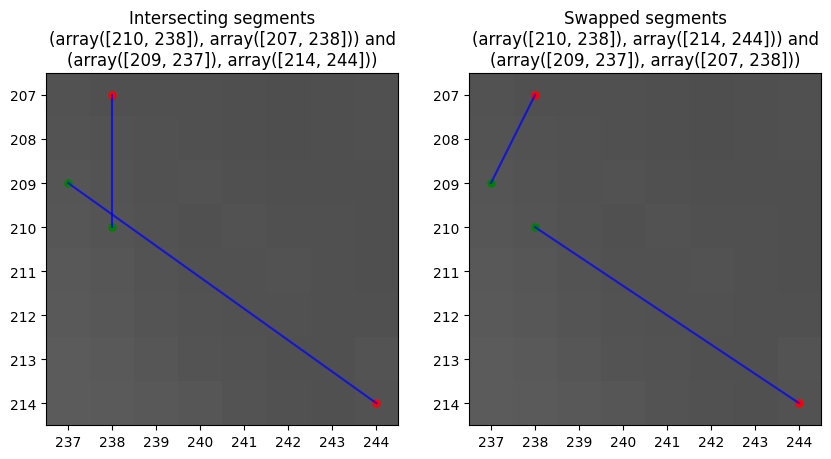

Segment (array([211, 238]), array([208, 239])) intersects with segment (array([209, 237]), array([214, 244]))


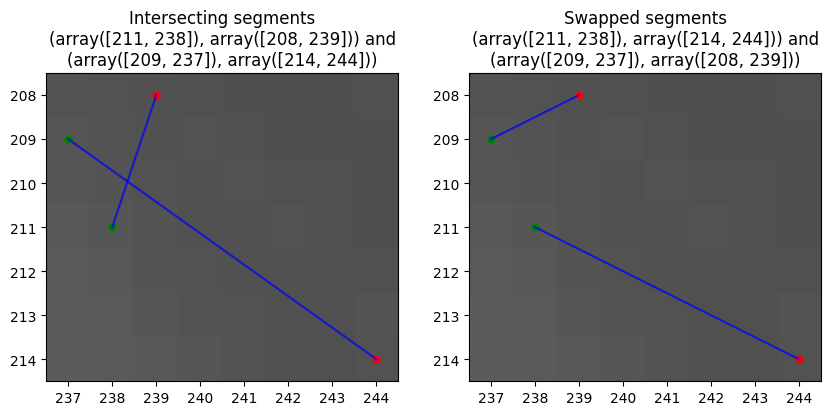

Segment (array([210, 386]), array([208, 386])) intersects with segment (array([209, 387]), array([209, 386]))


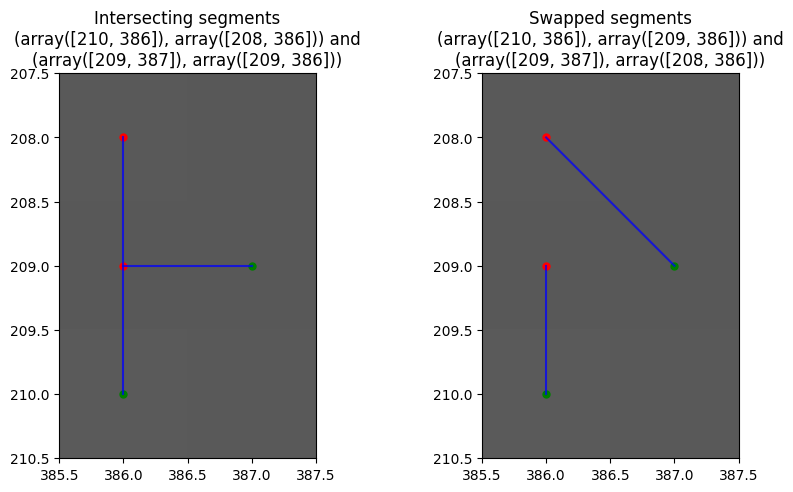

Segment (array([208, 421]), array([208, 423])) intersects with segment (array([207, 422]), array([212, 421]))


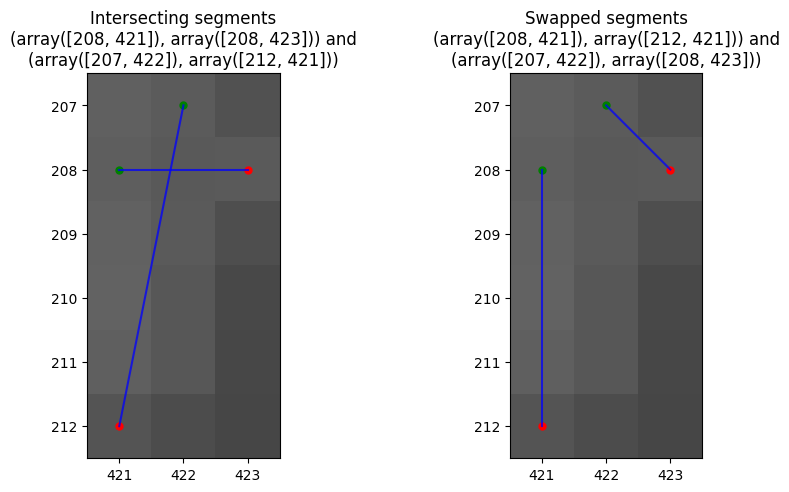

Segment (array([215, 215]), array([209, 215])) intersects with segment (array([214, 216]), array([210, 214]))


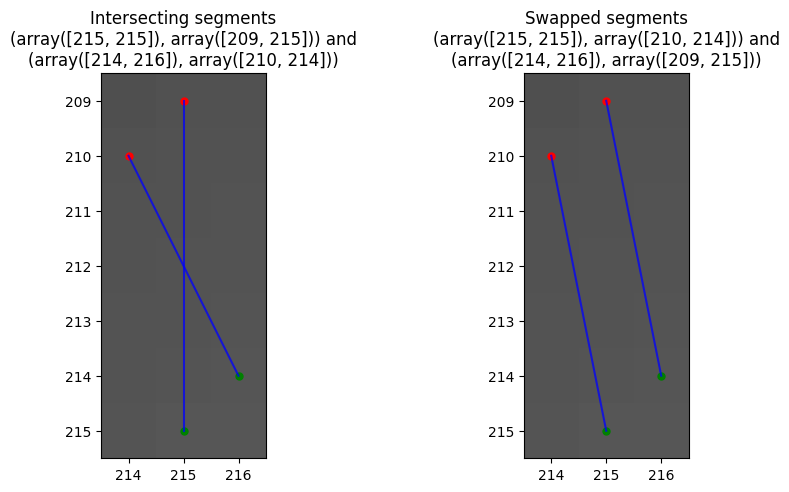

Segment (array([215, 215]), array([209, 215])) intersects with segment (array([209, 220]), array([214, 212]))


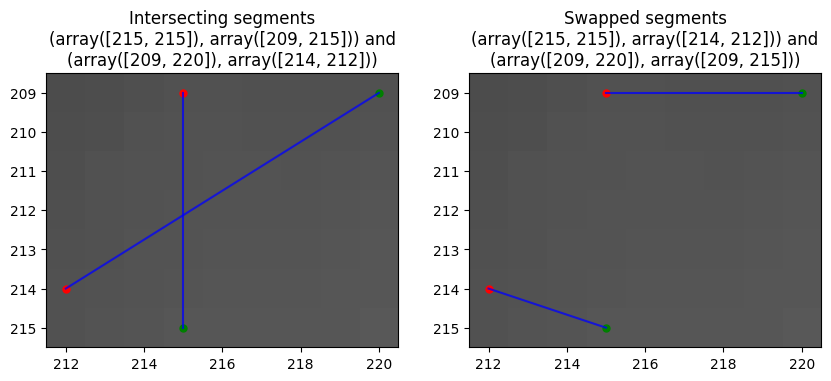

Segment (array([213, 240]), array([209, 240])) intersects with segment (array([212, 239]), array([212, 243]))


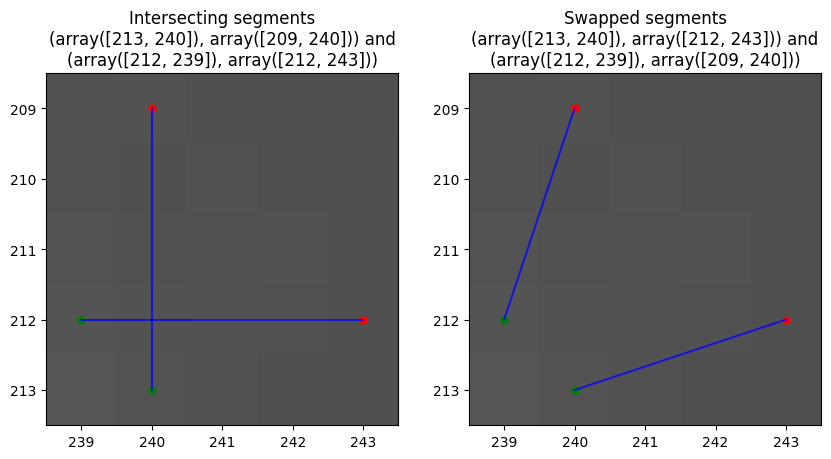

Segment (array([213, 240]), array([209, 240])) intersects with segment (array([209, 237]), array([214, 244]))


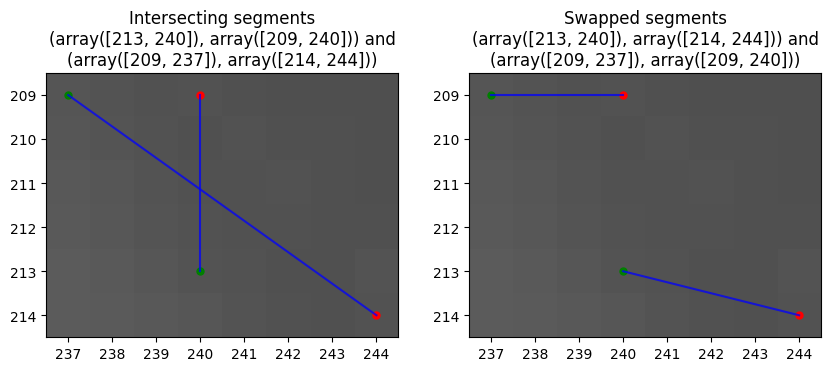

Segment (array([209, 421]), array([209, 422])) intersects with segment (array([207, 422]), array([212, 421]))


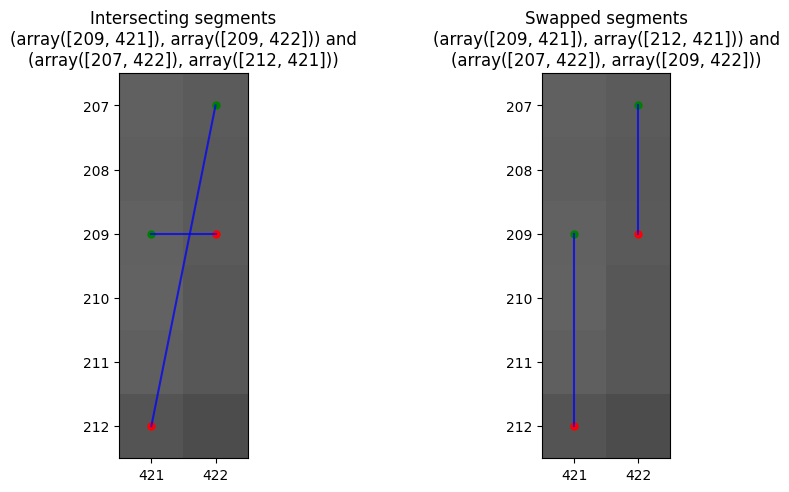

Segment (array([214, 216]), array([210, 214])) intersects with segment (array([209, 220]), array([214, 212]))


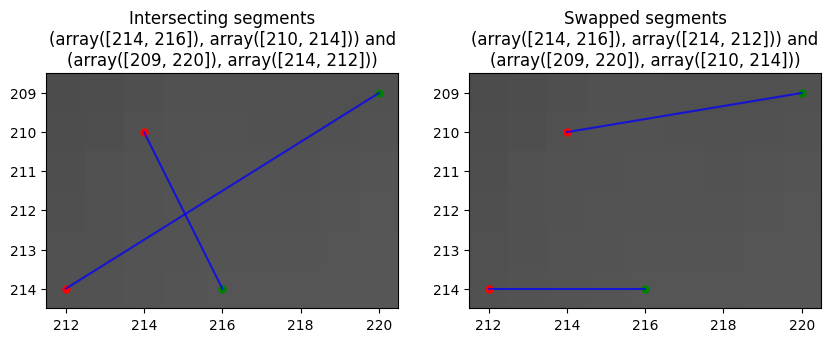

Segment (array([212, 385]), array([210, 385])) intersects with segment (array([211, 386]), array([211, 385]))


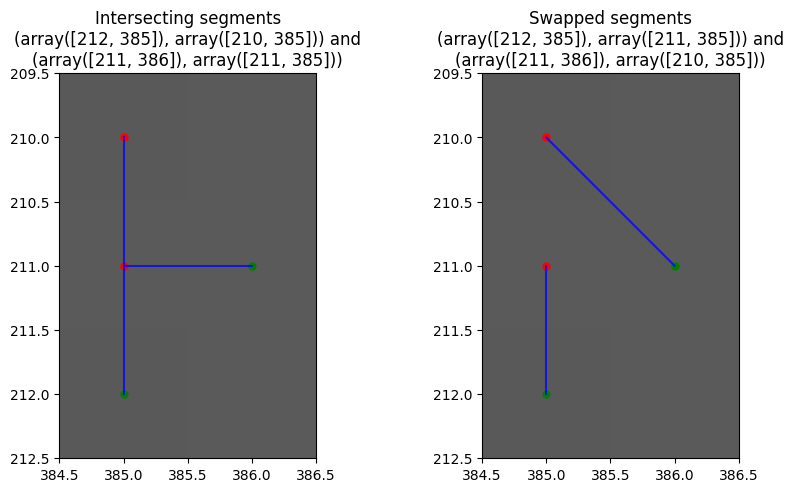

Segment (array([210, 421]), array([210, 422])) intersects with segment (array([207, 422]), array([212, 421]))


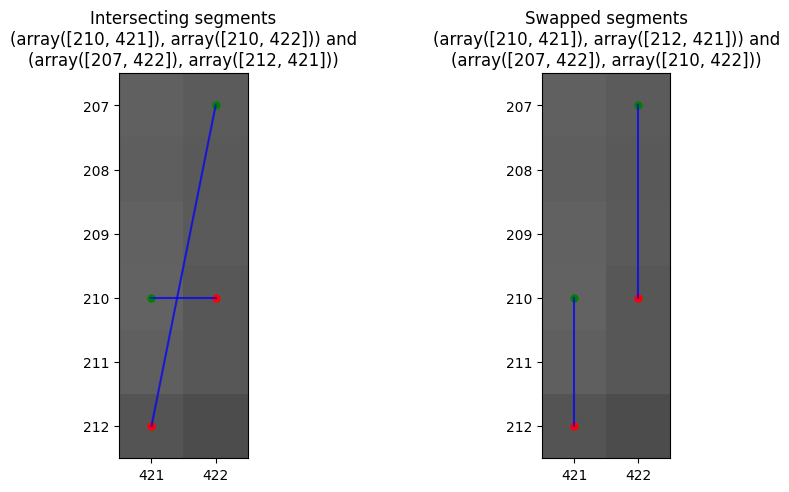

Segment (array([212, 239]), array([212, 243])) intersects with segment (array([209, 237]), array([214, 244]))


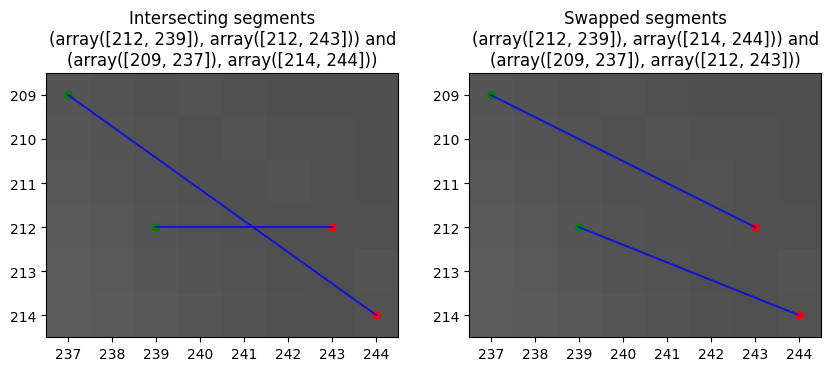

Segment (array([216, 272]), array([212, 270])) intersects with segment (array([214, 273]), array([214, 269]))


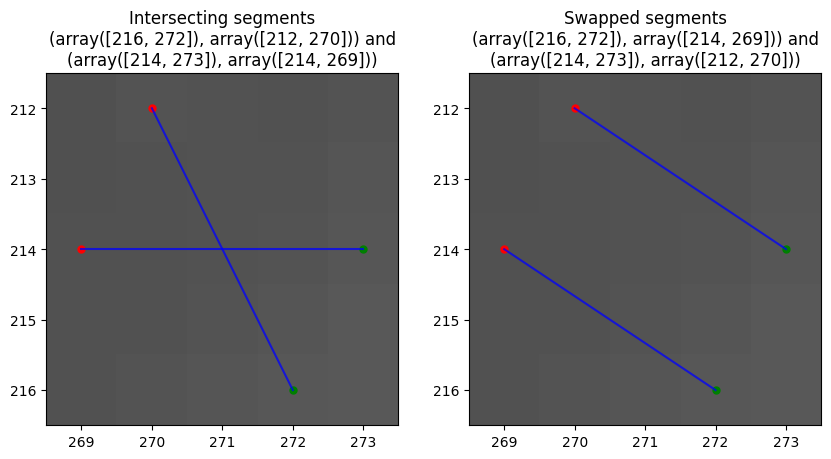

Segment (array([218, 297]), array([212, 300])) intersects with segment (array([217, 301]), array([213, 297]))


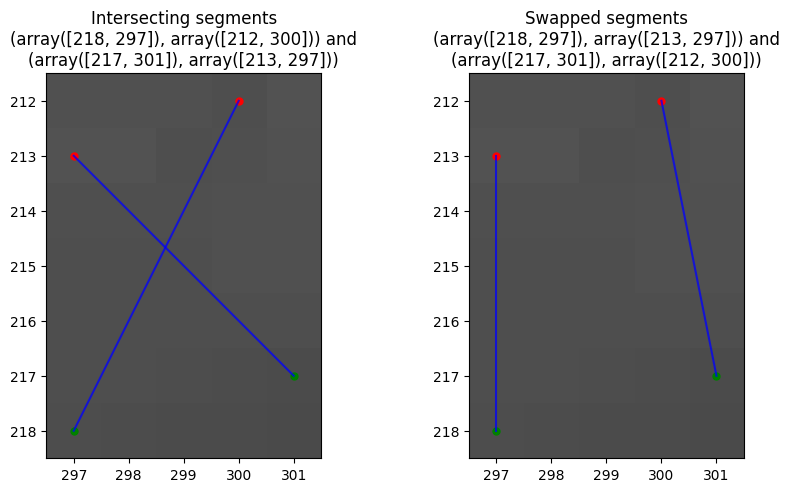

Segment (array([217, 418]), array([213, 421])) intersects with segment (array([215, 419]), array([215, 420]))


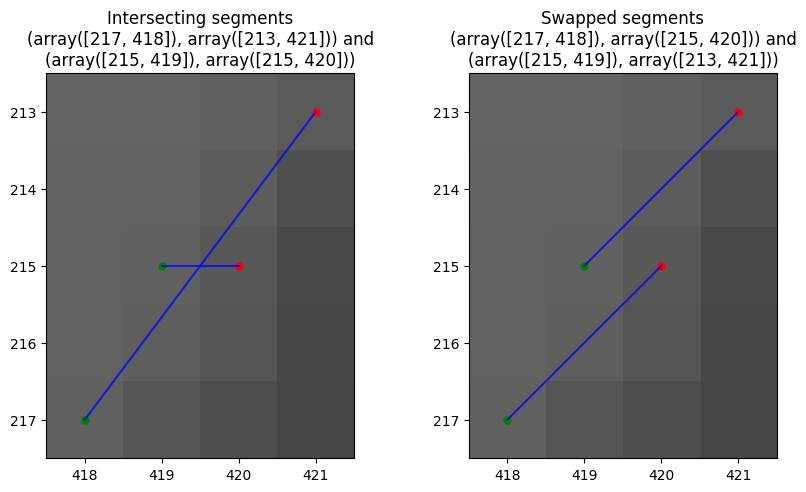

Segment (array([216,  83]), array([216,  82])) intersects with segment (array([215,  82]), array([217,  83]))


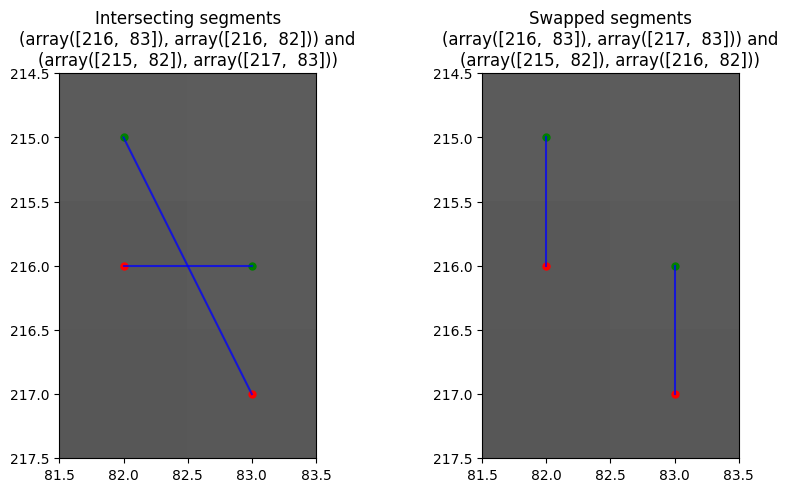

Segment (array([224, 164]), array([216, 164])) intersects with segment (array([224, 163]), array([216, 165]))


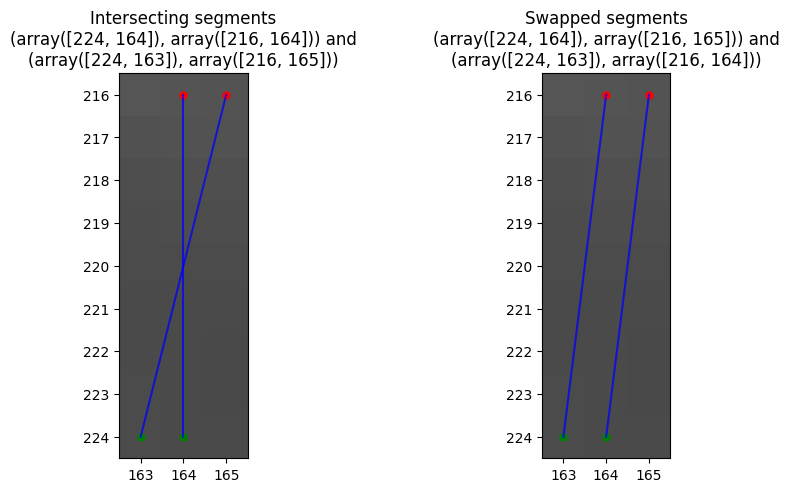

Segment (array([217, 313]), array([218, 311])) intersects with segment (array([216, 313]), array([219, 311]))


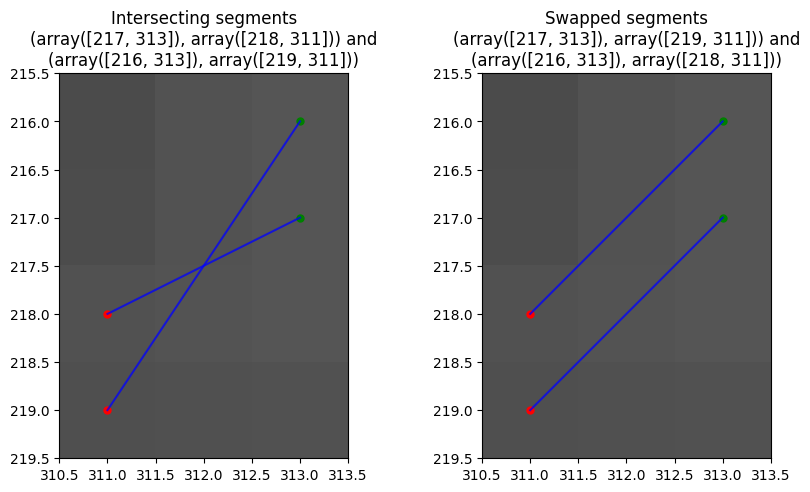

Segment (array([219, 417]), array([219, 419])) intersects with segment (array([218, 418]), array([220, 418]))


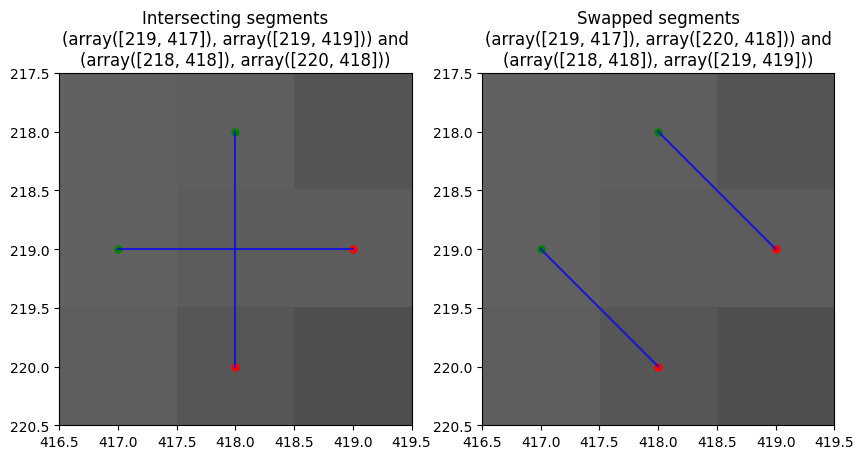

Segment (array([229, 312]), array([220, 311])) intersects with segment (array([228, 312]), array([221, 311]))


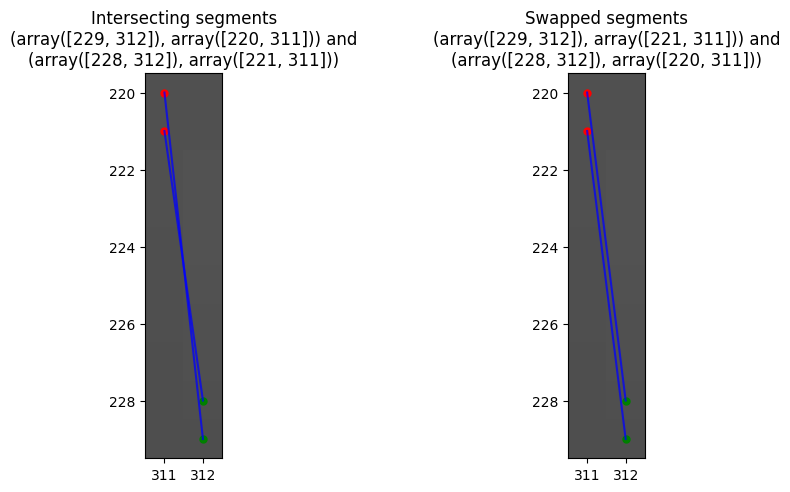

Segment (array([221,  89]), array([221,  86])) intersects with segment (array([220,  88]), array([223,  88]))


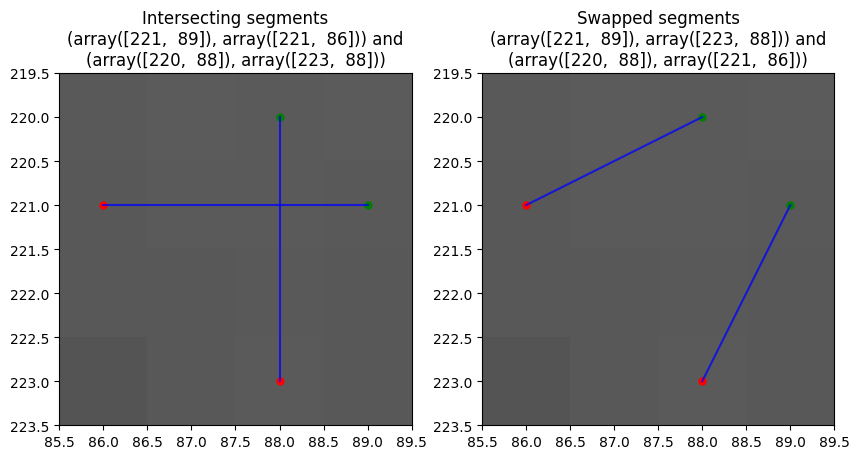

Segment (array([222, 416]), array([221, 418])) intersects with segment (array([221, 417]), array([222, 417]))


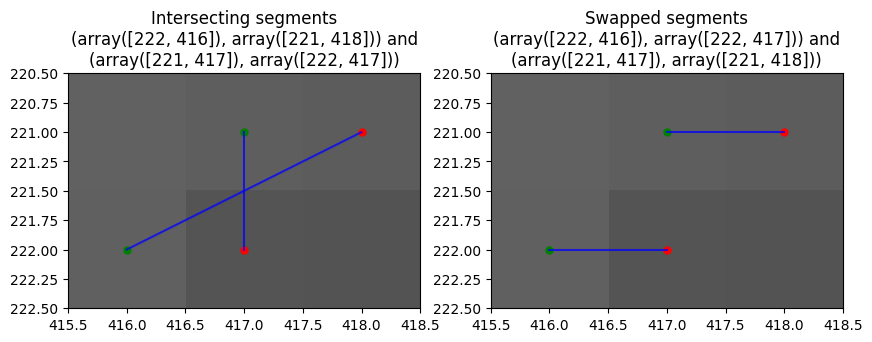

Segment (array([224,  92]), array([224,  89])) intersects with segment (array([223,  91]), array([226,  92]))


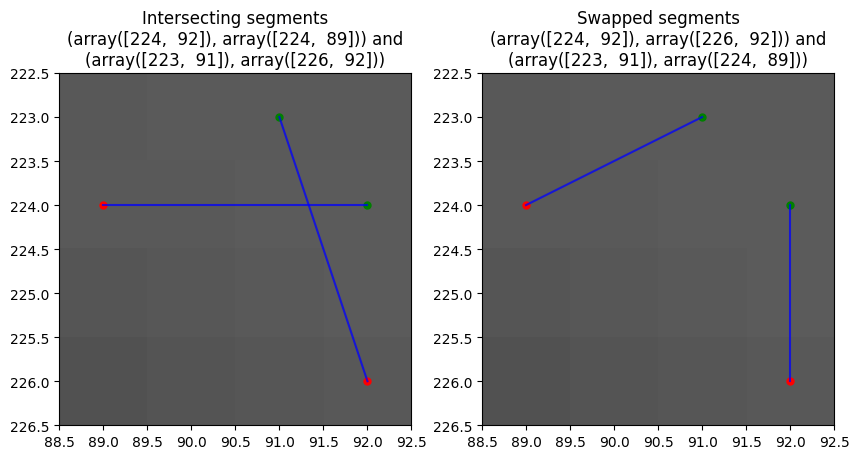

Segment (array([224, 415]), array([224, 417])) intersects with segment (array([223, 416]), array([225, 416]))


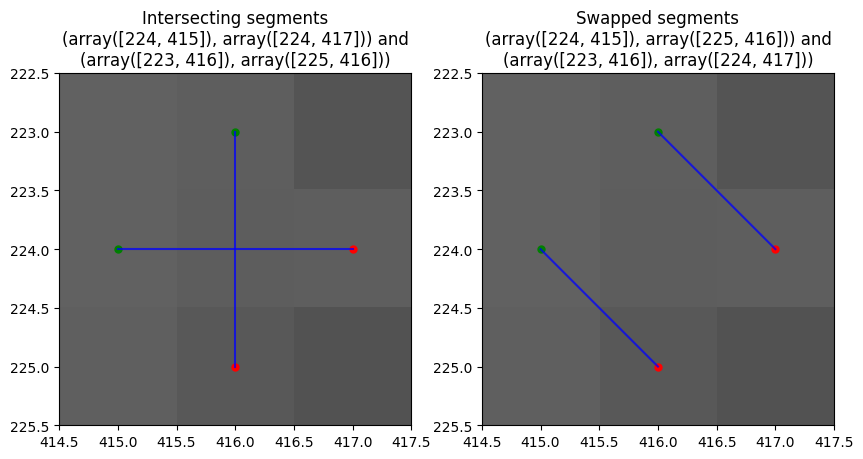

Segment (array([235, 241]), array([228, 242])) intersects with segment (array([235, 242]), array([229, 240]))


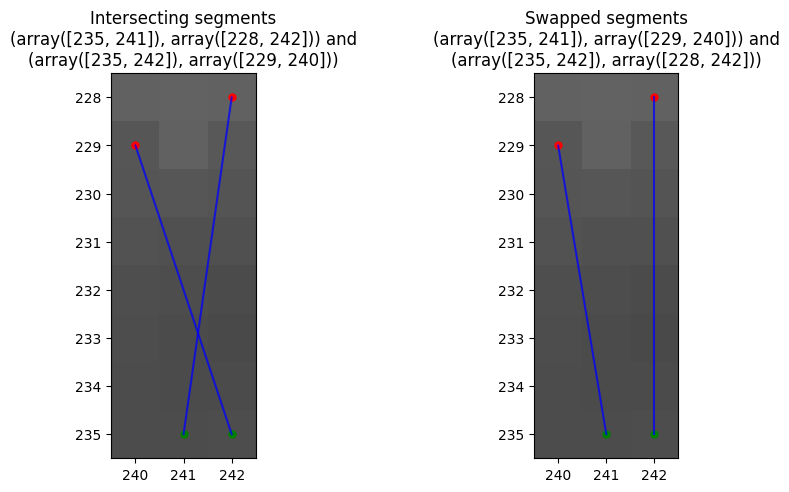

Segment (array([236, 323]), array([231, 322])) intersects with segment (array([237, 323]), array([232, 323]))


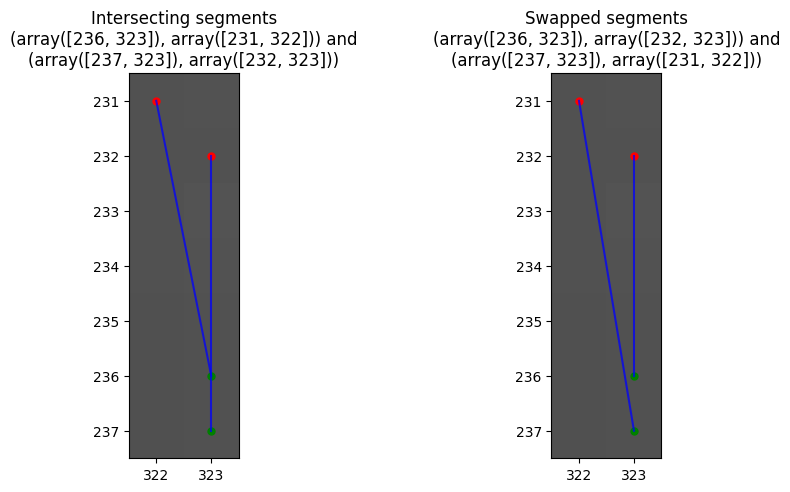

Segment (array([237, 323]), array([232, 323])) intersects with segment (array([238, 324]), array([233, 323]))


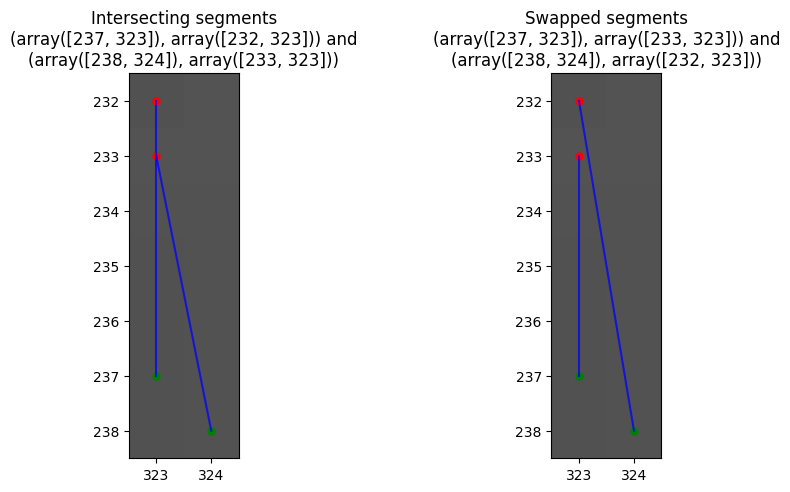

Segment (array([241, 256]), array([237, 255])) intersects with segment (array([241, 255]), array([238, 261]))


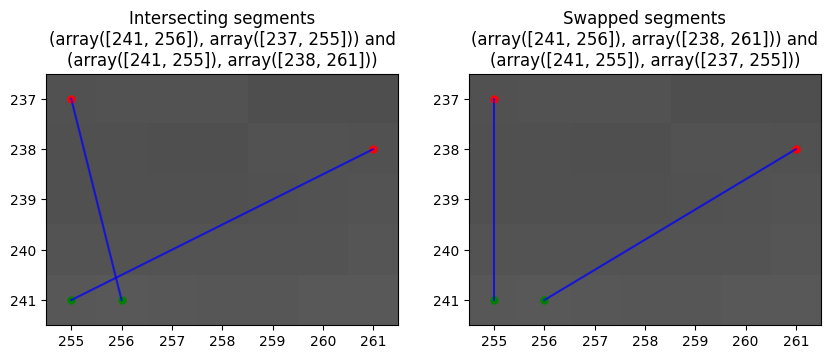

Segment (array([241, 257]), array([237, 256])) intersects with segment (array([241, 255]), array([238, 261]))


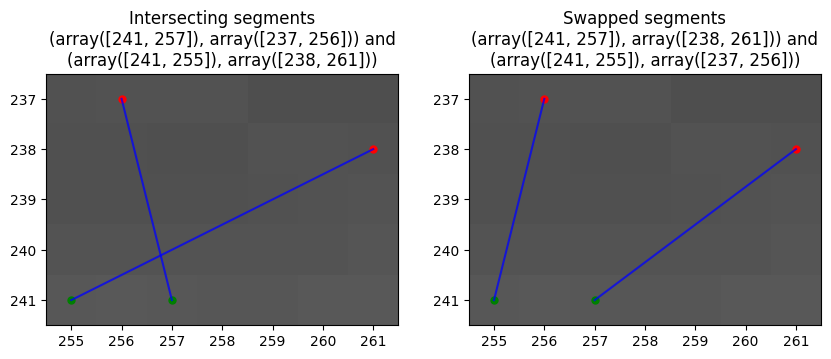

Segment (array([237,  99]), array([238,  97])) intersects with segment (array([236,  98]), array([238,  98]))


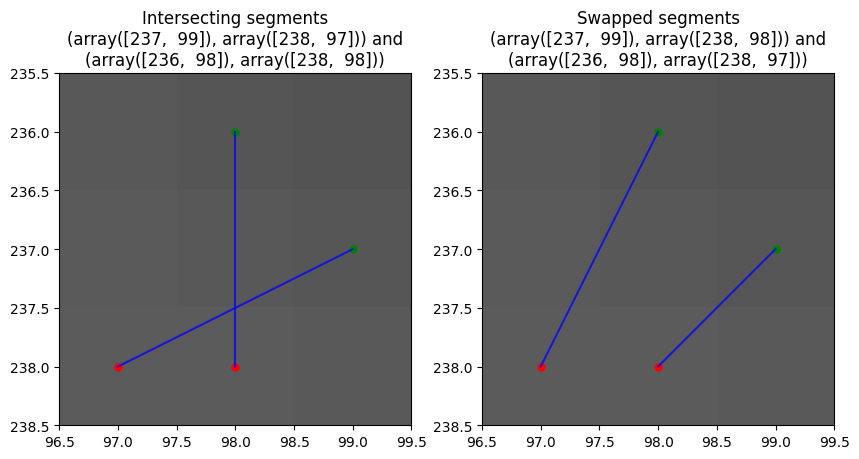

Segment (array([249, 238]), array([245, 236])) intersects with segment (array([248, 238]), array([248, 236]))


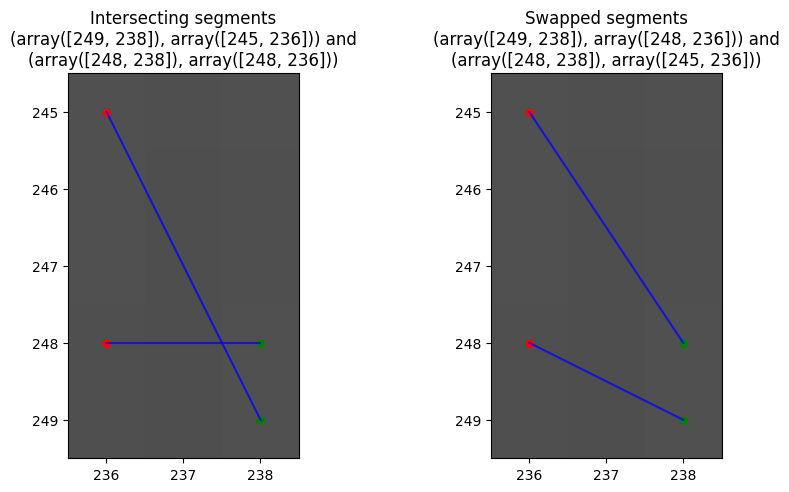

Segment (array([250,  66]), array([253,  63])) intersects with segment (array([249,  65]), array([254,  65]))


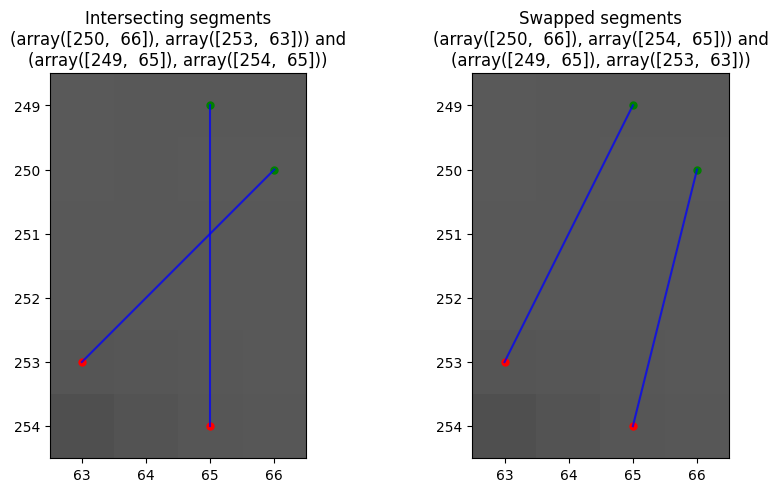

Segment (array([251,  67]), array([254,  64])) intersects with segment (array([249,  65]), array([254,  65]))


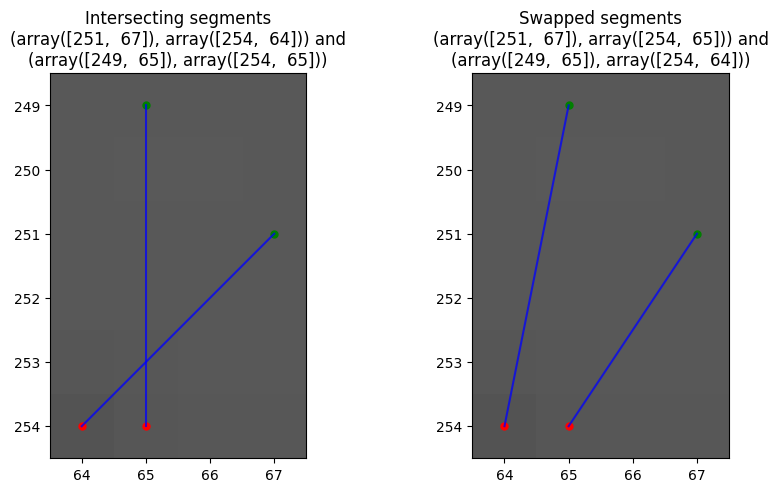

Segment (array([255, 387]), array([256, 387])) intersects with segment (array([254, 389]), array([257, 384]))


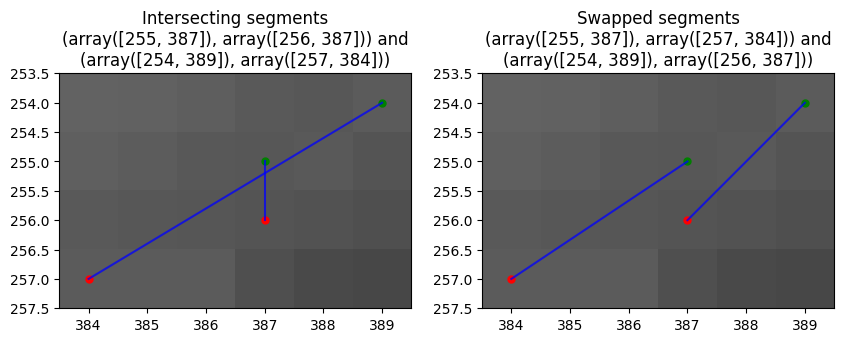

Segment (array([264,  91]), array([261,  84])) intersects with segment (array([262,  88]), array([262,  86]))


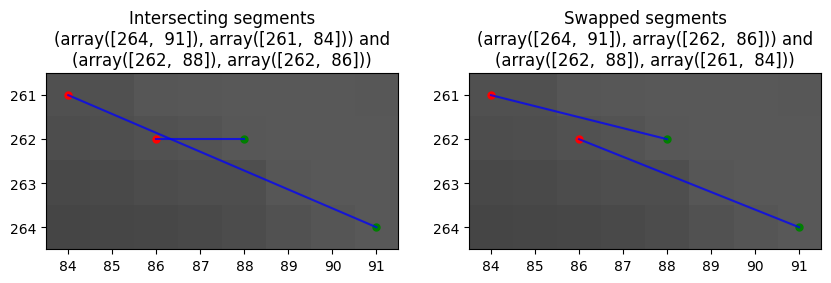

Segment (array([264,  91]), array([261,  84])) intersects with segment (array([263,  89]), array([263,  88]))


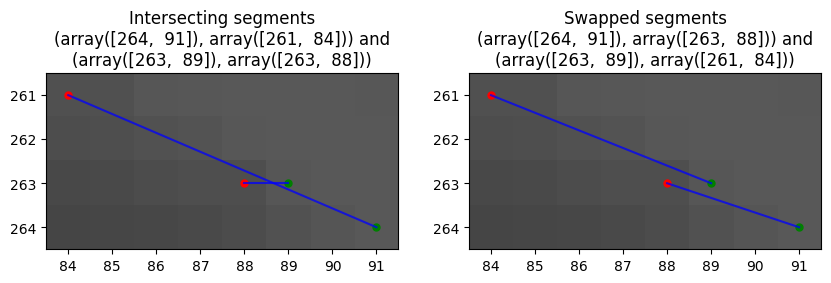

Segment (array([262, 259]), array([261, 259])) intersects with segment (array([262, 257]), array([261, 261]))


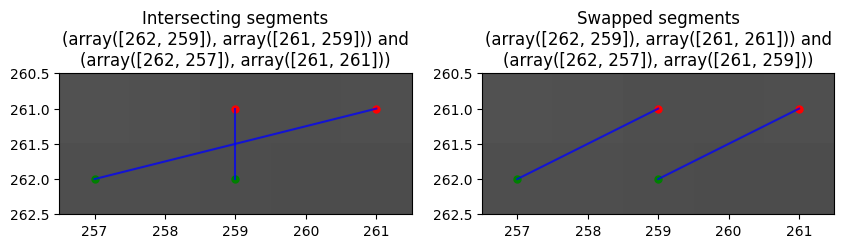

Segment (array([262,  88]), array([262,  86])) intersects with segment (array([261,  87]), array([262,  87]))


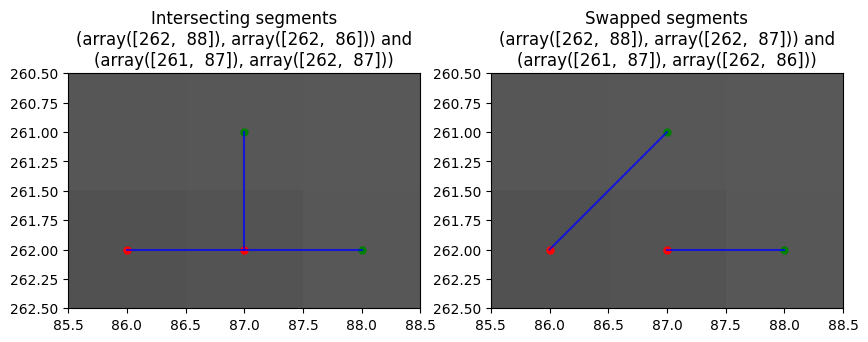

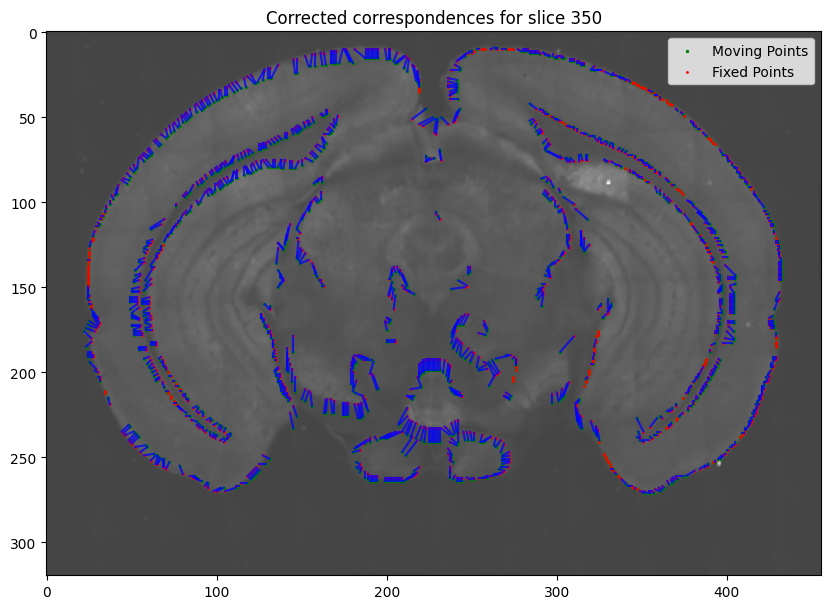

In [21]:
VISUALIZE_INTERSECTIONS = True

# Load the NIfTI file
nifti_img = nib.load('data/base/registered_output/elastixRefined.nii.gz').get_fdata()[curr_idx]

mpts = curr_mpoints_unique[::1]
fpts = curr_fpoints_unique[::1]

plot_correspondences(mpts, fpts, nifti_img, "Original correspondences for slice " + str(curr_idx))

fpts, ipts = swap_correspondences(mpts, fpts)
min_intersection_count = len(ipts)
curr_fpts = fpts
while True:
    fpts, ipts_temp = swap_correspondences(mpts, fpts)
    intersection_count = len(ipts_temp)
    print("Number of intersecting points:", intersection_count)
    if intersection_count < min_intersection_count:
        min_intersection_count = intersection_count
        curr_fpts = fpts
    else:
        break
fpts = curr_fpts
#fpts = swap_correspondences(mpts, fpts)
#fpts = swap_correspondences(mpts, fpts)

plot_correspondences(mpts, fpts, nifti_img, "Swapped correspondences for slice " + str(curr_idx))

# Detect intersecting line segments
intersecting_indices, intersecting_segments, swapped_segments = detect_intersecting_segments(mpts, fpts)

# Remove intersecting segments from correspondences
new_mpts = mpts.copy()
new_fpts = fpts.copy()
while len(intersecting_indices) != 0:
    new_mpts = [element for i, element in enumerate(new_mpts) if i not in intersecting_indices[:, 0]]
    new_fpts = [element for i, element in enumerate(new_fpts) if i not in intersecting_indices[:, 0]]
    intersecting_indices, intersecting_segments, swapped_segments = detect_intersecting_segments(new_mpts, new_fpts)
    num_intersections = len(intersecting_indices)
    print("Number of intersecting segments left:", num_intersections)
    if num_intersections != 0:
        intersecting_indices, intersecting_segments, swapped_segments = detect_intersecting_segments(new_mpts, new_fpts)
new_mpts = np.array(new_mpts)
new_fpts = np.array(new_fpts)

# Print intersecting segments
print("Number of intersecting segments left:", len(intersecting_segments))
print("Intersecting indices:")
pprint(intersecting_indices)

intersecting_indices, intersecting_segments, swapped_segments = detect_intersecting_segments(curr_mpoints_unique, curr_fpoints_unique)

# Save new correspondences with intersections deleted
if VISUALIZE_INTERSECTIONS:
    for i in range(len(intersecting_segments)):
        seg1, seg2 = intersecting_segments[i]
        swapped_seg1, swapped_seg2 = swapped_segments[i]
        print(f"Segment {seg1} intersects with segment {seg2}")
        offset = 0.5

        # Show the intersecting segments on the plot
        plt.figure( figsize=(10,5))
        plt.subplot(1, 2, 1)
        plt.imshow( nifti_img, cmap='gray', alpha=0.75)
        
        # Show all points
        #plt.scatter( mpts[:,1], mpts[:,0], color='green', s=2)
        #plt.scatter( fpts[:,1], fpts[:,0], color='red', s=2)
        #for i in range(len(mpts)):
        #    plt.plot([mpts[i][1], fpts[i][1]], [mpts[i][0], fpts[i][0]], color='purple', alpha=0.75)
        
        plt.scatter( seg2[0][1], seg2[0][0], color='green', label='Moving Points', s=25)  # mpt
        plt.scatter( seg2[1][1], seg2[1][0], color='red', label='Fixed Points', s=25)  # fpt
        plt.scatter( seg1[0][1], seg1[0][0], color='green', label='Moving Points', s=25)  # mpt
        plt.scatter( seg1[1][1], seg1[1][0], color='red', label='Fixed Points', s=25)  # fpt
        plt.plot([seg1[0][1], seg1[1][1]], [seg1[0][0], seg1[1][0]], color='blue', alpha=0.75)
        plt.plot([seg2[0][1], seg2[1][1]], [seg2[0][0], seg2[1][0]], color='blue', alpha=0.75)
        plt.title(f"Intersecting segments\n{seg1} and\n{seg2}")
        plt.xlim(min( seg1[0][1], seg1[1][1], seg2[0][1], seg2[1][1]) - offset, max( seg1[0][1], seg1[1][1], seg2[0][1], seg2[1][1]) + offset)
        plt.ylim(min( seg1[0][0], seg1[1][0], seg2[0][0], seg2[1][0]) - offset, max( seg1[0][0], seg1[1][0], seg2[0][0], seg2[1][0]) + offset)
        plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
        
        
        # Second subplot
        plt.subplot(1, 2, 2)
        plt.imshow( nifti_img, cmap='gray', alpha=0.75)
        
        # Show all points
        #plt.scatter( mpts[:,1], mpts[:,0], color='green', s=2)
        #plt.scatter( fpts[:,1], fpts[:,0], color='red', s=2)
        #for i in range(len(mpts)):
        #    plt.plot([mpts[i][1], fpts[i][1]], [mpts[i][0], fpts[i][0]], color='purple', alpha=0.75)
        
        plt.scatter( swapped_seg2[0][1], swapped_seg2[0][0], color='green', label='Moving Points', s=25)  # mpt
        plt.scatter( swapped_seg2[1][1], swapped_seg2[1][0], color='red', label='Fixed Points', s=25)  # fpt
        plt.scatter( swapped_seg1[0][1], swapped_seg1[0][0], color='green', label='Moving Points', s=25)  # mpt
        plt.scatter( swapped_seg1[1][1], swapped_seg1[1][0], color='red', label='Fixed Points', s=25)  # fpt
        plt.plot([swapped_seg1[0][1], swapped_seg1[1][1]], [swapped_seg1[0][0], swapped_seg1[1][0]], color='blue', alpha=0.75)
        plt.plot([swapped_seg2[0][1], swapped_seg2[1][1]], [swapped_seg2[0][0], swapped_seg2[1][0]], color='blue', alpha=0.75)
        plt.title(f"Swapped segments\n{swapped_seg1} and\n{swapped_seg2}")
        plt.xlim(min( swapped_seg1[0][1], swapped_seg1[1][1], swapped_seg2[0][1], swapped_seg2[1][1]) - offset, max( swapped_seg1[0][1], swapped_seg1[1][1], swapped_seg2[0][1], swapped_seg2[1][1]) + offset)
        plt.ylim(min( swapped_seg1[0][0], swapped_seg1[1][0], swapped_seg2[0][0], swapped_seg2[1][0]) - offset, max( swapped_seg1[0][0], swapped_seg1[1][0], swapped_seg2[0][0], swapped_seg2[1][0]) + offset)
        plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
        plt.show()
        
    # Negative Jacobian implies intersection ( preferred) or
    # if we remove all intersections, we remove all negative Jacobians
    # intersection implies negative Jacobian? Need to show either way
    #  it is possible that even after removign all intersections, there is still negative Jacobian
    
plot_correspondences(new_mpts, new_fpts, nifti_img, "Corrected correspondences for slice " + str(curr_idx))

In [11]:
new_mpts

array([[ 17, 178],
       [ 17, 179],
       [ 18, 172],
       ...,
       [271, 354],
       [271, 355],
       [271, 357]])

In [12]:
def swap_segments(intersecting_segments):
    """
    Swap the endpoints of the intersecting segments.
    
    Parameters:
    - intersecting_segments: A list of tuples, where each tuple contains two line segments.
    
    Returns:
    - swapped_segments: A list of tuples, where each tuple contains two line segments with swapped endpoints.
    """
    swapped_segments = []
    for seg1, seg2 in intersecting_segments:
        swapped_segments.append(((seg1[0], seg2[1]), (seg2[0], seg1[1])))
    return swapped_segments

In [13]:
# How many of our negative Jacobian determinant points are part of the intersecting segments?
num_intersecting_matches = 0
for coord in coordinates_list:
    for seg1, seg2 in intersecting_segments:
        if coord == tuple(seg1[0]) or coord == tuple(seg1[1]) or coord == tuple(seg2[0]) or coord == tuple(seg2[1]):
            num_intersecting_matches += 1
            break

# How many points in the negative jacobian determinant section are part of our failed Delaunay verification checks?
total_points = len(coordinates_list)

print("Number of points in negative Jacobian determinant section that are part of intersecting segments:")
print(f"\t{num_intersecting_matches}/{total_points} ({num_intersecting_matches/total_points*100:.2f}%)")

Number of points in negative Jacobian determinant section that are part of intersecting segments:
	0/1287 (0.00%)


In [14]:
# How many Jacobians are in the negative section that are part of the intersecting correspondences (neighborhood check)?
num_matches_neighborhood = 0
for i in range(total_points):
    jacobian_coord = coordinates_list[i]
    # Check if the point is in the correspondences
    if check_neighborhood(jacobian_coord, ipts, 5):
        num_matches_neighborhood += 1

print("Number of points in negative Jacobian determinant section that are part of intersecting correspondences (neighborhood):")
print(f"\t{num_matches_neighborhood}/{total_points} ({num_matches_neighborhood/total_points*100:.2f}%)")

Number of points in negative Jacobian determinant section that are part of intersecting correspondences (neighborhood):
	505/1287 (39.24%)


In [15]:
# How many intersecting correspondences are part of the negative Jacobians (neighborhood check)?
num_matches_neighborhood = 0
for i in range(len(ipts)):
    ipt_coord = ipts[i]
    # Check if the point is in the correspondences
    if check_neighborhood(ipt_coord, coordinates_list, 5):
        num_matches_neighborhood += 1

print("Number of points in negative Jacobian determinant section that are part of intersecting correspondences (neighborhood):")
print(f"\t{num_matches_neighborhood}/{total_points} ({num_matches_neighborhood/total_points*100:.2f}%)")

Number of points in negative Jacobian determinant section that are part of intersecting correspondences (neighborhood):
	327/1287 (25.41%)
